# Prepare

## Import

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm.notebook import tqdm

import time
from copy import deepcopy
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
sys.path.append('C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts')
# sys.path.append('C:\\_Lib\\python\\multimode')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, get_current_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Warning serial library import failed.
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver


In [2]:
import json
import os
# path = os.getcwd()
path = r'H:\Shared drives\SLab\Multimode\experiment\250505_craqm' # for data 
print("path: ", path)

path:  H:\Shared drives\SLab\Multimode\experiment\250505_craqm


## Setup experiment hardware

In [3]:
expt_path = os.path.join(path, 'data')

print('Data will be stored in', expt_path)

Data will be stored in H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data


In [4]:
curr_path = os.getcwd()
config_file = os.path.join(curr_path, 'configs', 'hardware_config_202505.yml')
config_path = config_file
print('Hardware configs will be read from', config_path)

exp_param_file = os.path.join(curr_path, 'configs', 'experiment_config.yml')
exp_param_path = exp_param_file
print('Experiment params will be read from', exp_param_path)

Hardware configs will be read from c:\_Lib\python\multimode_expts\configs\hardware_config_202505.yml
Experiment params will be read from c:\_Lib\python\multimode_expts\configs\experiment_config.yml


In [5]:
qubit_i = 0
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [6]:
im = InstrumentManager(ns_address='192.168.137.25') # SLAC lab
im.keys()

dict_keys(['Pyro.NameServer', 'Qick101'])

In [7]:
print(im['Qick101'])

<Pyro4.core.Proxy at 0x1d1000d4a30; not connected; for PYRO:obj_60f1dbe4d66e49e4a42ce8f10a5bd4b8@192.168.137.101:35093>


In [8]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.180
	Firmware timestamp: Tue Oct 15 12:06:51 2024

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 32768 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 32768 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 32768 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 32768 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 32768 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 32768 samples
		DAC ti

## Choose experiment name

In [9]:
# Path to add
expts_path = 'C:\\_Lib\\python\\multimode_expts'

# Add the path to the system path at the highest priority
sys.path.insert(0, expts_path)
print('Path added at highest priority')

# Verify the path is added
print(sys.path)

# Import the experiments module from multimode
import experiments as meas

# Verify the module is imported from the correct path
print(meas.__file__)

Path added at highest priority
['C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python', 'C:\\_Lib\\python\\slab', 'C:\\_Lib\\python\\qick\\qick_lib', 'C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts', 'c:\\_Lib\\python\\multimode_expts', 'c:\\Users\\26049\\.conda\\envs\\slab\\python38.zip', 'c:\\Users\\26049\\.conda\\envs\\slab\\DLLs', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib', 'c:\\Users\\26049\\.conda\\envs\\slab', '', 'C:\\Users\\26049\\AppData\\Roaming\\Python\\Python38\\site-packages', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\easy_lmfit-1.0-py3.8.egg', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\attrdict-2.0.1-py3.8.egg', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32\\lib', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\Pythonwin', '/home/xilinx/jupyter_notebooks/', 'C:\\_Lib\\pytho

### Previous experiment data

In [10]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None, prefix=None):
    if prefix is not None:
        temp_data_file = os.path.join(expt_path,get_current_filename(expt_path, prefix=prefix, suffix='.h5'))
        
    else:
        temp_data_file = expt_path+'\\'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        # print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs, temp_data_file

## Datset for Sidebands

In [11]:
from dataset import *
from dataset import storage_man_swap_dataset
import os 

file_path = os.path.join(expts_path, 'man1_storage_swap_dataset.csv')
# print(os.makedirs(file_path, exist_ok=True))
ds = storage_man_swap_dataset(file_path)

ds_thisrun = storage_man_swap_dataset(ds.create_copy())
ds_thisrun_file_path = os.path.join(expts_path, ds_thisrun.filename)
ds_thisrun.df

stor_name   freq (MHz)  precision (MHz)   pi (mus)  h_pi (mus)  \
0      M1-S1   348.917815              NaN   0.956182    0.475160   
1      M1-S2   520.414253              NaN   1.117174    0.557202   
2      M1-S3   696.148466              NaN   1.315943    0.646777   
3      M1-S4   874.820000              NaN   1.235174    0.619427   
4      M1-S5  1052.782582              NaN   1.962559    0.979321   
5      M1-S6  1244.647695              NaN   1.592175    0.803092   
6      M1-S7  1422.460000              NaN   2.211538    1.093041   
7      M1-S8    -1.000000            -1.00  -1.000000   -1.000000   
8      M1-S9    -1.000000            -1.00  -1.000000   -1.000000   
9     M1-S10    -1.000000            -1.00  -1.000000   -1.000000   
10    M1-S11    -1.000000            -1.00  -1.000000   -1.000000   
11    M1-S12    -1.000000            -1.00  -1.000000   -1.000000   
12        M1  2005.900000              NaN   1.082052    0.532975   
13        M2  1834.950000             0.01   1.054456    0.520515   
14     M2-S1   175.630000             0.01   2.173484    1.086742   
15     M2-S2   346.840000             0.01   0.908835    0.454417   
16     M2-S3   523.220000             0.01   1.561615    0.780808   
17     M2-S4   702.650000             0.01   1.386764    0.693382   
18     M2-S5   878.780000             0.01   1.303372    0.651686   
19     M2-S6  1070.100000             0.01   2.379622    1.189811   
20     M2-S7  1249.700000             0.01   1.796981    0.898491   
21     M2-M1   173.790000             0.01   0.463481    0.231741   
22     M1-D1  2313.426206             0.01  10.000000    0.000000   
23     M2-D2  2094.050000             0.01  15.000000    0.000000   
24      M1-C   973.230000             0.02   0.251127    0.122354   
25     M1_ce  2008.780000             0.02   0.617915    0.304523   

    gain (DAC units)                 last_update  
0               3000  2025-06-04 16:28:12.912630  
1               5000  2025-06-04 16:31:01.032528  
2               9000  2025-06-04 16:33:49.039622  
3               9000  2025-06-04 16:36:37.090280  
4               7500  2025-06-04 16:39:25.181021  
5              13500  2025-06-04 16:42:13.388233  
6              10000  2025-06-04 16:45:01.590826  
7                 -1                     51:31.3  
8                 -1                     51:31.3  
9                 -1                     51:31.3  
10                -1                     51:31.3  
11                -1                     51:31.3  
12             15000  2025-06-04 16:24:35.098422  
13             15000  2025-04-30 11:22:11.432806  
14              1000                     28:20.8  
15              5000                     33:56.1  
16              5000                     22:30.3  
17              9000                     25:33.1  
18             13500                     00:05.4  
19              9000                     30:59.0  
20             12000                     56:07.5  
21              2000  2024-10-06 01:47:25.946153  
22              4000  2025-06-04 17:23:32.148629  
23              8000  2025-01-23 17:22:53.776061  
24              1000  2025-01-20 09:34:00.029234  
25             15000  2025-01-20 09:52:35.311227

# Qubit characterization

Handling of parameter updating: 

The experiment objects are initialized with the `config_path`, meaning they will read from our hardware config file and set the `self.cfg` to that. 
But here we will be overriding that immediately with a new config AttrDict that is at first just a deepcopy of that yaml file but as we go over each cell the values inside this `config_thisrun` will be gradually updated. 
Throughout the notebook, the updated config will only live in memory, until you decide to write it to disk.


What experiments to run?
 
Depending on stage of cooldown, we will run a different sequence of calibration experiments. For example, amplitude rabi don't need to be updated every time, but the frequency correction from T2 is important to do every day. In the dictionary experiments to run, we will speciy the experiments we want to run. 

In [12]:
config_thisrun = AttrDict(deepcopy(yaml_cfg))


In [13]:
config_thisrun.device.storage.storage_man_file = ds_thisrun_file_path
config_thisrun.device.manipulate

{'f_ge': [4984.6412134851635, 5157.8527963217475],
 'standard_dispalce': [0.05, 0.05],
 'revival_time': [1.5972763957631686, 1.7366205852286094],
 'gain_to_alpha': [0.00014281, 0.00020045],
 'freq_to_alpha': [0.495062203431879, 0.0],
 'chi_ge': [-0.2706830738546445],
 'chi_ef': [-0.24699343445018568],
 'ramp_sigma': 0.005}

In [14]:
expts_to_run = {# readout 
                'res_spec': False, # Readout spectroscopy
                'single_shot': True, 
                # qubit ge 
                'pulse_probe_ge': False,
                't2_ge': True, 
                'amplitude_ge': False,
                't1_ge': False,
                # qubit ef
                'pulse_probe_ef': False,
                't2_ef': True,
                'amplitude_ef': False,
                't1_ef': False,

                # manipulate 
                'man_modes': [1], # [1,2] if also want to run mode 2
                'pulse_probe_f0g1': False,
                'length_rabi_sweep':False,
                'length_rabi':False, # this will run automatically if the length_rabi_sweep is set to True
                'chi_ge': False, 
                'chi_ef': False,

                #storage
                'stor_modes': [1,2,3,4,5,6,7], # [1,2, .., 7] if also want to run  all modes 
                'stor_spectroscopy': False,
                'sideband_freq_sweep': False,
                'sideband_length_rabi': False,
                # 'storage_t1': True
                }

In [15]:
from datetime import datetime

# create directory inside data folder for autocalibration plots
# Get the current date and add it to the directory name
autocalib_path = os.path.join(expt_path, f'autocalibration_plots_{datetime.now().strftime("%Y-%m-%d")}')

os.makedirs(autocalib_path, exist_ok=True)
print('Directory created for autocalibration plots at:', autocalib_path)

Directory created for autocalibration plots at: H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\autocalibration_plots_2025-06-13


## Resonator 

### Resonator Spectroscopy

Fitting parameters are wrong because of using the hanger function (more or less reflection/2), instead of transmission. Is this an easy fix?

In [16]:
def do_res_spec(config_thisrun): 
    rspec = meas.single_qubit.resonator_spectroscopy.ResonatorSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='ResonatorSpectroscopyExperiment', config_file=config_path
    )

    rspec.cfg = AttrDict(deepcopy(config_thisrun))

    rspec.cfg.expt = dict(
        start = 746.5, # resonator frequency to be mixed up [MHz]
        step = 0.02, # min step ~1 Hz
        expts = 250, # Number experiments stepping from start
        reps = 1000, # Number averages per point
        pulse_e = False, # add ge pi pulse prior to measurement
        pulse_f = False, # add ef pi pulse prior to measurement
        pulse_cavity = False,  # prepulse on cavity prior to measurement (False also disables next line)
        cavity_pulse = [4984.373226159381, 8000, 2, 0], # [frequency, gain, length, phase]  const pulse
        qubit = 0,
    )

    rspec.cfg.device.readout.relax_delay = [50] # Wait time between experiments [us]
    rspec.go(analyze=True, display=True, progress=True, save=True)
    return rspec

def update_res_spec(rspec, config_thisrun):
    config_thisrun.device.readout.frequency = [rspec.data['fit'][0]]
    print('Updated readout frequency!')

In [17]:
if expts_to_run['res_spec']: 
    rspec = do_res_spec()

In [18]:
if expts_to_run['res_spec']: 
    update_res_spec(rspec, config_thisrun)
    print('Resonator spectroscopy done!')

## Single Shot

In [19]:
def do_single_shot(
    config_thisrun,
    expt_path,
    config_path,
    qubits=[0],
    reps=5000,
    check_f=False,
    active_reset=True,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=800,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    relax_delay=250
):
    """Run the single shot experiment with configurable parameters."""

    # if pre_sweep_pulse is None:
    #     pre_sweep_pulse = [
    #         ['qubit', 'ge', 'pi', 0],
    #     ]

    hstgrm = meas.single_qubit.single_shot.HistogramExperiment(
        soccfg=soc, path=expt_path, prefix='HistogramExperiment', config_file=config_path
    )

    hstgrm.cfg = AttrDict(deepcopy(config_thisrun))

    hstgrm.cfg.expt = {
        'qubits': qubits,
        'reps': reps,
        'check_f': check_f,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'qubit': qubit,
        'pulse_manipulate': pulse_manipulate,
        'cavity_freq': cavity_freq,
        'cavity_gain': cavity_gain,
        'cavity_length': cavity_length,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'gate_based': gate_based,
    }

    hstgrm.cfg.device.readout.relax_delay = [relax_delay]  # Wait time between experiments [us]
    hstgrm.go(analyze=False, display=False, progress=True, save=True)
    return hstgrm


def update_single_shot(hstgrm, config_thisrun):
    """Update the configuration based on single shot experiment results."""
    from multimode_expts.fit_display_classes import Histogram
    
    hist_analysis = Histogram(
            hstgrm.data, verbose=True,
             span=800, threshold=None, config=hstgrm.cfg,
        )
    hist_analysis.analyze(plot = True)
    fids = hist_analysis.results['fids']
    confusion_matrix = hist_analysis.results['confusion_matrix']
    thresholds_new = hist_analysis.results['thresholds']
    angle = hist_analysis.results['angle']
    print(fids)

    config_thisrun.device.readout.phase = [config_thisrun.device.readout.phase[0] + angle]
    config_thisrun.device.readout.threshold = thresholds_new
    config_thisrun.device.readout.threshold_list = [thresholds_new]
    config_thisrun.device.readout.Ie = np.median(hstgrm.data['Ie_rot'])
    config_thisrun.device.readout.Ig = np.median(hstgrm.data['Ig_rot'])
    config_thisrun.device.readout.confusion_matrix_without_reset = confusion_matrix
    print('Updated readout!')

In [20]:
hstgrm = None
if expts_to_run['single_shot']: 
    hstgrm = do_single_shot(config_thisrun,  expt_path, config_path, reps = 5000, active_reset=False, relax_delay = 2500)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00102_HistogramExperiment.h5


In [21]:
config_path

'c:\\_Lib\\python\\multimode_expts\\configs\\hardware_config_202505.yml'

In [22]:
expt_path

'H:\\Shared drives\\SLab\\Multimode\\experiment\\250505_craqm\\data'

{'device': {'qubit': {'T1': [370.2930190133963], 'f_ge': [3567.3621176882566], 'f_ef': [3423.998699387194], 'ramp_sigma': [0.005], 'ramp_sigma_num': [3.0], 'pulses': {'pi_ge': {'gain': [10409], 'sigma': [0.035], 'length': [0.0], 'type': ['gauss']}, 'hpi_ge': {'gain': [4636], 'length': [0.0], 'sigma': [0.035], 'type': ['gauss']}, 'pi_ef': {'gain': [8221], 'length': [0.0], 'sigma': [0.035], 'type': ['gauss']}, 'hpi_ef': {'gain': [3858], 'sigma': [0.035], 'type': ['gauss']}}, 'T1_ef': [169.37650413956644]}, 'readout': {'trig_offset': [450], 'frequency': [748.8], 'gain': [800], 'phase': [26.883374172655888], 'threshold': [-305.5327404544614], 'threshold_list': [[-305.5327404544614]], 'man1_drive_list': [0.0], 'man2_drive_list': [0.0], 'readout_length': [1.5], 'relax_delay': [2500], 'confusion_matrix_with_reset': [0.9964530022802125, 0.0035469977197875036, 0.013768302080657598, 0.9862316979193424], 'confusion_matrix_without_reset': [0.9924, 0.007600000000000051, 0.02359999999999999, 0.9764]

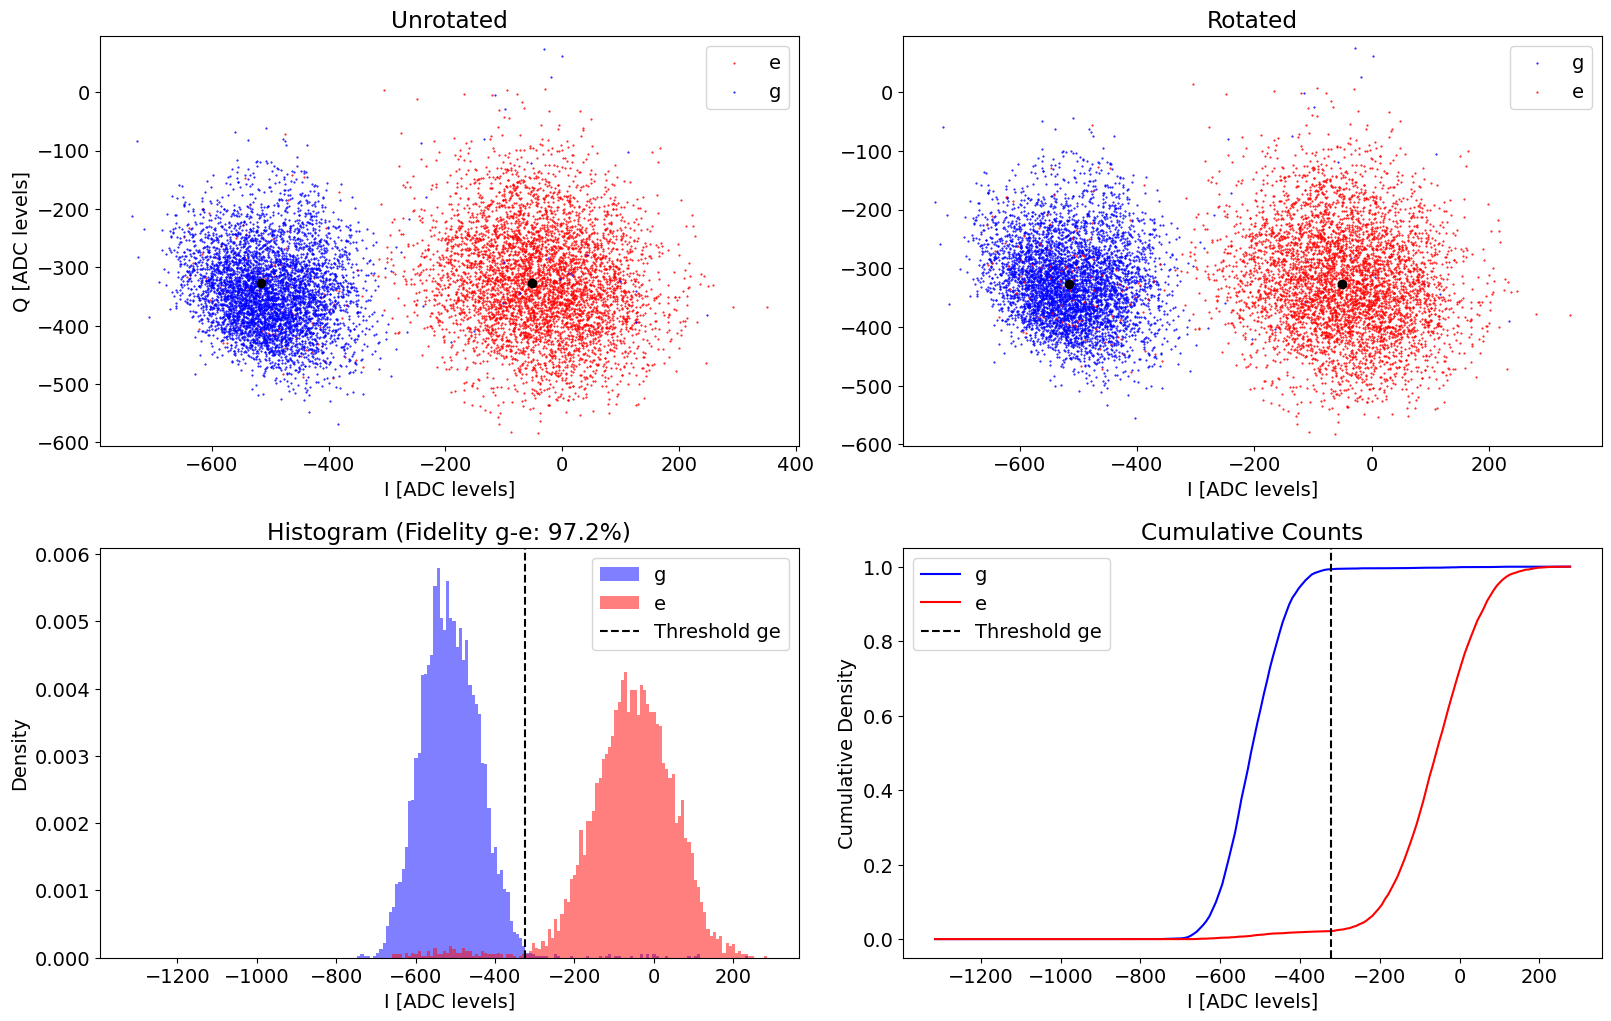

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-13_09-12-57_histogram.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-13.md
[0.9717957191438288]
Updated readout!
Single shot done!


In [23]:
if expts_to_run['single_shot']:
    update_single_shot(hstgrm, config_thisrun)
    print('Single shot done!')

### JPA Calibration

In [24]:
def do_jpa_current_sweep( config_thisrun,
    expt_path,
    config_path,
    jpa_current_start=-8,
    jpa_current_step=0.1,
    jpa_current_stop = -2,
    qubits=[0],
    reps=5000,
    check_f=False,
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=800,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    relax_delay=2500
):
    """Run the single shot experiment with configurable parameters."""
    from multimode_expts.sequential_experiment_classes import histogram_sweep_class
    experiment_class = histogram_sweep_class
    sweep_experiment_name = 'histogram_jpa_current_sweep'
    class_for_exp = experiment_class(soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file)



    class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    
    class_for_exp.loaded[sweep_experiment_name] =  {
        'qubits': qubits,
        'reps': reps,
        'check_f': check_f,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'qubit': qubit,
        'pulse_manipulate': pulse_manipulate,
        'cavity_freq': cavity_freq,
        'cavity_gain': cavity_gain,
        'cavity_length': cavity_length,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'gate_based': gate_based,
        'jpa_current_start': jpa_current_start,
        'jpa_current_step': jpa_current_step,
        'jpa_current_stop': jpa_current_stop,
    }


    
    class_for_exp.yaml_cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]

    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)

In [25]:
# sweep_func = do_jpa_current_sweep(config_thisrun, expt_path, config_path, reps=1000, jpa_current_start=-5, jpa_current_step=0.03, jpa_current_stop=5)

## Qubit ge

### Pulse-probe

In [26]:
def do_pulse_probe_ge(
    config_thisrun, 
    start=3560,  # [MHz]
    step=0.1,  # min step ~1 MHz
    expts=200,  # Number of experiments stepping from start
    reps=2000,  # Number of averages per point
    rounds=1,  # Number of start to finish sweeps to average over
    length=1,  # Qubit probe constant pulse length [us]
    gain=400,  # Qubit pulse gain
    sigma=0.1,  # Qubit flat top sigma
    wait_qubit=False,
    qubit=0,
    cavity_drive=False,
    cavity_name=0,  # 0 is man1, 1 is man2
    cavity_gain=4000,
    cavity_length=1,  # Constant pulses of cavity [us]
    cavity_pulse=[False, 0.1]  # Truth value for gaussian cavity pulse, type, sigma
): 
    qspec = meas.single_qubit.pulse_probe_spectroscopy.PulseProbeSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeSpectroscopyExperiment', config_file=config_path
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = dict(
        start=start,
        step=step,
        expts=expts,
        reps=reps,
        rounds=rounds,
        length=length,
        gain=gain,
        sigma=sigma,
        wait_qubit=wait_qubit,
        qubit=qubit,
        cavity_drive=cavity_drive,
        cavity_name=cavity_name,
        cavity_gain=cavity_gain,
        cavity_length=cavity_length,
        cavity_pulse=cavity_pulse
    )

    qspec.cfg.device.readout.relax_delay = [50] # Wait time between experiments [us]
    qspec.go(analyze=True, display=True, progress=True, save=True)
    return qspec

def update_pulse_probe_ge(qspec, config_thisrun):
    config_thisrun.device.qubit.f_ge = [qspec.data['fit_avgi'][2]]
    print('Updated qubit frequency!')

In [27]:
if expts_to_run['pulse_probe_ge']: 
    qspec = do_pulse_probe_ge(config_thisrun)

In [28]:
if expts_to_run['pulse_probe_ge']:
    update_pulse_probe_ge(qspec, config_thisrun)
    print('Pulse probe spectroscopy done!')

### T2 Ramsey

In [29]:
def do_t2_ramsey_ge(
    config_thisrun,
    expt_path,
    config_path,
    pre_sweep_pulse=None,
    post_sweep_pulse=None,
    step_size=0.2,
    if_ef=False,
    ef_init=True,
    start=0.01,
    expts=200,
    ramsey_freq=0.2,
    reps=200,
    rounds=1,
    qubits=[0],
    user_defined_freq=[False, 3568.2038290468167, 5304, 0.035],
    f0g1_cavity=0,
    normalize=False,
    active_reset=True,
    man_reset=True,
    storage_reset=False,
    prepulse=None,
    postpulse=None,
    pre_active_reset_pulse=False,
    gate_based=False,
    advance_phase=0,
    echoes=[False, 0],
    relax_delay=200
):
    """Run the T2 Ramsey experiment with all config params as function arguments."""
    t2ramsey = meas.single_qubit.t2_ramsey.RamseyExperiment(
        soccfg=soc, path=expt_path, prefix='RamseyExperiment', config_file=config_path
    )

    t2ramsey.cfg = AttrDict(deepcopy(config_thisrun))
    checkEF = False
    qubit_ge_init = False
    qubit_ge_after = False
    if if_ef:
        checkEF = True
        qubit_ge_init = True if ef_init else False
        qubit_ge_after = True if ef_init else False

    t2ramsey.cfg.expt = {
        'start': start,
        'step': step_size,
        'expts': expts,
        'ramsey_freq': ramsey_freq,
        'reps': reps,
        'rounds': rounds,
        'qubits': qubits,
        'checkEF': checkEF,
        'user_defined_freq': user_defined_freq,
        'qubit_ge_init': qubit_ge_init,
        'qubit_ge_after': qubit_ge_after,
        'f0g1_cavity': f0g1_cavity,
        'normalize': normalize,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'prepulse': False if pre_sweep_pulse is None else True if prepulse is None else prepulse,
        'postpulse': False if post_sweep_pulse is None else True if postpulse is None else postpulse,
        'pre_active_reset_pulse': pre_active_reset_pulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'post_sweep_pulse': post_sweep_pulse,
        'gate_based': gate_based,
        'advance_phase': advance_phase,
        'echoes': echoes
    }

    t2ramsey.cfg.device.readout.relax_delay = [relax_delay]  # Wait time between experiments [us]
    t2ramsey.go(analyze=False, display=False, progress=True, save=True)
    from multimode_expts.fit_display_classes import RamseyFitting
    t2ramsey_analysis = RamseyFitting(
        t2ramsey.data, config=t2ramsey.cfg,
    )
    return t2ramsey_analysis



def update_t2_ramsey_ge(t2ramsey, config_thisrun):
    """Update the configuration based on T2 Ramsey experiment results."""
    config_thisrun.device.qubit.f_ge = [config_thisrun.device.qubit.f_ge[0] + min(t2ramsey.data['f_adjust_ramsey_avgi'])]
    print('Updated qubit ge frequency to:', config_thisrun.device.qubit.f_ge[0])



fge is  3567.3621176882566
fef is  3423.998699387194


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00274_RamseyExperiment.h5
No echoes in the data
Current pi pulse frequency: 3567.3621176882566
Fit frequency from I [MHz]: 0.20446252447788812 +/- 0.000184078066535511
Suggested new pi pulse frequency from fit I [MHz]:
 	3567.357655163779
 	3567.7665802127344
T2 Ramsey from fit I [us]: 76.04645321406822
Fit frequency from Q [MHz]: 0.20209572163780462 +/- 0.0010723797739325442
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3567.3600219666187
 	3567.764213409894
T2 Ramsey from fit Q [us]: 46.775791900178056


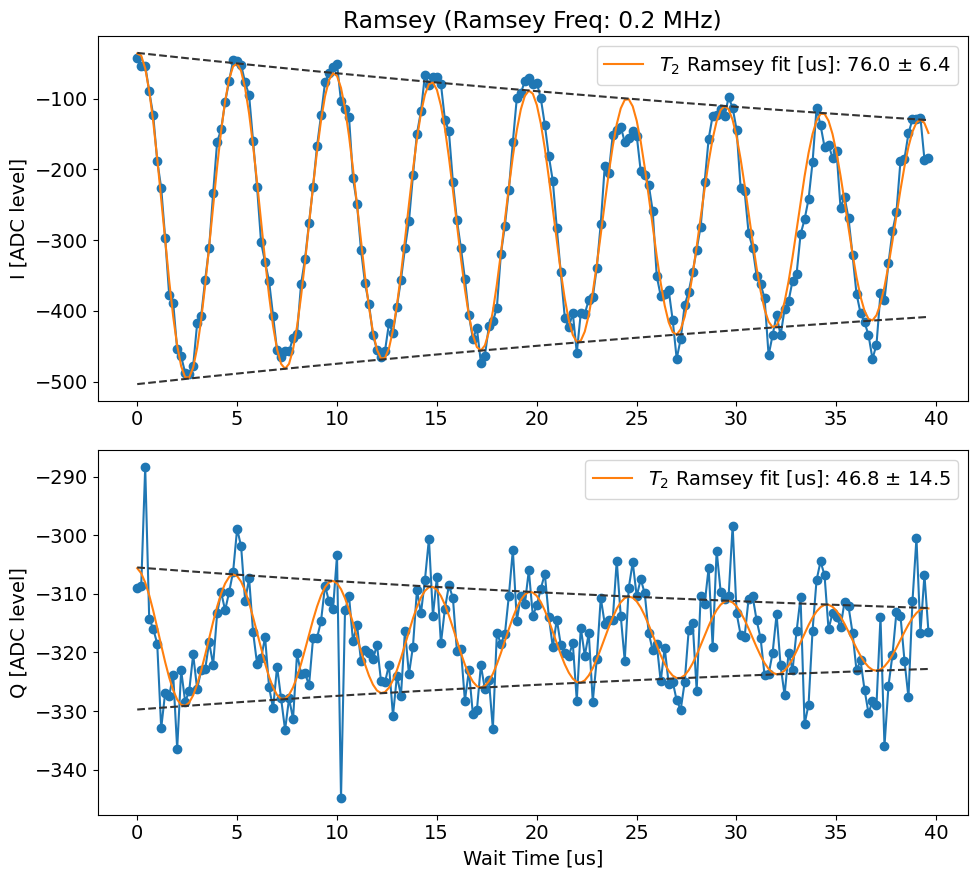

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-13_09-14-44_T2_ge.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-13.md
T2 Ramsey done!


In [30]:
t2ramsey_ge = None
if expts_to_run['t2_ge']:
    # pre_sweep_pulse = [
    #     ['qubit', 'ge', 'pi', 0],
    #     ['qubit', 'ef', 'pi', 0],
    #     ['man', 'M1', 'pi', 0],
    # ]
    pre_sweep_pulse = None
    t2ramsey_ge = do_t2_ramsey_ge(config_thisrun, expt_path, config_path, step_size=0.2, pre_sweep_pulse=pre_sweep_pulse,
                                  active_reset = False, relax_delay=2500)
    t2ramsey_ge.analyze()
    t2ramsey_ge.display(title_str='T2_ge')
    print('T2 Ramsey done!')

In [31]:
if expts_to_run['t2_ge']:
    update_t2_ramsey_ge(t2ramsey_ge, config_thisrun)
    print('T2 Ramsey updated!')

Updated qubit ge frequency to: 3567.357655163779
T2 Ramsey updated!


In [32]:
# idata = t2ramsey_ge.data['idata']
# idata = idata.reshape((len(idata)//4,4))

# qdata = t2ramsey_ge.data['qdata']
# qdata = qdata.reshape((len(qdata)//4,4))

# fig, axs = plt.subplots(nrows=4,ncols=2, figsize=(8,8))
# for kk in range(4):
#     axs[kk,0].hist(idata[:,kk], bins=100)
#     axs[kk,1].hist(qdata[:,kk], bins=100)
# None

Quick record of man-qb chi shift 

no M1 pulse, 0.2 -> 0.19858, 

prepulse ge-ef-f0g1, 0.2 -> 0.470, 0.1 -> 0.36993, 0.3 -> 0.57197122

In [33]:
# t2ramsey_ge.analyze() #fitparams=[500, 10, None, 200, None, None])
# t2ramsey_ge.display(title_str='T2_ge')

In [34]:
# config_thisrun.device.qubit.f_ge = yaml_cfg.device.qubit.f_ge

### Amplitude Rabi

We should probably use a cosine fit with fixed phase=0 instead of decaying sine with varying phase?

In [35]:
def do_amplitude_rabi(config_thisrun, expt_path, config_path, if_ef = False):
    """Run the amplitude Rabi experiment."""
    amprabi = meas.single_qubit.amplitude_rabi.AmplitudeRabiExperiment(
        soccfg=soc, path=expt_path, prefix='AmplitudeRabiExperiment', config_file=config_path
    )

    amprabi.cfg = AttrDict(deepcopy(config_thisrun))

    pulse_ge = config_thisrun.device.qubit.pulses.pi_ge

    checkEF = False
    pulse_ge_init = False
    pulse_ge_after = False
    if if_ef:
        checkEF = True
        pulse_ge_init = True
        pulse_ge_init = True

    amprabi.cfg.expt = dict(
        start=50,  # Qubit gain [dac level]
        step=160,  # [dac level]
        expts=151,
        reps=100,
        rounds=1,
        sigma_test=pulse_ge.sigma[0],  # Gaussian sigma for pulse length - overrides config [us]
        qubit=0,
        pulse_type='gauss',  # 'gauss' or 'flat_top' or 'drag' or 'const'
        drag_beta=0.0,
        pulse_ge_init=pulse_ge_init,
        pulse_ge_after=pulse_ge_init,
        checkZZ=False,
        checkEF=checkEF,
        qubits=[0],
        flat_length=0,
        normalize=False,
        single_shot=False,  # For debugging
        singleshot_reps=10000,
        span=50,  # Single shot plot span
        user_defined_freq=[False, 3568.203829046816],  # [on/off, freq]
        prepulse=False,
        postpulse=False
    )

    amprabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    amprabi.go(analyze=False, display=False, progress=True, save=True)

    from multimode_expts.fit_display_classes import AmplitudeRabiFitting
    amprabi_analysis = AmplitudeRabiFitting(
        amprabi.data, 
        readout_per_round=4, config=amprabi.cfg,
    )
    return amprabi_analysis


def update_amplitude_rabi(amprabi, config_thisrun):
    """Update the configuration based on amplitude Rabi experiment results."""
    config_thisrun.device.qubit.pulses.pi_ge.gain = [amprabi.data['pi_gain_avgi']]
    config_thisrun.device.qubit.pulses.hpi_ge.gain = [amprabi.data['hpi_gain_avgi']]
    print('Updated qubit ge pi and hpi gaussian gain!')



In [36]:
# amprabi = do_amplitude_rabi(config_thisrun, expt_path, config_path)

In [37]:
# amprabi.analyze(fitparams=[np.max(amprabi.data['amps']), 0.00001, 90, None, None, None])
# amprabi.display(title_str='Amplitude Rabi_ge', save_fig=True)
# update_amplitude_rabi(amprabi, config_thisrun)

In [38]:
amprabi = None
t2_ramsey_ge_after_amp = None
if expts_to_run['amplitude_ge']:
    amprabi = do_amplitude_rabi(config_thisrun, expt_path, config_path)
    amprabi.analyze(fitparams=[np.max(amprabi.data['amps']), 0.00001, 90, None, None, None])
    amprabi.display(title_str='Amplitude Rabi_ge', save_fig=True)
    update_amplitude_rabi(amprabi, config_thisrun)
    print('Amplitude Rabi done!')

    # After this do another round of T2 to fine tune the qubit frequency
    t2_ramsey_ge_after_amp  = do_t2_ramsey_ge(config_thisrun, expt_path, config_path)
    t2_ramsey_ge_after_amp.analyze()
    t2_ramsey_ge_after_amp.display(title_str='T2_ge_after_amp')
    update_t2_ramsey_ge(t2_ramsey_ge_after_amp , config_thisrun)
    print('T2 Ramsey done!')

In [39]:
# amprabi.analyze(fitparams= [np.max(amprabi.data['amps']), 0.00001, 90, None, None, None])
# amprabi.display()
# update_amplitude_rabi(amprabi, config_thisrun)
# print('Amplitude Rabi done!')

In [40]:
# amprabi.analyze(fitparams= [np.max(amprabi.data['amps']), 0.0001, 90, None, None, None])
# amprabi.display()
# update_amplitude_rabi(amprabi, config_thisrun)


# Magic Params: [np.max(amprabi.data['amps']), 0.00001, 90, None, None, None]

### T1

In [41]:
def do_t1_ge(config_thisrun, expt_path, config_path):
    """Run the T1 experiment."""
    t1 = meas.single_qubit.t1.T1Experiment(
        soccfg=soc, path=expt_path, prefix='T1Experiment', config_file=config_path
    )

    t1.cfg = AttrDict(deepcopy(config_thisrun))

    t1.cfg.expt = {
        'start': 0,
        'step': 10,
        'expts': 100,
        'reps': 50,
        'rounds': 1,
        'qubit': 0,
        'qubit_ef': False,
        'normalize': False
    }

    t1.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    t1.go(analyze=True, display=True, progress=True, save=True)
    return t1


def update_t1_ge(t1, config_thisrun):
    """Update the configuration based on T1 experiment results."""
    config_thisrun.device.qubit.T1 = [t1.data['fit_avgi'][3]]
    print('Updated qubit T1!')


In [42]:
t1 = None
if expts_to_run['t1_ge']:
    t1 = do_t1_ge(config_thisrun, expt_path, config_path)
    t1.analyze()
    t1.display()
    update_t1_ge(t1, config_thisrun)
    print('T1 done!')

## Qubit ef

### Pulse-probe

In [43]:
def do_pulse_probe_ef(config_thisrun): 

    qspec = meas.single_qubit.pulse_probe_ef_spectroscopy.PulseProbeEFSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeEFSpectroscopyExperiment', config_file=config_path
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = {'start': 3415,
        'step': 0.05,
        'expts': 500,
        'reps': 200,
        'rounds': 1,
        'length': 1,
        'gain': 300,
        # 'pulse_type': 'gaussian',
        'qubit_f': False,
        'qubit': 0,
        'cavity_drive': False,
        'wait_qubit': False,}



    qspec.cfg.device.readout.relax_delay = [500] # Wait time between experiments [us]
    qspec.go(analyze=True, display=True, progress=True, save=True)
    return qspec

def update_pulse_probe_ef(qspec, config_thisrun):
    config_thisrun.device.qubit.f_ef = [qspec.data['fit_avgi'][2]]
    print('Updated qubit frequency!')

In [44]:
# expts_to_run['pulse_probe_ef'] = True

In [45]:
qspec_ef = None
if expts_to_run['pulse_probe_ef']: 
    qspec_ef = do_pulse_probe_ef(config_thisrun)


In [46]:
if expts_to_run['pulse_probe_ef']:
    update_pulse_probe_ef(qspec_ef, config_thisrun)
    print('Pulse probe spectroscopy done!')

### T2 Ramsey

In [47]:
def do_t2_ramsey_ef(config_thisrun, expt_path, config_path, ef_init = True, pre_sweep_pulse = None, post_sweep_pulse = None, step_size = 0.2, 
                    active_reset = False, relax_delay = 2500):
    """Run the T2 Ramsey experiment."""
    return do_t2_ramsey_ge(config_thisrun, expt_path, config_path, pre_sweep_pulse=pre_sweep_pulse, 
                            post_sweep_pulse=post_sweep_pulse, step_size=step_size, if_ef=True, ef_init=ef_init,
                            active_reset=active_reset, relax_delay=relax_delay)
    


def update_t2_ramsey_ef(t2ramsey, config_thisrun):
    """Update the configuration based on T2 Ramsey experiment results."""
    config_thisrun.device.qubit.f_ef = [config_thisrun.device.qubit.f_ef[0] + min(t2ramsey.data['f_adjust_ramsey_avgi'])]
    print('Updated qubit ef frequency to:', config_thisrun.device.qubit.f_ef[0])



fge is  3567.357655163779
fef is  3423.998699387194


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00275_RamseyExperiment.h5
No echoes in the data
Current pi pulse frequency: 3423.998699387194
Fit frequency from I [MHz]: 0.1977047292804358 +/- 0.0003992375432408442
Suggested new pi pulse frequency from fit I [MHz]:
 	3424.0009946579135
 	3424.3964041164745
T2 Ramsey from fit I [us]: 40.070745456872444
Fit frequency from Q [MHz]: 0.1986226065934469 +/- 0.0003740185753553601
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3424.0000767806005
 	3424.3973219937875
T2 Ramsey from fit Q [us]: 39.98604650369681


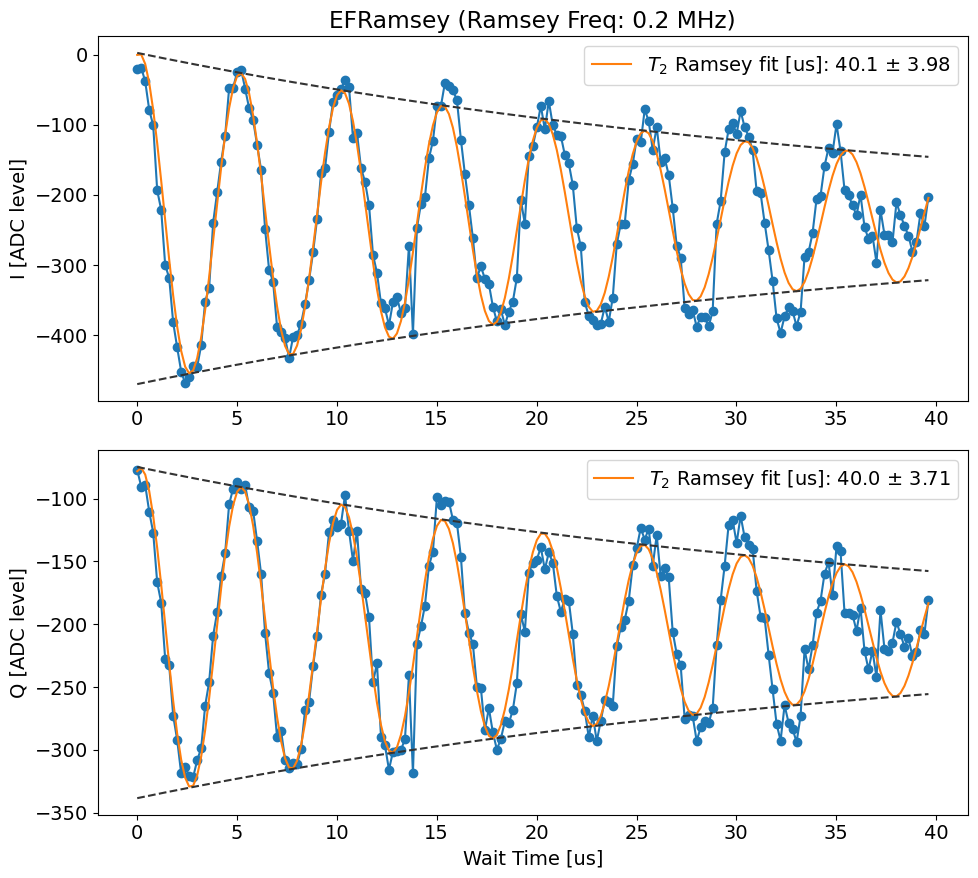

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-13_09-16-32_T2_ef.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-13.md
T2 Ramsey done!


In [48]:
t2ramsey_ef = None
if expts_to_run['t2_ef']:
    t2ramsey_ef = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
    t2ramsey_ef.analyze()
    t2ramsey_ef.display(title_str='T2_ef')
    # update_t2_ramsey_ef(t2ramsey_ef, config_thisrun)
    print('T2 Ramsey done!')

In [49]:
# t2ramsey_ef.analyze(fitparams=[100, 10, None, 20, None, None])
# t2ramsey_ef.display(title_str='T2_ef')
update_t2_ramsey_ef(t2ramsey_ef, config_thisrun)

Updated qubit ef frequency to: 3424.0009946579135


In [50]:
# config_thisrun.device.qubit.f_ef[0] =3424.0107360203015

In [51]:
# t2ramsey_ge.analyze()
# t2ramsey_ge.display()
    

### Amplitude Rabi

We should probably use a cosine fit with fixed phase=0 instead of decaying sine with varying phase?

In [52]:
def do_amplitude_rabi_ef(config_thisrun, expt_path, config_path):
    """Run the amplitude Rabi experiment."""
    return do_amplitude_rabi(config_thisrun, expt_path, config_path, if_ef=True)


def update_amplitude_rabi_ef(amprabi, config_thisrun):
    """Update the configuration based on amplitude Rabi experiment results."""
    config_thisrun.device.qubit.pulses.pi_ef.gain = [amprabi.data['pi_gain_avgi']]
    config_thisrun.device.qubit.pulses.hpi_ef.gain = [amprabi.data['hpi_gain_avgi']]
    print('Updated qubit ef pi and hpi gaussian gain!')



In [53]:
amprabi_ef = None
t2_ramsey_ef_after_amp = None
if expts_to_run['amplitude_ef']:
    amprabi_ef = do_amplitude_rabi_ef(config_thisrun, expt_path, config_path)
    amprabi_ef.analyze(fitparams=[np.max(amprabi_ef.data['amps']), 0.00001, 90, None, None, None])
    amprabi_ef.display(title_str = 'Amplitude Rabi_ef', save_fig=True)
    update_amplitude_rabi_ef(amprabi_ef, config_thisrun)
    print('Amplitude Rabi done!')

    # After this do another round of T2 to fine tune the qubit frequency
    t2_ramsey_ef_after_amp  = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
    t2_ramsey_ef_after_amp.analyze()
    t2_ramsey_ef_after_amp.display(title_str='T2_ef_after_amp')
    update_t2_ramsey_ef(t2_ramsey_ef_after_amp , config_thisrun)
    print('T2 Ramsey done!')

In [ ]:
# amprabi_ef.analyze(title_str = 'Amplitude Rabi_ef', save_fig=False, fitparams=[np.max(amprabi_ef.data['amps']), 0.0001, 90, None, None, None])
# amprabi_ef.display(title_str = 'Amplitude Rabi_ef', save_fig=False)
# Magic Params: [np.max(amprabi_ef.data['amps']), 0.00001, 90, None, None, None]

AttributeError: 'NoneType' object has no attribute 'analyze'

Updated qubit ef pi and hpi gaussian gain!
Amplitude Rabi done!
fge is  3567.3497210054506
fef is  3423.990941729815


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00245_RamseyExperiment.h5
No echoes in the data
Current pi pulse frequency: 3423.990941729815
Fit frequency from I [MHz]: 0.19936074416833224 +/- 0.00048344637679248275
Suggested new pi pulse frequency from fit I [MHz]:
 	3423.9915809856466
 	3424.3903024739834
T2 Ramsey from fit I [us]: 52.10961183863815
Fit frequency from Q [MHz]: 0.19928659227563492 +/- 0.0006076474919803433
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3423.9916551375395
 	3424.3902283220905
T2 Ramsey from fit Q [us]: 64.25868299837728


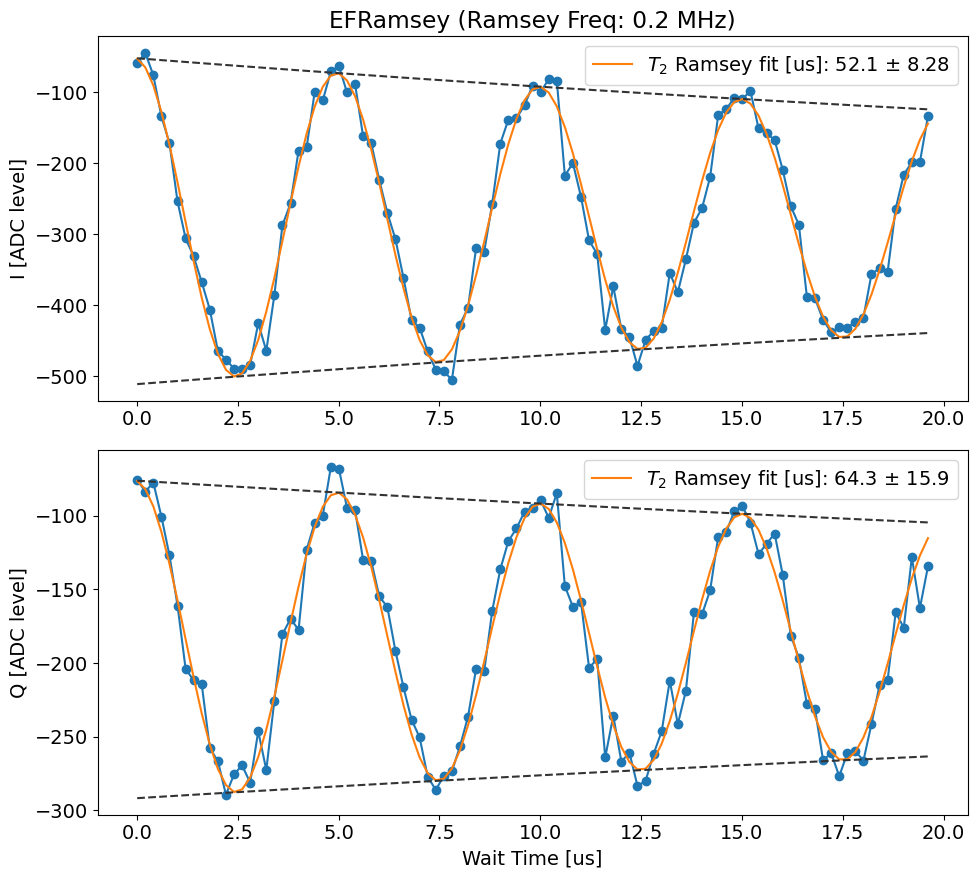

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-04_15-36-54_T2_ef_after_amp.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-04.md
Updated qubit ef frequency to: 3423.9915809856466
T2 Ramsey done!


In [ ]:
# update_amplitude_rabi_ef(amprabi_ef, config_thisrun)
# print('Amplitude Rabi done!')

# # After this do another round of T2 to fine tune the qubit frequency
# t2_ramsey_ef_after_amp  = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
# t2_ramsey_ef_after_amp.analyze()
# t2_ramsey_ef_after_amp.display(title_str='T2_ef_after_amp')
# update_t2_ramsey_ef(t2_ramsey_ef_after_amp , config_thisrun)
# print('T2 Ramsey done!')

Attempted to init fitparam 4 to -116.55440345008529, which is out of bounds 60.73323445408372 to 348.7263250437679. Instead init to 204.7297797489258
Current pi pulse frequency: 3426.3164023718723
Fit frequency from I [MHz]: 0.21882570632979814 +/- 0.0005380744558043492
Suggested new pi pulse frequency from fit I [MHz]:
 	3426.2975766655427
 	3426.735228078202
T2 Ramsey from fit I [us]: 44.81982491598512
Fit frequency from Q [MHz]: 0.21862336100212773 +/- 0.0005909327735314028
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3426.2977790108703
 	3426.7350257328744
T2 Ramsey from fit Q [us]: 36.84019802269955


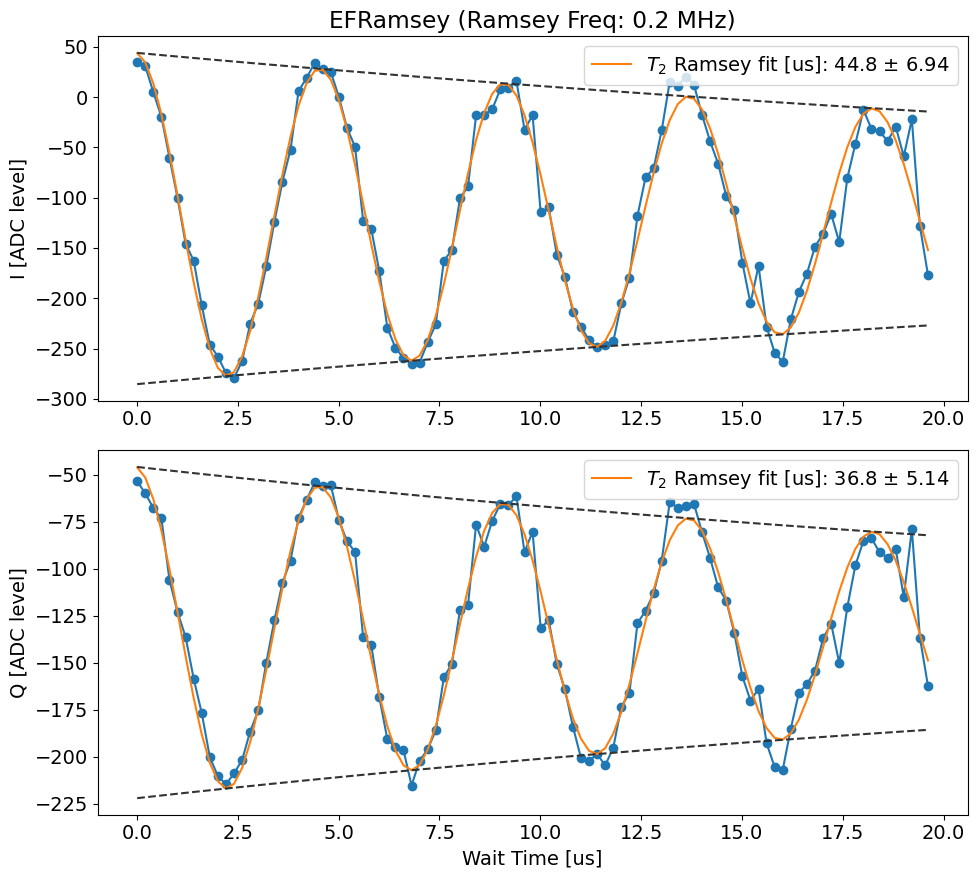

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-22_11-17-28_T2_ef_after_amp.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-22.md
Updated qubit ge frequency to: 3426.2975766655427


In [ ]:
# t2_ramsey_ef_after_amp.analyze(fitparams=[300, None, None, None, None, None])
# t2_ramsey_ef_after_amp.display(title_str='T2_ef_after_amp')
# update_t2_ramsey_ef(t2_ramsey_ef_after_amp , config_thisrun)

### T1

In [ ]:
def do_t1_ef(config_thisrun, expt_path, config_path):
    """Run the T1 experiment."""
    t1 = meas.single_qubit.t1.T1Experiment(
        soccfg=soc, path=expt_path, prefix='T1Experiment', config_file=config_path
    )

    t1.cfg = AttrDict(deepcopy(config_thisrun))

    t1.cfg.expt = {
        'start': 0,
        'step': 5,
        'expts': 100,
        'reps': 50,
        'rounds': 1,
        'qubit': 0,
        'qubit_ef': True,
        'normalize': False
    }

    t1.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    t1.go(analyze=True, display=True, progress=True, save=True)
    return t1


def update_t1_ef(t1, config_thisrun):
    """Update the configuration based on T1 experiment results."""
    config_thisrun.device.qubit.T1_ef = [t1.data['fit_avgq'][3]]
    print('Updated qubit T1!')


  0%|          | 0/5000 [00:00<?, ?it/s]

C:\_Lib\python\multimode_expts\experiments\fitting.py:55: RuntimeWarning: overflow encountered in exp
  return y0 + yscale*np.exp(-(x-x0)/decay)
C:\_Lib\python\multimode_expts\experiments\fitting.py:55: RuntimeWarning: overflow encountered in multiply
  return y0 + yscale*np.exp(-(x-x0)/decay)


Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00004_T1Experiment.h5
Fit T1 avgi [us]: 56.49548815404817
Fit T1 avgq [us]: 169.37650413956644


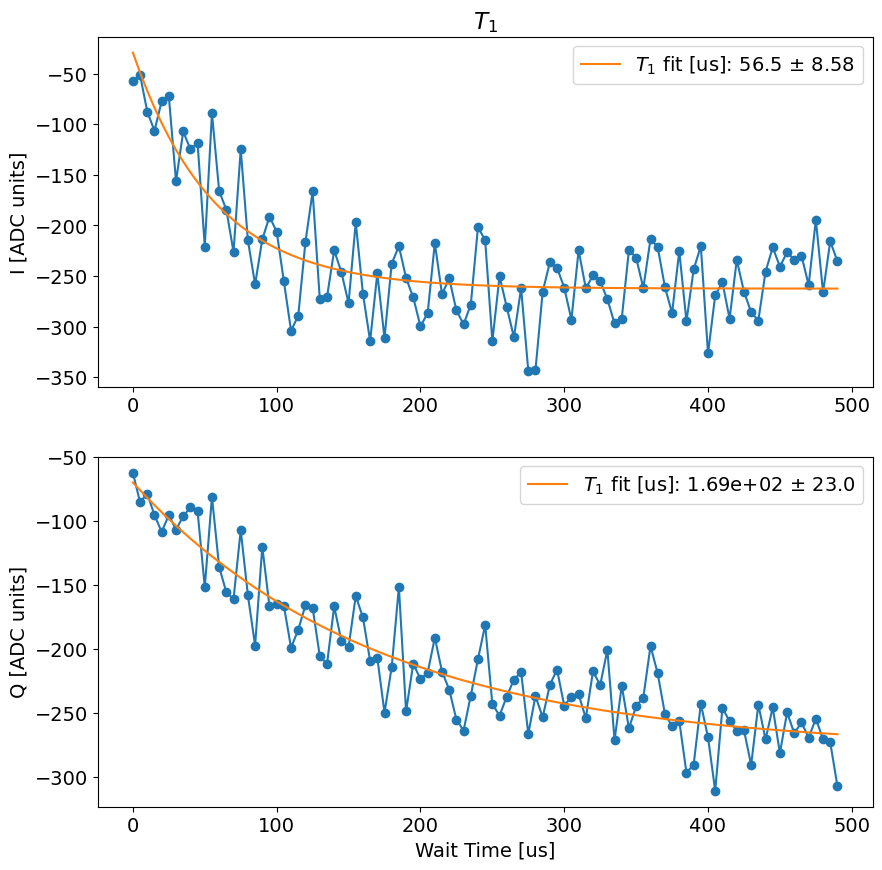

Fit T1 avgi [us]: 56.49548815404817
Fit T1 avgq [us]: 169.37650413956644


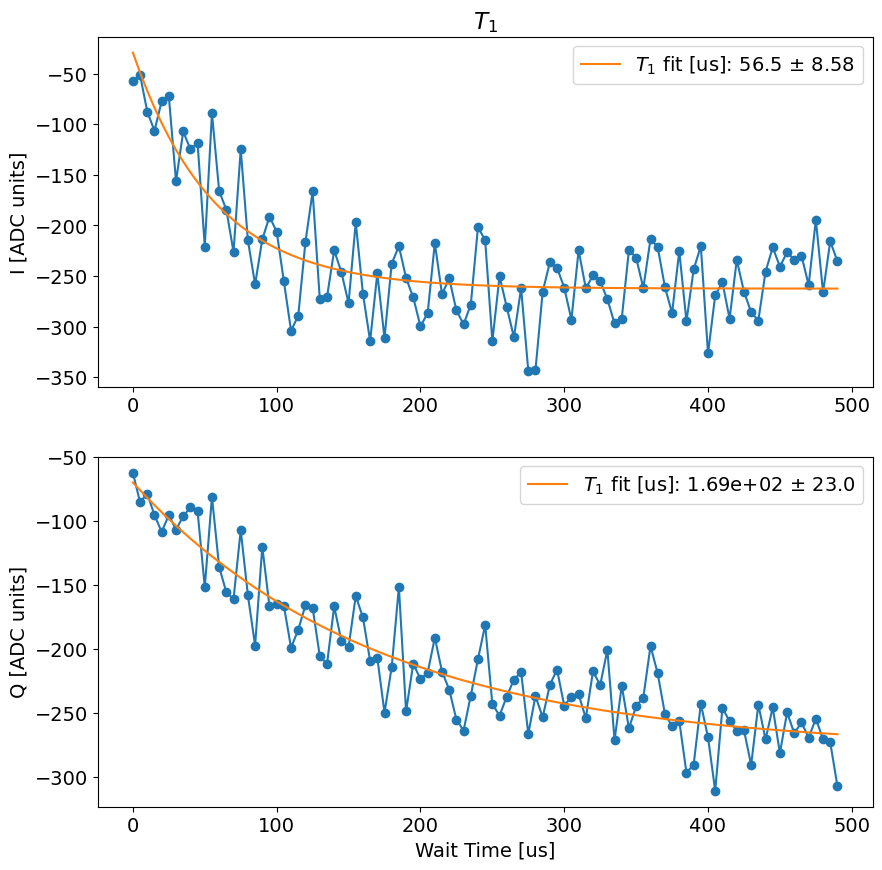

Updated qubit T1!
T1 done!


In [ ]:
t1_ef = None
if expts_to_run['t1_ef']:
    t1 = do_t1_ef(config_thisrun, expt_path, config_path)
    t1.analyze()
    t1.display()
    update_t1_ef(t1, config_thisrun)
    print('T1 done!')

# Manipulate

## Spectroscopy

In [ ]:
def do_pulse_probe_f0g1(config_thisrun, ds_thisrun, man_mode_no = 1): 

    qspec = meas.single_qubit.pulse_probe_f0g1_spectroscopy.PulseProbeF0g1SpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeF0g1SpectroscopyExperiment', config_file=config_path
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = {
        'start': ds_thisrun.get_freq('M' + str(man_mode_no)) - 5,  # resonator frequency to be mixed up [MHz]
        'step': 0.02,  # min step ~1 MHz
        'expts': 500,  # Number of experiments stepping from start
        'reps': 100,  # Number of averages per point
        'rounds': 1,  # Number of start to finish sweeps to average over
        'length': 1,  # ef probe constant pulse length [us]
        'gain': 5000,  # f0g1 pulse gain
        'pulse_type': 'gaussian',
        'qubit_f': True,
        'qubits': [0],
        'prepulse': False,
        'pre_sweep_pulse': [[3569.4827896982997], [11161], [0], [0], [2], ['g'], [0.035]]
    }

    qspec.cfg.device.readout.relax_delay = [200] # Wait time between experiments [us]
    qspec.go(analyze=False, display=False, progress=True, save=True)
    return qspec

def analyze_and_display_pulse_probe_f0g1(qspec):
    from multimode_expts.fit_display_classes import Spectroscopy
    spec_analysis = Spectroscopy(
        qspec.data)
    spec_analysis.analyze(fit=True)
    spec_analysis.display()

def update_pulse_probe_f0g1(qspec, config_thisrun, man_mode_no = 1):
    ''' 
    Update the configuration based on f0g1 spectroscopy experiment results.
    man_mode_no: 1 for man1, 2 for man2
    '''
    ds_thisrun.update_freq('M' + str(man_mode_no),  qspec.data['fit_avgi'][2])
    print('Updated man f0g1 freq to :', ds_thisrun.get_freq('M1'))


Running pulse probe f0g1 for mode 1


  0%|          | 0/50000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00050_PulseProbeF0g1SpectroscopyExperiment.h5
Found peak in amps at [MHz] 2006.143728832629, HWHM 0.43538933262624335
Found peak in I at [MHz] 2006.1412347160788, HWHM -0.42085102421211495
Found peak in Q at [MHz] 2006.1577614123978, HWHM 0.4973424936103541


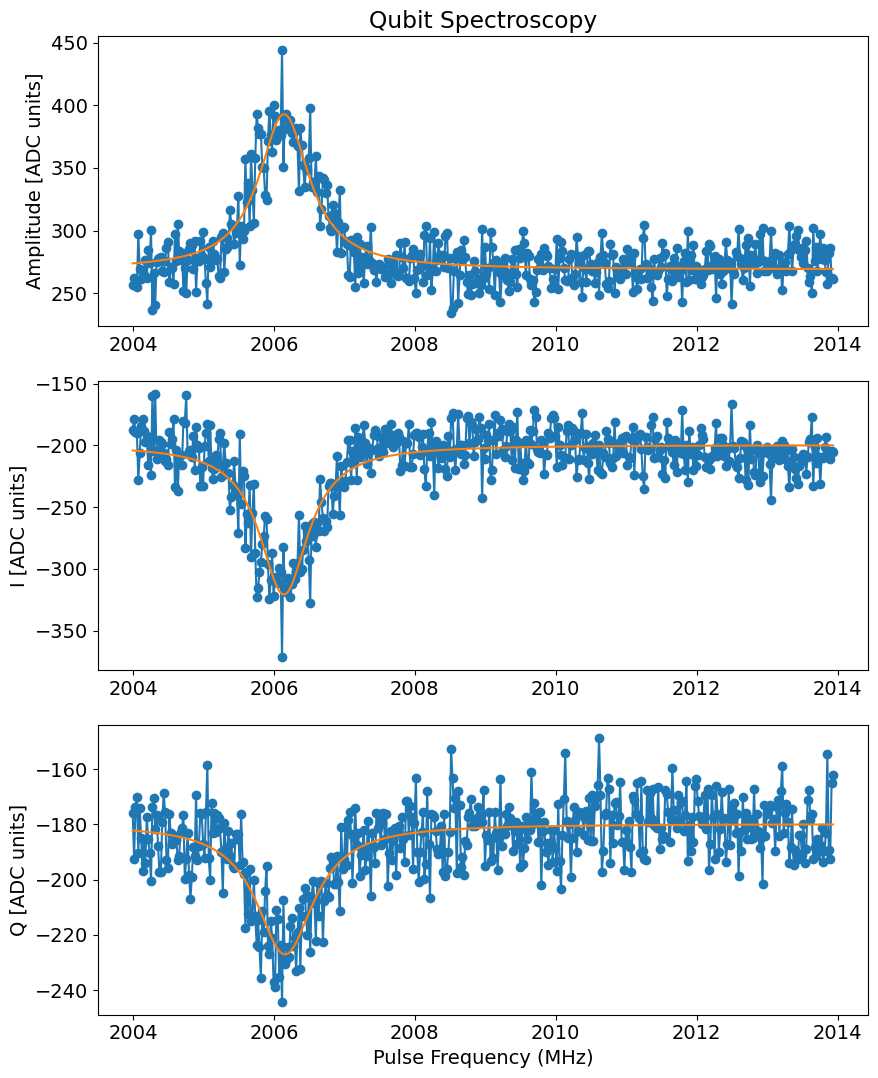

Updated man f0g1 freq to : 2006.1412347160788


In [ ]:
man_specs =[None]* len(expts_to_run['man_modes'])

for i in range(len(expts_to_run['man_modes'])):

    if expts_to_run['pulse_probe_f0g1']:

        print('Running pulse probe f0g1 for mode', i+1)
        man_specs[i] = do_pulse_probe_f0g1(config_thisrun, ds_thisrun, man_mode_no = i+1)
        analyze_and_display_pulse_probe_f0g1(man_specs[i])
        update_pulse_probe_f0g1(man_specs[i], config_thisrun, man_mode_no=i+1)
        

## Find Frequency (Chevron)


In [ ]:
%matplotlib inline

In [ ]:
def do_length_rabi_f0g1_sweep(config_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step):
    """Run the Length Rabi General F0g1 Experiment Sweep."""
    # length_rabi = meas.single_qubit.length_rabi.LengthRabiGeneralF0g1ExperimentSweep(
    #     soccfg=soc, path=expt_path, prefix='LengthRabiGeneralF0g1ExperimentSweep', config_file=config_path
    # )
    from multimode_expts.sequential_experiment_classes import man_f0g1_class
    experiment_class = man_f0g1_class
    sweep_experiment_name = 'length_rabi_f0g1_sweep'
    class_for_exp = experiment_class(soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path,
                                      exp_param_file=exp_param_file, config_thisrun=config_thisrun)

    # class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    
    class_for_exp.loaded[sweep_experiment_name] = {
        'freq_start': freq_start,
        'freq_stop':  freq_stop,
        'freq_step': freq_step,
        'start': 2,
        'step': 0.05,
        'qubits': [0],
        'expts': 101,
        'reps': 100,
        'rounds': 1,
        'gain': 15000,
        'ramp_sigma': 0.005,
        'use_arb_waveform': False,
        'pi_ge_before': True,
        'pi_ef_before': True,
        'pi_ge_after': False,
        'normalize': False,
        'active_reset': False,
        'check_man_reset': [False, 0],
        'check_man_reset_pi': [],
        'prepulse': False,
        'pre_sweep_pulse': [],
        'err_amp_reps' : 0, # Number of error amp rounds
    } # actually this doesn't do anything, edit experiment.yml
    
 
    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)

def update_length_rabi_f0g1_sweep(expt_path, prefix, config_thisrun, man_mode_no = 1):
    """Update sweep data and analyze results."""
    temp_data, attrs, filename = prev_data(expt_path, prefix=prefix)
    print('File saved at :', filename)
    from multimode_expts.fit_display_classes import ChevronFitting
    from datetime import datetime
    
    chevron_analysis = ChevronFitting(
        frequencies=temp_data['freq_sweep'],
        time=temp_data['xpts'][0],
        response_matrix=temp_data['avgi']
    )
    chevron_analysis.analyze()
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    chevron_analysis.display_results(save_fig=True, directory=autocalib_path, title=f'M{man_mode_no}_{current_time}')

    #config_thisrun.device.manipulate.f0g1_freq[0] = chevron_analysis.results['frequency']
    ds_thisrun.update_freq('M' + str(man_mode_no), chevron_analysis.results['best_frequency_contrast'])
    print('Updated the frequency to:', chevron_analysis.results['best_frequency_contrast'])
    return chevron_analysis


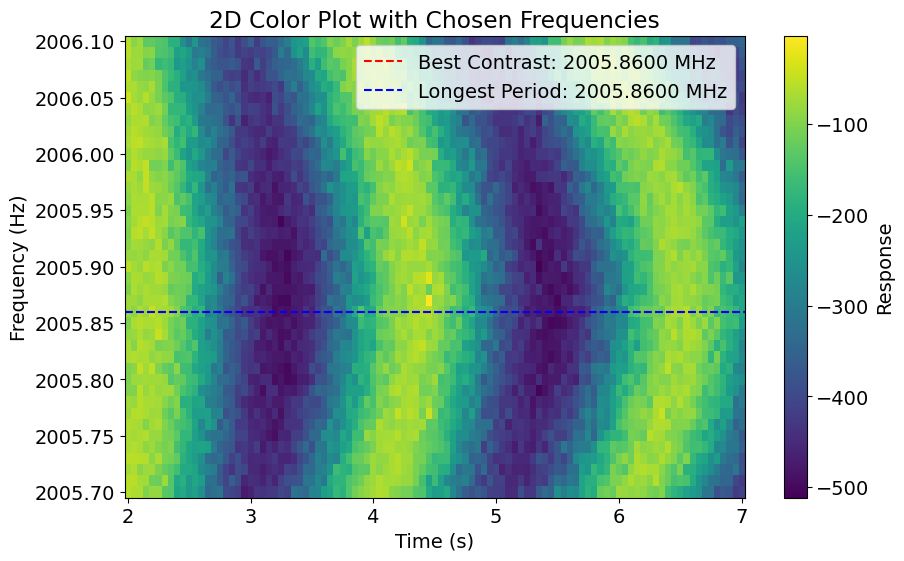

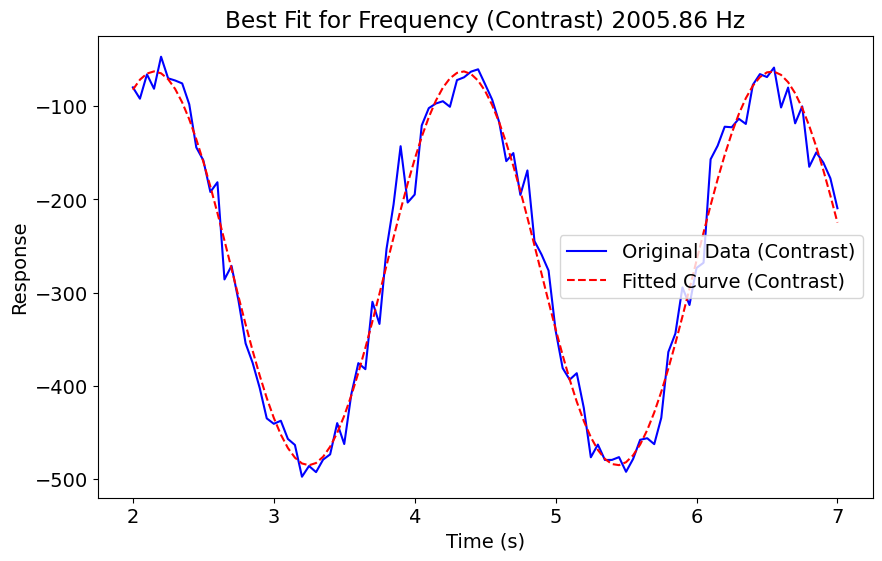

File saved at : H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00019_length_rabi_f0g1_sweep.h5
supertitle is  None
Plot saved to plots\2025-06-05_00-20-01_M1_2025-06-05_00-20-01.png


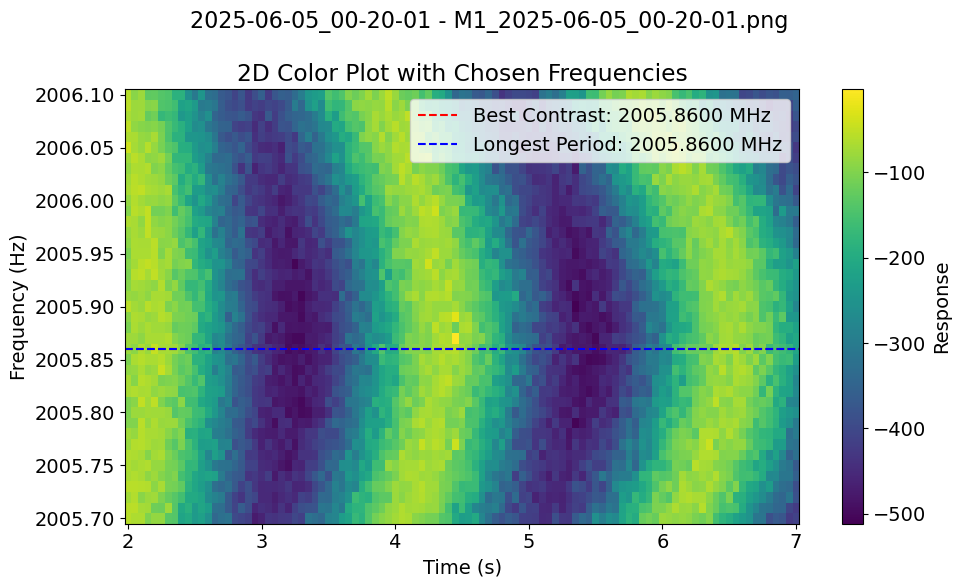

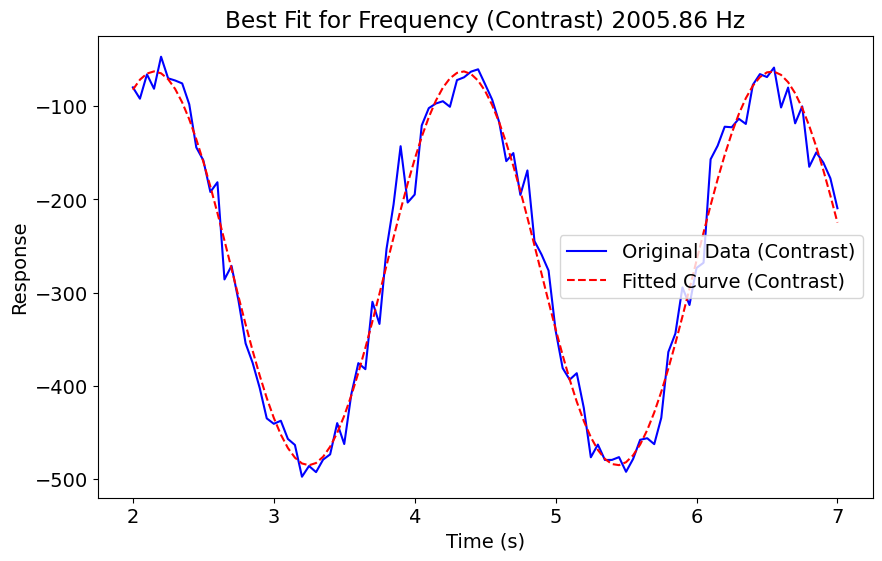

Updated the frequency to: 2005.8600000000004


In [ ]:
man_chevrons_coarse = [None] * len(expts_to_run['man_modes'])
man_chevrons_fine = [None] * len(expts_to_run['man_modes'])
# man_sweeps = [None] * len(expts_to_run['man_modes'])

for i in range(len(expts_to_run['man_modes'])):
    if expts_to_run['length_rabi_sweep']:
        print(f'Running coarse length rabi sweep for mode {i + 1}')
        freq_start = ds_thisrun.get_freq('M' + str(i + 1)) - 2
        freq_stop = ds_thisrun.get_freq('M' + str(i + 1)) + 2
        freq_step = 0.2
        man_chevrons_coarse[i] = do_length_rabi_f0g1_sweep(config_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step)
        update_length_rabi_f0g1_sweep(expt_path, 'length_rabi_f0g1_sweep', config_thisrun, man_mode_no=i + 1)

        print(f'Running fine length rabi sweep for mode {i + 1}')
        freq_start = ds_thisrun.get_freq('M' + str(i + 1)) - 0.2
        freq_stop = ds_thisrun.get_freq('M' + str(i + 1)) + 0.2
        freq_step = 0.01
        man_chevrons_fine[i] = do_length_rabi_f0g1_sweep(config_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step)
        update_length_rabi_f0g1_sweep(expt_path, 'length_rabi_f0g1_sweep', config_thisrun, man_mode_no=i + 1)

In [ ]:
ds_thisrun.update_freq('M1',  2005.9)

## Length Rabi f0g1 (Update time)

In [ ]:
def do_length_rabi_f0g1_general(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no = 1):
    """Run the Length Rabi General F0g1 Experiment."""
    length_rabi = meas.single_qubit.length_rabi_f0g1_general.LengthRabiGeneralF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='LengthRabiGeneralF0g1Experiment', config_file=config_path
    )

    length_rabi.cfg = AttrDict(deepcopy(config_thisrun))

    length_rabi.cfg.expt = dict(
        start=soc.cycles2us(3),  # Pulse start length [us]
        step=0.05,  # Pulse step length [us]
        qubits=[0],
        expts=150,
        reps=100,
        rounds=1,
        # rep_start=0, # 0 means just 1 pi pulse, no error amp
        # rep_end=19, # will do 1+2*rep_end rounds of pi pulses max
        gain=15000,  # Qubit gain [DAC units]
        freq= ds_thisrun.get_freq('M' + str(man_mode_no)),  # Frequency [MHz]
        use_arb_waveform=False,
        pi_ge_before=True,
        pi_ef_before=True,
        pi_ge_after=True,
        # pi_ef_after=True,
        normalize=False,
        active_reset=True,
        man_reset=True,
        stor_reset=True,
        check_man_reset=[False, 0],
        swap_lossy=False,
        check_man_reset_pi=[],
        prepulse=False,
        pre_sweep_pulse=[],
        err_amp_reps = 0, # Number of error amp rounds
    )

    length_rabi.cfg.device.readout.relax_delay = [20]  # Wait time between experiments [us]
    length_rabi.go(analyze=False, display=False, progress=True, save=True)

    from multimode_expts.fit_display_classes import LengthRabiFitting
    # Analyze the data
    length_rabi_analysis = LengthRabiFitting(length_rabi.data, config = length_rabi.cfg)
    length_rabi_analysis.analyze()
    length_rabi_analysis.display(title_str='Length Rabi General F0g1')


    return length_rabi_analysis


def update_length_rabi_f0g1_combined(length_rabi, config_thisrun, ds, man_mode_no = 1):
    """Update the configuration and dataset based on Length Rabi General F0g1 experiment results."""

    # Update dataset
    pi_length = length_rabi.results['pi_length']
    pi2_length = length_rabi.results['pi2_length']
    gain = length_rabi.cfg.expt['gain']
    freq = length_rabi.cfg.expt['freq']
    ds.update_all('M' + str(man_mode_no), freq, np.nan, pi_length, pi2_length, gain)
    print(f'Updated dataset: pi_length={pi_length}, pi2_length={pi2_length}, gain={gain}')



Running length rabi for mode 1


  0%|          | 0/150 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00084_LengthRabiGeneralF0g1Experiment.h5
p1: 0.40268456375838924
p2: -74.93882911645784
Pi length: 1.1377724786274175
Pi/2 length: 0.5169391452940841
p1: 0.45465285864308164
p2: -85.01368988277801
Pi length: 1.069275446797347
Pi/2 length: 0.519405375054856


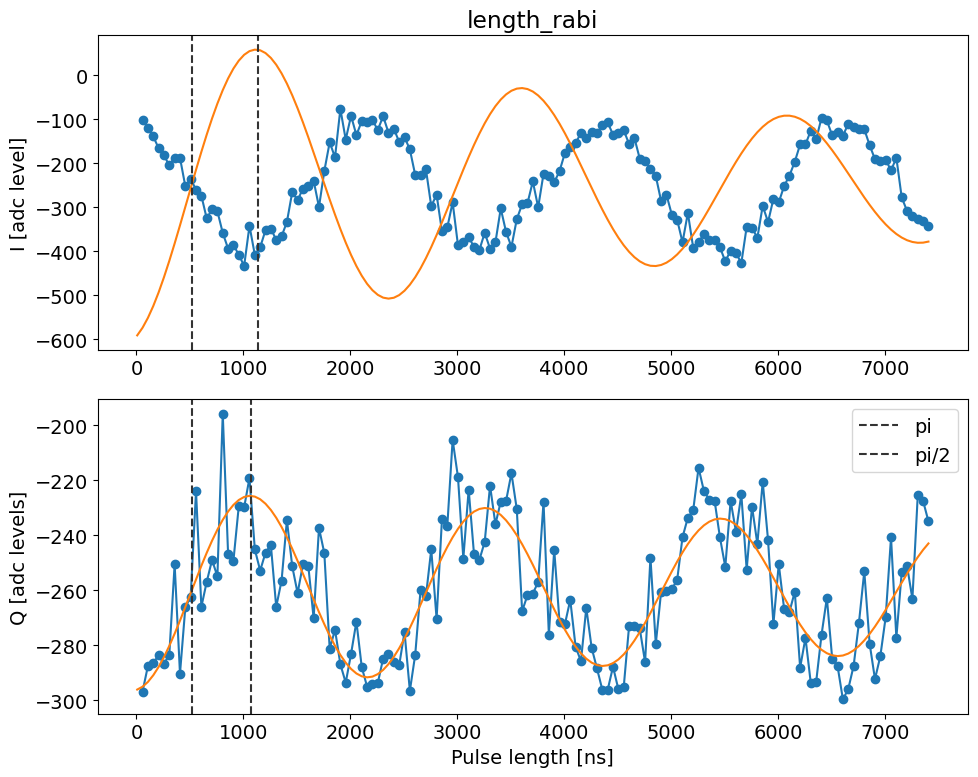

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-05_17-14-00_Length_Rabi_General_F0g1.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-05.md
Updated dataset: pi_length=1.1377724786274175, pi2_length=0.5169391452940841, gain=15000


In [ ]:
len_rabis_mans = [None]* len(expts_to_run['man_modes'])
for i in range(len(expts_to_run['man_modes'])):
    if expts_to_run['length_rabi'] or expts_to_run['length_rabi_sweep']:
        print('Running length rabi for mode', i+1)
        len_rabis_mans[i] = do_length_rabi_f0g1_general(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no= i+1)
        update_length_rabi_f0g1_combined(len_rabis_mans[i], config_thisrun, ds_thisrun, man_mode_no= i+1)
        

Attempted to init fitparam 1 to 7.651006711409396, which is out of bounds 0.013513513513513514 to 2.0270270270270268. Instead init to 1.0202702702702702
p1: 0.4530569082304463
p2: 98.15702028623045
Pi length: 1.053601880126785
Pi/2 length: 0.5017948213260436
p1: 0.9156681261408633
p2: -159.1765761380763
Pi length: 0.7559039527303822
Pi/2 length: 0.48287926959148175


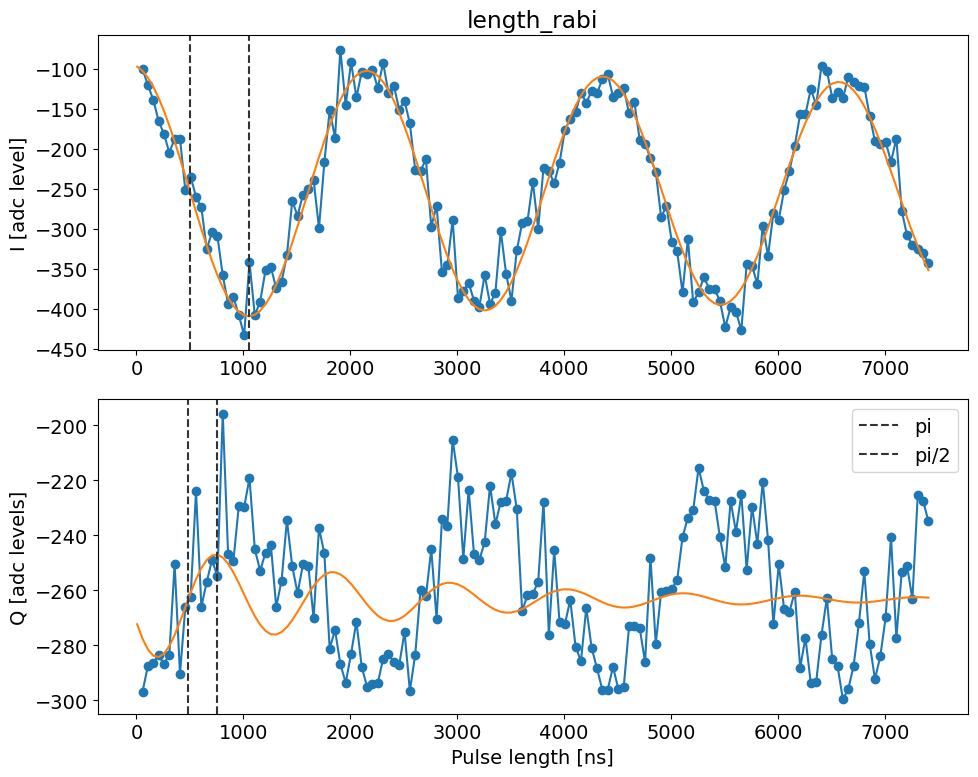

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-05_17-14-01_Length_Rabi_General_F0g1.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-05.md


In [ ]:
# len_rabis_mans[0].active_reset = True
# len_rabis_mans[0].analyze()
# len_rabis_mans[0].display(title_str='Length Rabi General F0g1')

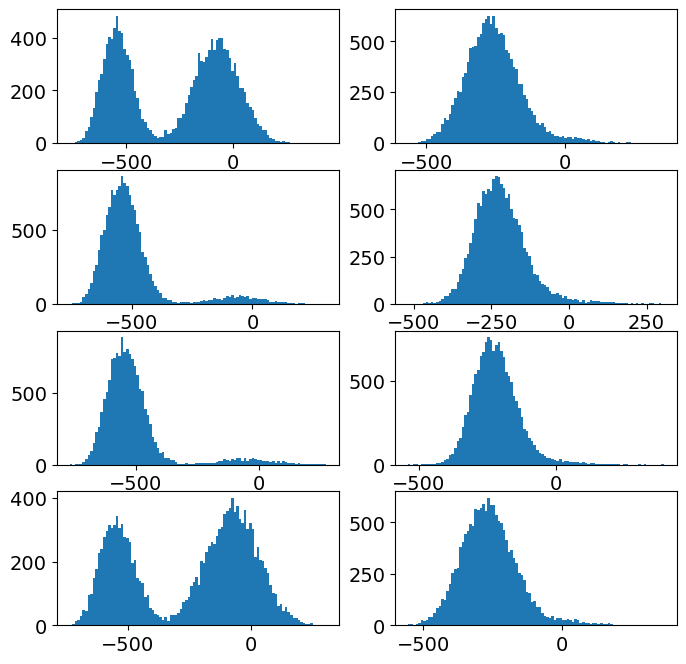

In [ ]:
# idata = len_rabis_mans[0].data['idata']
# idata = idata.reshape((len(idata.flatten())//4,4))

# qdata = len_rabis_mans[0].data['qdata']
# qdata = qdata.reshape((len(qdata.flatten())//4,4))

# fig, axs = plt.subplots(nrows=4,ncols=2, figsize=(8,8))
# for kk in range(4):
#     axs[kk,0].hist(idata[:,kk], bins=100)
#     axs[kk,1].hist(qdata[:,kk], bins=100)
# None

### Quick and dirty error amplification

Very slightly modified length rabi f0g1 general (see git)

In [ ]:
def length_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no = 1):
    """Run the Length Rabi General F0g1 repeatedly to amplify error."""

    expt_cfg = dict(
        start=ds_thisrun.get_pi('M1')-soc.cycles2us(1)*50,  # Pulse start length [us]
        step=soc.cycles2us(1),  # Pulse step length [us]
        qubits=[0],
        expts=100,
        reps=200,
        rounds=1,
        rep_start=0, # 0 means just 1 pi pulse, no error amp
        rep_end=19, # will do 1+2*rep_end rounds of pi pulses max
        gain=15000,  # Qubit gain [DAC units]
        freq= ds_thisrun.get_freq('M' + str(man_mode_no)),  # Frequency [MHz]
        use_arb_waveform=False,
        pi_ge_before=True,
        pi_ef_before=True,
        pi_ef_after=True,
        normalize=False,
        active_reset=False,
        check_man_reset=[False, 0],
        swap_lossy=False,
        check_man_reset_pi=[],
        prepulse=False,
        pre_sweep_pulse=[]
    )

    for err_amp_reps in tqdm(range(expt_cfg['rep_start'], expt_cfg['rep_end'] + 1)):
        length_rabi = meas.single_qubit.length_rabi_f0g1_general.LengthRabiGeneralF0g1Experiment(
            soccfg=soc, path=expt_path, prefix='LengthRabiGeneralF0g1Experiment', config_file=config_path
        )

        length_rabi.cfg = AttrDict(deepcopy(config_thisrun))

        expt_cfg['err_amp_reps'] = err_amp_reps

        length_rabi.cfg.expt = expt_cfg

        length_rabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
        length_rabi.go(analyze=False, display=False, progress=False, save=True)
    return length_rabi

In [ ]:
# length_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1)

  5%|▌         | 1/20 [00:56<17:57, 56.72s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00043_LengthRabiGeneralF0g1Experiment.h5


 10%|█         | 2/20 [01:53<17:01, 56.73s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00044_LengthRabiGeneralF0g1Experiment.h5


 15%|█▌        | 3/20 [02:50<16:06, 56.87s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00045_LengthRabiGeneralF0g1Experiment.h5


 20%|██        | 4/20 [03:47<15:10, 56.89s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00046_LengthRabiGeneralF0g1Experiment.h5


 25%|██▌       | 5/20 [04:44<14:14, 56.95s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00047_LengthRabiGeneralF0g1Experiment.h5


 30%|███       | 6/20 [05:41<13:19, 57.08s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00048_LengthRabiGeneralF0g1Experiment.h5


 35%|███▌      | 7/20 [06:39<12:22, 57.14s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00049_LengthRabiGeneralF0g1Experiment.h5


 40%|████      | 8/20 [07:36<11:26, 57.18s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00050_LengthRabiGeneralF0g1Experiment.h5


 45%|████▌     | 9/20 [08:33<10:29, 57.26s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00051_LengthRabiGeneralF0g1Experiment.h5


 50%|█████     | 10/20 [09:31<09:33, 57.34s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00052_LengthRabiGeneralF0g1Experiment.h5


 55%|█████▌    | 11/20 [10:28<08:36, 57.41s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00053_LengthRabiGeneralF0g1Experiment.h5


 60%|██████    | 12/20 [11:26<07:39, 57.49s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00054_LengthRabiGeneralF0g1Experiment.h5


 65%|██████▌   | 13/20 [12:24<06:42, 57.54s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00055_LengthRabiGeneralF0g1Experiment.h5


 70%|███████   | 14/20 [13:22<05:45, 57.66s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00056_LengthRabiGeneralF0g1Experiment.h5


 75%|███████▌  | 15/20 [14:20<04:49, 57.86s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00057_LengthRabiGeneralF0g1Experiment.h5


 80%|████████  | 16/20 [15:18<03:51, 57.91s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00058_LengthRabiGeneralF0g1Experiment.h5


 85%|████████▌ | 17/20 [16:16<02:53, 57.94s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00059_LengthRabiGeneralF0g1Experiment.h5


 90%|█████████ | 18/20 [17:14<01:55, 57.98s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00060_LengthRabiGeneralF0g1Experiment.h5


 95%|█████████▌| 19/20 [18:12<00:58, 58.10s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00061_LengthRabiGeneralF0g1Experiment.h5


100%|██████████| 20/20 [19:11<00:00, 57.57s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00062_LengthRabiGeneralF0g1Experiment.h5


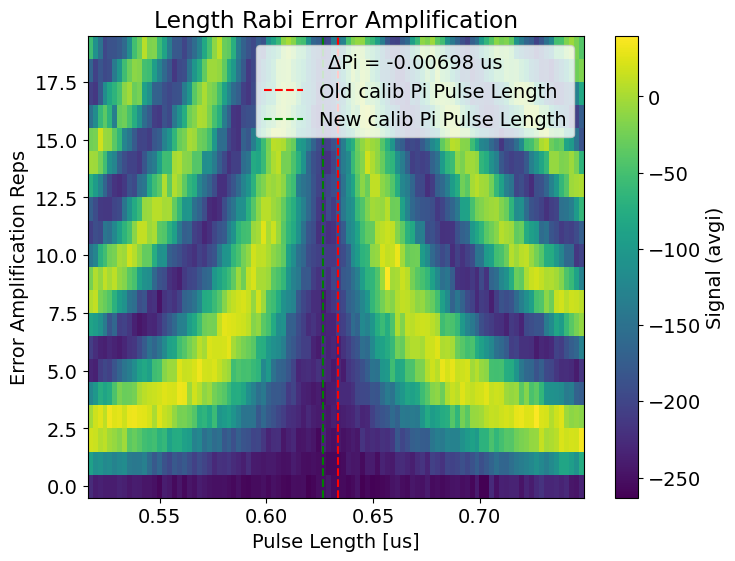

In [ ]:
# lines = []
# ypts = []
# for prefix_num in range(43,63):
#     fname = f'{prefix_num:05d}_LengthRabiGeneralF0g1Experiment.h5'
#     temp_data, attrs, filename = prev_data(expt_path, fname)
#     ypts.append(attrs['config']['expt']['err_amp_reps'])
#     lines.append(temp_data['avgi'])
    
# xpts = temp_data['xpts']
# ypts = np.array(ypts)
# lines = np.array(lines)

# import matplotlib.pyplot as plt


# plt.figure(figsize=(8, 6))
# plt.pcolormesh(xpts, ypts, lines, shading='auto', cmap='viridis')
# # add vertical line at dsthisrun.get_pi('M1')
# plt.axvline(x=ds_thisrun.get_pi('M1'), color='r', linestyle='--', label='Old calib Pi Pulse Length')

# # add vertical line where the new calib pi pulse length is
# lines_processed = np.abs(np.prod((lines-lines.mean())/(np.max(lines)-lines.mean()), axis=0))
# xmax = np.argmax(lines_processed)
                          
# plt.axvline(x=xpts[xmax], color='g', linestyle='--', label='New calib Pi Pulse Length')
# # in legend mention the difference between the two
# diff = xpts[xmax] - ds_thisrun.get_pi('M1')
# plt.legend(title=f'ΔPi = {diff:.5f} us')
# plt.xlabel('Pulse Length [us]')
# plt.ylabel('Error Amplification Reps')
# plt.title('Length Rabi Error Amplification')
# plt.colorbar(label='Signal (avgi)')
# plt.show()


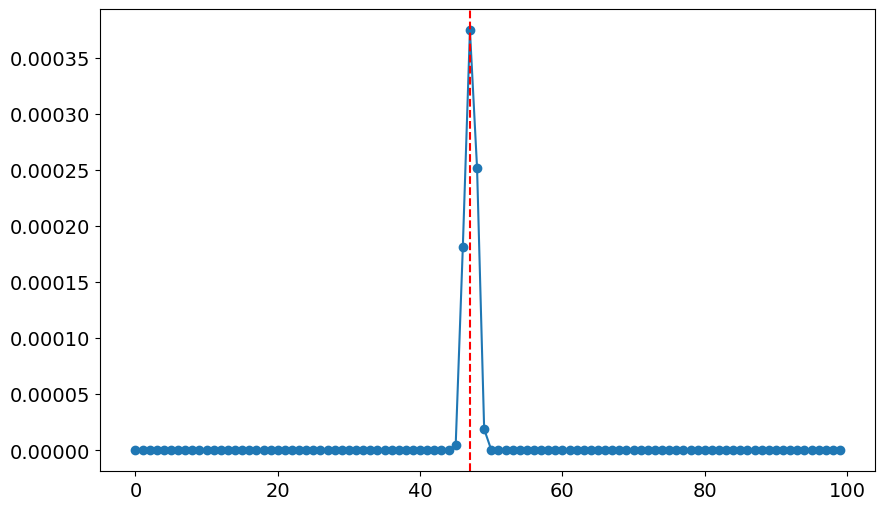

In [ ]:
# lines_processed = np.abs(np.prod((lines-lines.mean())/(np.max(lines)-lines.mean()), axis=0))
# xmax = np.argmax(lines_processed)
                          
# plt.plot(lines_processed, marker='o')
# plt.axvline(x=xmax, color='r', linestyle='--')


### and amplitude

In [ ]:
def amp_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no = 1):
    """Run the Length Rabi General F0g1 repeatedly to amplify error."""

    expt_cfg = dict(
        start=ds_thisrun.get_gain(f'M{man_mode_no}')-50*50,  # Pulse start length [dac unit]
        step=50,  # Pulse step length [dac unit]
        qubits=[0],
        expts=100,
        reps=200,
        rounds=1,
        rep_start=0,
        rep_end=19,
        # gain=15000,  # Qubit gain [DAC units]
        ramp_sigma=0.005,  # Ramp sigma [us]
        freq= ds_thisrun.get_freq('M' + str(man_mode_no)),  # Frequency [MHz]
        length= ds_thisrun.get_pi(f'M{man_mode_no}'),
        use_arb_waveform=False,
        pi_ge_before=True,
        pi_ef_before=True,
        pi_ef_after=True,
        normalize=False,
        active_reset=False,
        check_man_reset=[False, 0],
        swap_lossy=False,
        check_man_reset_pi=[],
        prepulse=False,
        pre_sweep_pulse=[]
    )

    for err_amp_reps in tqdm(range(expt_cfg['rep_start'], expt_cfg['rep_end'] + 1)):
        amp_rabi = meas.single_qubit.amplitude_rabi_f0g1_general.AmplitudeRabiGeneralF0g1Experiment(
            soccfg=soc, path=expt_path, prefix='AmplitudeRabiGeneralF0g1Experiment', config_file=config_path
        )

        amp_rabi.cfg = AttrDict(deepcopy(config_thisrun))

        expt_cfg['err_amp_reps'] = err_amp_reps

        amp_rabi.cfg.expt = expt_cfg

        amp_rabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
        amp_rabi.go(analyze=False, display=False, progress=False, save=True)
    return amp_rabi

In [ ]:
# amp_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1)
    # 

  5%|▌         | 1/20 [00:56<17:57, 56.73s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00015_AmplitudeRabiGeneralF0g1Experiment.h5


 10%|█         | 2/20 [01:53<17:01, 56.72s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00016_AmplitudeRabiGeneralF0g1Experiment.h5


 15%|█▌        | 3/20 [02:50<16:05, 56.80s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00017_AmplitudeRabiGeneralF0g1Experiment.h5


 20%|██        | 4/20 [03:47<15:09, 56.86s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00018_AmplitudeRabiGeneralF0g1Experiment.h5


 25%|██▌       | 5/20 [04:44<14:13, 56.89s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00019_AmplitudeRabiGeneralF0g1Experiment.h5


 30%|███       | 6/20 [05:41<13:17, 56.96s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00020_AmplitudeRabiGeneralF0g1Experiment.h5


 35%|███▌      | 7/20 [06:38<12:21, 57.01s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00021_AmplitudeRabiGeneralF0g1Experiment.h5


 40%|████      | 8/20 [07:35<11:25, 57.11s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00022_AmplitudeRabiGeneralF0g1Experiment.h5


 45%|████▌     | 9/20 [08:33<10:28, 57.17s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00023_AmplitudeRabiGeneralF0g1Experiment.h5


 50%|█████     | 10/20 [09:30<09:32, 57.24s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00024_AmplitudeRabiGeneralF0g1Experiment.h5


 55%|█████▌    | 11/20 [10:28<08:36, 57.36s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00025_AmplitudeRabiGeneralF0g1Experiment.h5


 60%|██████    | 12/20 [11:25<07:39, 57.38s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00026_AmplitudeRabiGeneralF0g1Experiment.h5


 65%|██████▌   | 13/20 [12:23<06:42, 57.46s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00027_AmplitudeRabiGeneralF0g1Experiment.h5


 70%|███████   | 14/20 [13:20<05:45, 57.50s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00028_AmplitudeRabiGeneralF0g1Experiment.h5


 75%|███████▌  | 15/20 [14:18<04:48, 57.66s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00029_AmplitudeRabiGeneralF0g1Experiment.h5


 80%|████████  | 16/20 [15:16<03:50, 57.72s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00030_AmplitudeRabiGeneralF0g1Experiment.h5


 85%|████████▌ | 17/20 [16:14<02:53, 57.79s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00031_AmplitudeRabiGeneralF0g1Experiment.h5


 90%|█████████ | 18/20 [17:12<01:55, 57.94s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00032_AmplitudeRabiGeneralF0g1Experiment.h5


 95%|█████████▌| 19/20 [18:11<00:58, 58.01s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00033_AmplitudeRabiGeneralF0g1Experiment.h5


100%|██████████| 20/20 [19:09<00:00, 57.46s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00034_AmplitudeRabiGeneralF0g1Experiment.h5


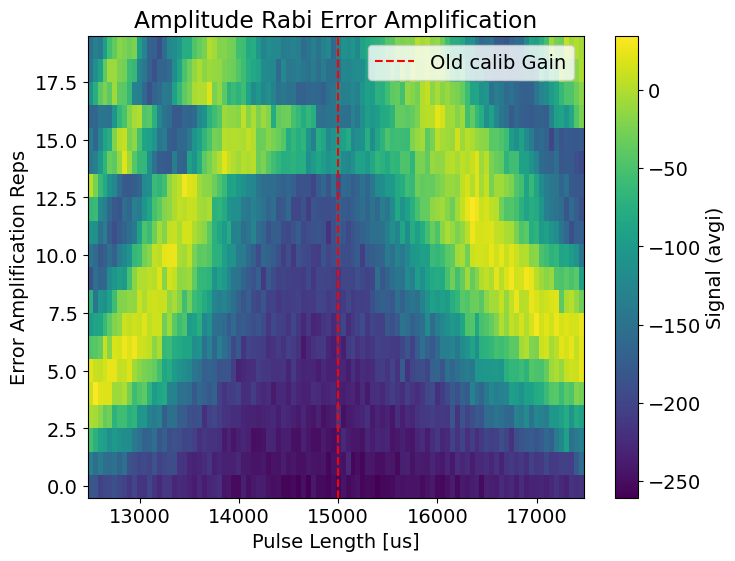

In [ ]:
# lines = []
# ypts = []
# for prefix_num in range(15,35):
#     fname = f'{prefix_num:05d}_AmplitudeRabiGeneralF0g1Experiment.h5'
#     temp_data, attrs, filename = prev_data(expt_path, fname)
#     lines.append(temp_data['avgi'])
#     ypts.append(attrs['config']['expt']['err_amp_reps'])
# xpts = temp_data['xpts']

# lines = np.array(lines)
# ypts = np.array(ypts)

# plt.figure(figsize=(8, 6))
# plt.pcolormesh(xpts, ypts, lines, shading='auto', cmap='viridis')
# plt.axvline(x=ds_thisrun.get_gain('M1'), color='r', linestyle='--', label='Old calib Gain')
# plt.xlabel('Pulse Length [us]')
# plt.ylabel('Error Amplification Reps')
# plt.title('Amplitude Rabi Error Amplification')
# plt.colorbar(label='Signal (avgi)')
# plt.legend()
# plt.show()

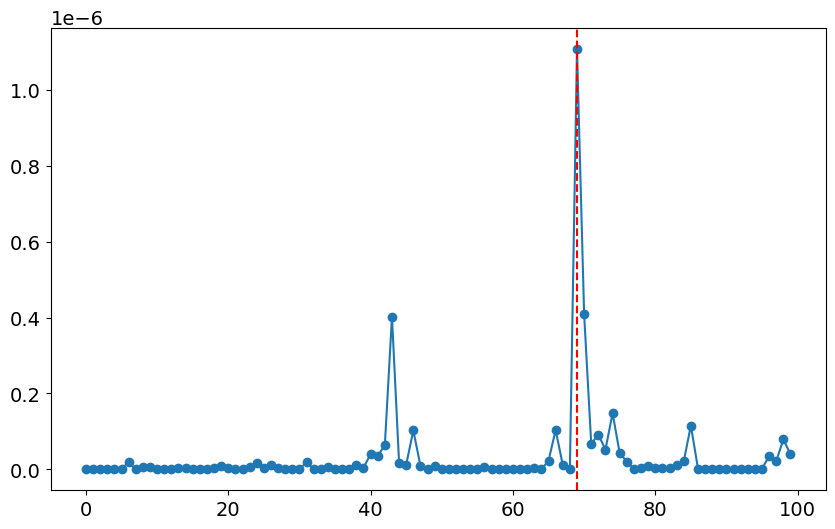

In [ ]:
# lines_processed = np.abs(np.prod((lines-lines.mean())/(np.max(lines)-lines.mean()), axis=0))
# xmax = np.argmax(lines_processed)
                          
# plt.plot(lines_processed, marker='o')
# plt.axvline(x=xmax, color='r', linestyle='--')

## Chi between qubit and Manipulate 

### ge

In [ ]:
from MM_dual_rail_base import MM_dual_rail_base
import numpy as np

# the do function contains 2 calls to ramsey, one with no prepulse and one with prepulse 
# that initializes manipulation mode to 1 state
# do_t2_ramsey_ge is already defined in previous cells and can be used directly

# Add active_reset, relax_delay, expts as arguments and pass them to do_t2_ramsey_ge
def do_chi(config_thisrun, expt_path, config_path, prepulse=None, standard_ramsey=True,
           man_mode_no=1, active_reset=False, relax_delay=2500, expts=100):
    """
    Run two Ramsey experiments: one standard, one with a prepulse that initializes manipulation mode 1.
    Returns both experiment objects.
    """
    # Standard Ramsey (no prepulse)
    if standard_ramsey:
        t2ramsey_no_prepulse = do_t2_ramsey_ge(
            config_thisrun, expt_path, config_path,
            pre_sweep_pulse=None, post_sweep_pulse=None,
            step_size=0.1,
            active_reset=active_reset,
            relax_delay=relax_delay,
            expts=expts
        )
    else: 
        t2ramsey_no_prepulse = None

    # Ramsey with prepulse (initialize manipulation mode 1)
    if prepulse is None:
        mm_base_dummy = MM_dual_rail_base(config_thisrun)
        prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
        prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()

    t2ramsey_with_prepulse = do_t2_ramsey_ge(
        config_thisrun, expt_path, config_path,
        pre_sweep_pulse=prepulse, post_sweep_pulse=None,
        step_size=0.1,
        active_reset=active_reset,
        relax_delay=relax_delay,
        expts=expts
    )

    return t2ramsey_no_prepulse, t2ramsey_with_prepulse


def update_chi(t2_ramsey_original, t2_ramsey_prepulse, config_thisrun, man_mode_no=1):
    """
    Update config_thisrun.device.qubit.chi for the given manipulation mode.
    """
    f_without_prepulse = t2_ramsey_original.data['f_adjust_ramsey_avgi'][0]
    f_with_prepulse = t2_ramsey_prepulse.data['f_adjust_ramsey_avgi'][0]
    chi = f_with_prepulse - f_without_prepulse
    print('Chi:', chi)
    config_thisrun.device.manipulate.chi_ge[man_mode_no - 1] = chi
    config_thisrun.device.manipulate.revival_time[man_mode_no-1] = np.abs(np.pi/(2 * np.pi * chi))
    print('Delay time (mus):', config_thisrun.device.manipulate.revival_time[man_mode_no-1] )


fge is  3567.3621176882566
fef is  3423.998699387194


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00272_RamseyExperiment.h5
fge is  3567.3621176882566
fef is  3423.998699387194


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00273_RamseyExperiment.h5
No echoes in the data
Attempted to init fitparam 4 to -272.448398924308, which is out of bounds -333.0054329004329 to -300.2096861471861. Instead init to -316.6075595238095
Current pi pulse frequency: 3567.3621176882566
Fit frequency from I [MHz]: 0.2003832354796225 +/- 0.0005489523763253571
Suggested new pi pulse frequency from fit I [MHz]:
 	3567.361734452777
 	3567.7625009237363
T2 Ramsey from fit I [us]: 846.7038974789516
Fit frequency from Q [MHz]: 0.20793844760635558 +/- 0.009752420675096345
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3567.3541792406504
 	3567.770056135863
T2 Ramsey from fit Q [us]: 4.223330887936933


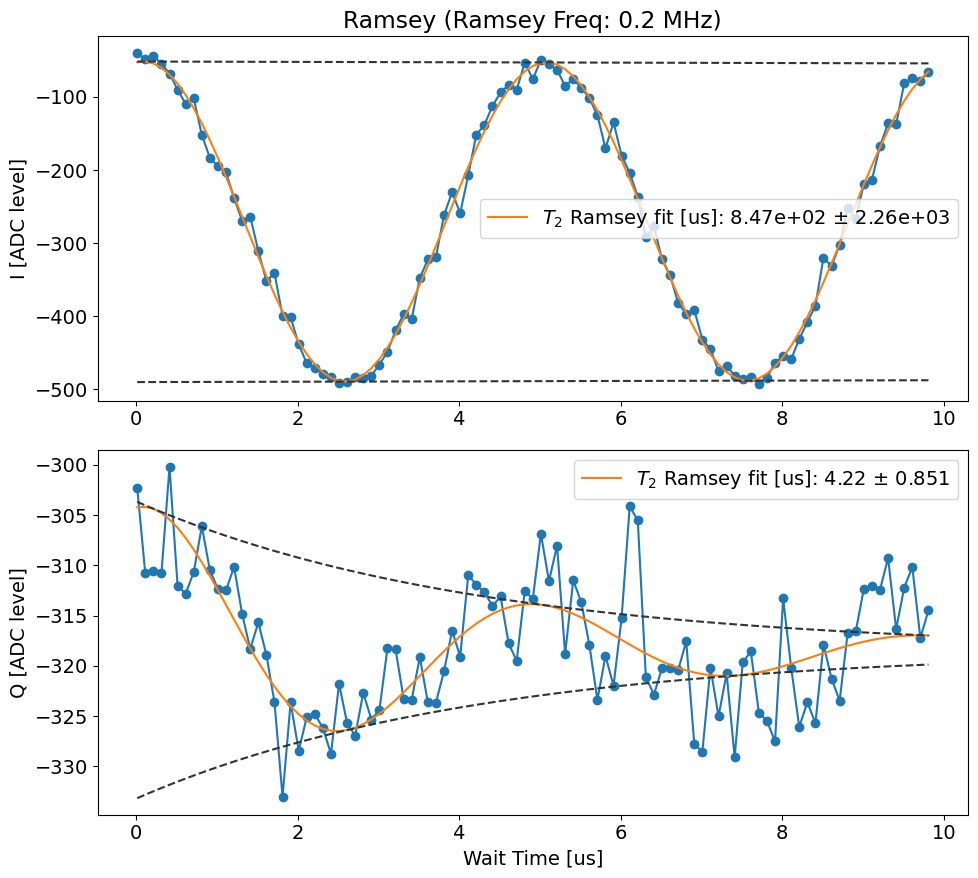

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-12_10-17-55_Ramsey.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-12.md
No echoes in the data
Attempted to init fitparam 4 to -272.8691404302768, which is out of bounds -335.3735064935065 to -294.7596536796537. Instead init to -315.0665800865801
Current pi pulse frequency: 3567.3621176882566
Fit frequency from I [MHz]: 0.471066309334267 +/- 0.000473290256464897
Suggested new pi pulse frequency from fit I [MHz]:
 	3567.091051378922
 	3568.033183997591
T2 Ramsey from fit I [us]: 92.30964409812148
Fit frequency from Q [MHz]: 0.4754956655572131 +/- 0.016842378199909185
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3567.0866220226994
 	3568.037613353814
T2 Ramsey from fit Q [us]: 3.8015360091610653


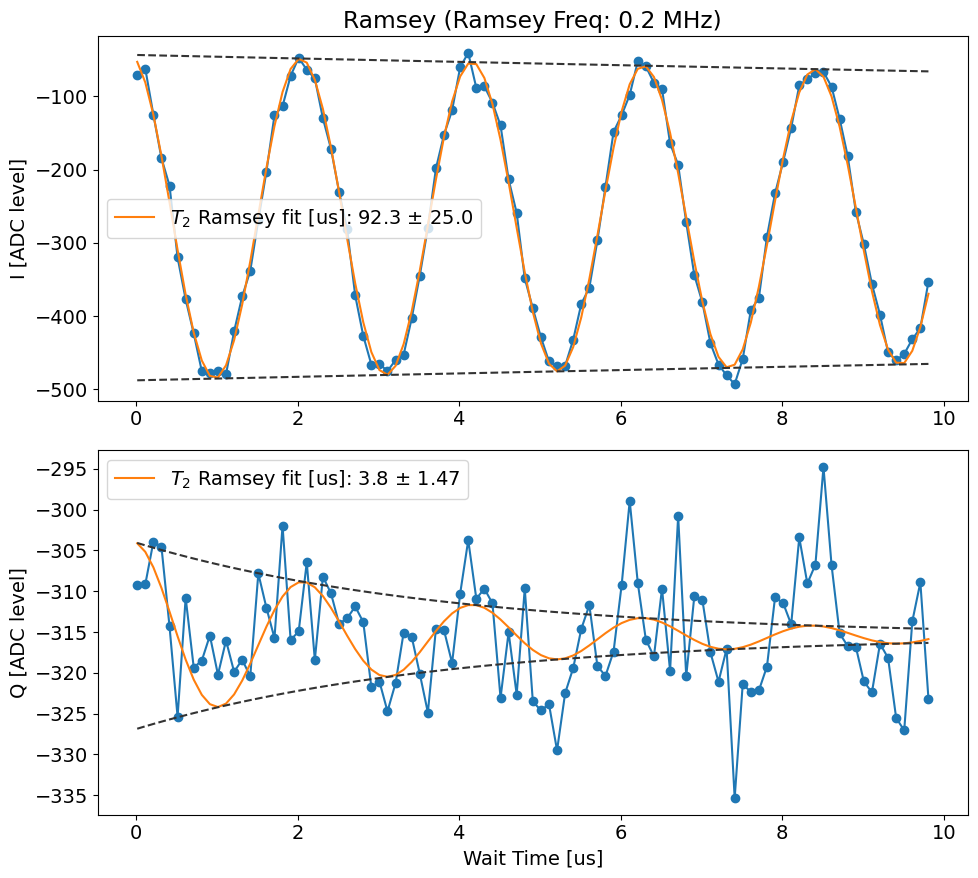

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-12_10-17-56_Ramsey.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-12.md
Chi: -0.2706830738546445
Delay time (mus): 1.8471786686909633
Only doing it for mode 1


In [ ]:

t2_ramsey_original, t2_ramsey_prepulse = None, None
# Run the chi experiments/__pycache__/
if expts_to_run['chi_ge']:
    t2_ramsey_original, t2_ramsey_prepulse = do_chi(config_thisrun, expt_path, config_path, standard_ramsey=True)
    # analyze and display the results
    t2_ramsey_original.analyze(fitparams=[300, None, None, None, None, None])
    t2_ramsey_original.display()
    t2_ramsey_prepulse.analyze(fitparams=[300, None, None, None, None, None])
    t2_ramsey_prepulse.display() 
    # update the config_thisrun with the chi value
    update_chi(t2_ramsey_original, t2_ramsey_prepulse, config_thisrun, man_mode_no=1)
    print('Only doing it for mode 1')

In [ ]:
# config_thisrun.device.manipulate.revival_time[0] = np.pi/(2 * np.pi * config_thisrun.device.manipulate.chi[0])

### ef

In [ ]:
from MM_dual_rail_base import MM_dual_rail_base

# the do function contains 2 calls to ramsey, one with no prepulse and one with prepulse 
# that initializes manipulation mode to 1 state
def do_chi_f(config_thisrun, expt_path, config_path, 
           man_mode_no=1):
    """
    Run two Ramsey experiments: one standard, one with a prepulse that initializes manipulation mode 1.
    Returns both experiment objects.
    """

    
    mm_base_dummy = MM_dual_rail_base(config_thisrun)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    # Add qubit ge prepulse and postpulse for ef (ge init)
    qubit_ge_prepulse = [['qubit', 'ge', 'pi', 0]]
    prep_man_pi_prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    prepulse =  mm_base_dummy.get_prepulse_creator(prep_man_pi + qubit_ge_prepulse ).pulse.tolist() 
    postpulse  = mm_base_dummy.get_prepulse_creator(qubit_ge_prepulse).pulse.tolist()

    # Add chi to frequency of qubit ge 
    # prepulse[0][-1] += config_thisrun.device.manipulate.chi[man_mode_no - 1]
    # postpulse[0][-1] += config_thisrun.device.manipulate.chi[man_mode_no - 1]

    # Do an ef and ge ramsey with this prepulse 
    # Run ge Ramsey 
    
    
    t2ramsey_no_prepulse_ge = do_t2_ramsey_ge(config_thisrun,
        expt_path,
        config_path,
        step_size=0.1,
        pre_sweep_pulse=prep_man_pi_prepulse,
        post_sweep_pulse=None)
    # Run ef Ramsey with prepulse and postpulse
    t2ramsey_with_prepulse_ef = do_t2_ramsey_ef(
        config_thisrun,
        expt_path,
        config_path,
        pre_sweep_pulse=prepulse,
        post_sweep_pulse=postpulse,
        step_size=0.1,
        ef_init=False  # Do not initialize ef, we are already in ef state
    )
    

    return t2ramsey_no_prepulse_ge, t2ramsey_with_prepulse_ef

def update_chi_ef(t2_standard_ramsey, t2_prepulsed_ramsey, config_thisrun, man_mode_no=1):
    """
    Update config_thisrun.device.qubit.chi for the given manipulation mode.
    """
    f_with_prepulse = t2_prepulsed_ramsey.data['f_adjust_ramsey_avgi'][0]
    f_without_prepulse = t2_standard_ramsey.data['f_adjust_ramsey_avgi'][0]
    chi_ef = f_with_prepulse - f_without_prepulse
    print('Chi:', chi_ef)
    config_thisrun.device.manipulate.chi_ef[man_mode_no - 1] = chi_ef


In [ ]:
man_mode_no = 1
t2ge_ramsey_forchief, t2ef_ramsey_forchief = None, None
t2ef_standard_ramsey_forchief = None
if expts_to_run['chi_ef']:
    
    #get standard ef ramsey 
    t2ef_standard_ramsey_forchief = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
    # analyze and display the results
    t2ef_standard_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
    t2ef_standard_ramsey_forchief.display(title_str='T2_ef_standard_for_chief')

    # Now ramseys with man photon prepulse
    config_thisrun_chief = deepcopy(config_thisrun)
    config_thisrun_chief.device.qubit.f_ge[0] += config_thisrun.device.manipulate.chi_ge[man_mode_no - 1]
    t2ge_ramsey_forchief, t2ef_ramsey_forchief = do_chi_f(config_thisrun_chief, expt_path, config_path)
    # analyze and display the results
    t2ge_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
    t2ge_ramsey_forchief.display(title_str='T2_ge_for_chief_tocheck_this_is_correctly_at_ramsey_freq')
    t2ef_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
    t2ef_ramsey_forchief.display(title_str='T2_ef_for_chief')
    # update the config_thisrun with the chi value
    update_chi_ef(t2ef_standard_ramsey_forchief, t2ef_ramsey_forchief, config_thisrun)


In [ ]:
# update_chi_ef(t2ef_standard_ramsey_forchief, t2ef_ramsey_forchief, config_thisrun)

In [ ]:
# t2ge_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
# t2ge_ramsey_forchief.display(title_str='T2_ef_ramsey_forchief')

Attempted to init fitparam 4 to -117.4212093335957, which is out of bounds 57.88465010748641 to 337.4661756256318. Instead init to 197.6754128665591
Current pi pulse frequency: 3426.287416084909
Fit frequency from I [MHz]: 0.4416697734129779 +/- 0.0010226455923950694
Suggested new pi pulse frequency from fit I [MHz]:
 	3426.0457463114963
 	3426.929085858322
T2 Ramsey from fit I [us]: 50.898566061848925
Fit frequency from Q [MHz]: 0.4413191695544237 +/- 0.0014350706333218263
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3426.0460969153546
 	3426.9287352544634
T2 Ramsey from fit Q [us]: 19.14881222091236


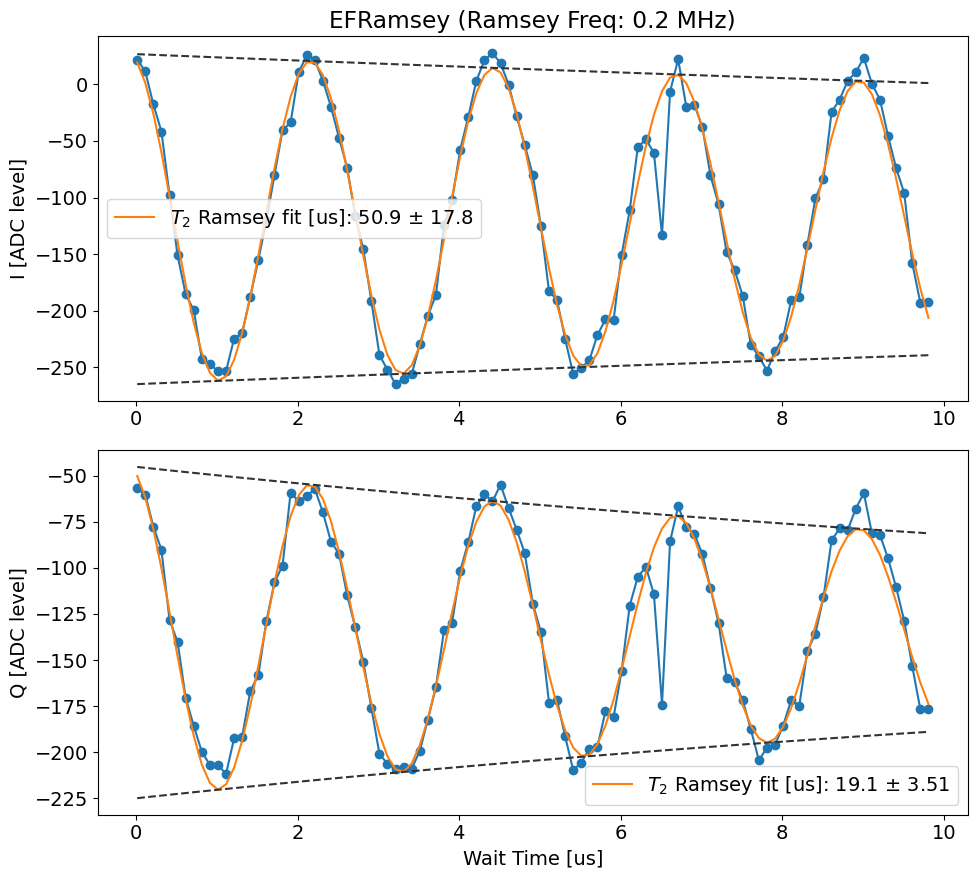

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-25_11-26-41_T2_ef_ramsey_forchief.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-25.md


In [ ]:
# t2ef_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
# t2ef_ramsey_forchief.display(title_str='T2_ef_ramsey_forchief')

In [ ]:
# t2ge_ramsey_forchief.analyze()
# t2ge_ramsey_forchief.display(title_str='T2_ge_ramsey_forchief')

## Parity Delay
NOT Implemented yet: We can use chi to estimate parity waiting time pi/chi but can also fine tune it using this experiment

Basically Length rabi analysis 

## T1

In [ ]:


def do_t1_manipulate(config_thisrun, expt_path, config_path, man_mode_no=1):
    """
    Run T1 experiment for the specified manipulate mode (man_mode_no).
    """
    t1_man = meas.single_qubit.t1_cavity.T1CavityExperiment(
        soccfg=soc, path=expt_path, prefix='T1CavityExperiment', config_file=config_path
    )

    t1_man.cfg = AttrDict(deepcopy(config_thisrun))

    # Set experiment parameters for the specified manipulate mode
    t1_man.cfg.expt = dict(
        start=0,
        step=15,
        expts=60,
        reps=300,
        rounds=1,
        cavity_prepulse=[False, 300, 1.5],
        f0g1_prep=True,
        f0g1_param=[ds_thisrun.get_freq(f'M{man_mode_no}'), ds_thisrun.get_gain(f'M{man_mode_no}'), ds_thisrun.get_pi(f'M{man_mode_no}')],
        resolved_pi=False,
        cavity=man_mode_no,
        qubit=0,
        normalize=False
    )

    t1_man.cfg.device.readout.relax_delay = [2500]
    t1_man.go(analyze=True, display=True, progress=True, save=True)
    return t1_man



  0%|          | 0/18000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00000_T1CavityExperiment.h5
Fit T1 avgi [us]: 245.73319298547162
Fit T1 avgq [us]: 239.08476736949262


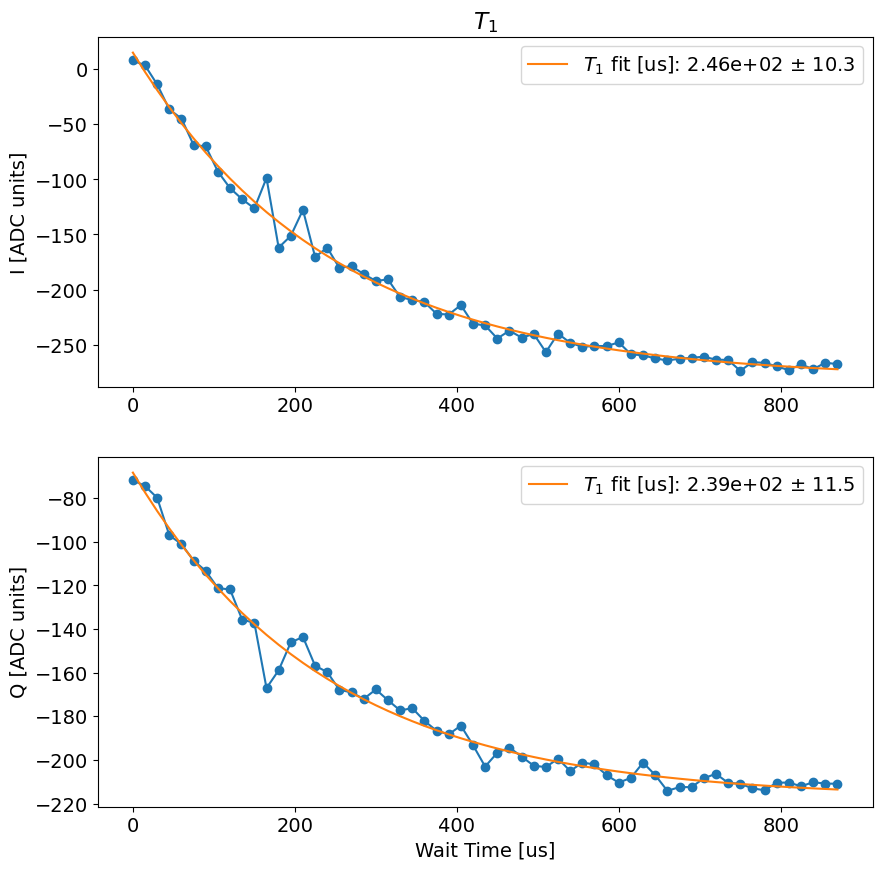

In [ ]:
# t1_man = do_t1_manipulate(config_thisrun, expt_path, config_path, 1)

## T2

In [ ]:
def do_cavity_ramsey(config_thisrun, expt_path, config_path, man_mode_no=1):
    """
    Run the Cavity Ramsey experiment using the specified configuration.
    """
    cavity_ramsey = meas.single_qubit.t2_cavity.CavityRamseyExperiment(
        soccfg=soc, path=expt_path, prefix='CavityRamseyExperiment', config_file=config_path
    )

    cavity_ramsey.cfg = AttrDict(deepcopy(config_thisrun))

    # Prepulse and postpulse

    # Set experiment parameters as in the YAML block above
    cavity_ramsey.cfg.expt = dict(
        start=0.01,
        step=0.05,
        expts=100,
        ramsey_freq=3.7,
        reps=50,
        rounds=1,
        qubits=[0],
        checkEF=False,
        f0g1_cavity=0,
        init_gf=False,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        user_defined_pulse=[True, ds_thisrun.get_freq(stor_name='M'+ str(man_mode_no)), 
                            ds_thisrun.get_gain(stor_name='M'+ str(man_mode_no)), 0.005, 
                            ds_thisrun.get_pi(stor_name='M'+ str(man_mode_no)), 0],
        parity_meas=False,
        man_idx=1,
        storage_ramsey=[False, 2, True],
        man_ramsey=[False, man_mode_no],
        coupler_ramsey=False,
        custom_coupler_pulse=[[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]],
        echoes=[False, 0],
        prepulse=True,
        postpulse=True,
        gate_based = True,
        pre_sweep_pulse= [['qubit', 'ge', 'hpi', 0], ['qubit', 'ef', 'pi', 0]],
        post_sweep_pulse=[['qubit', 'ef', 'pi', 0], ['qubit', 'ge', 'hpi', 0]]
    )

    cavity_ramsey.cfg.device.readout.relax_delay = [2500]
    cavity_ramsey.go(analyze=False, display=False, progress=True, save=True)
    return cavity_ramsey

# cavity_ramsey = do_cavity_ramsey(config_thisrun, expt_path, config_path, man_mode_no=1)

Running f0g1 ramsey
phase update channel: [0]
phase step deg: 66.60000000000001
phase step logic: +
inide t2 cavity acquire
100


  0%|          | 0/5000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00008_CavityRamseyExperiment.h5


Attempted to init fitparam 1 to 6.8686868686868685, which is out of bounds 0.02040816326530612 to 3.061224489795918. Instead init to 1.540816326530612
Current pi pulse frequency: 3569.462965491148
Fit frequency from I [MHz]: 3.060276703771371 +/- 0.05821304578443343
Suggested new pi pulse frequency from fit I [MHz]:
 	3570.102688787377
 	3576.2232421949197
T2 Ramsey from fit I [us]: 2.6830715424324296
Fit frequency from Q [MHz]: 0.9785645272761624 +/- 0.06768238650507281
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3572.184400963872
 	3574.1415300184244
T2 Ramsey from fit Q [us]: 2.8151631256662872


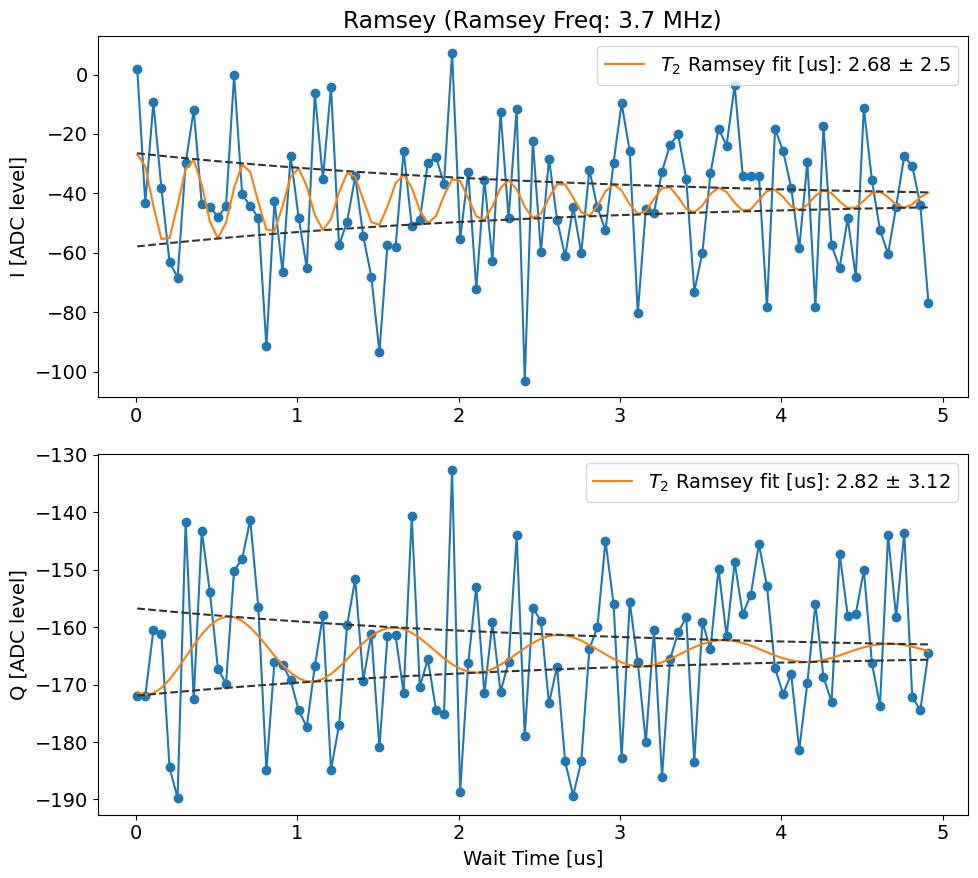

In [ ]:
# cavity_ramsey.analyze()
# cavity_ramsey.display()

# Storage

## Stor Spectroscopy

In [ ]:
def get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no):
    """
    Get pulse parameters for a given storage mode. 
    Also returns prepulse and postpulse (single photon prep and meas for ge meas)

    Args:
        ds_thisrun: Dataset object for managing frequency data.
        config_thisrun: Configuration dictionary for the current run.
        man_mode_no: Manipulation mode number.
        stor_mode_no: Storage mode number.

    Returns:
        A tuple containing freq, gain, ch, prepulse, and postpulse.
    """
    freq = ds_thisrun.get_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    gain = ds_thisrun.get_gain('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    ch = 'low' if freq < 1000 else 'high'

    from MM_dual_rail_base import MM_dual_rail_base
    mm_base_dummy = MM_dual_rail_base(config_thisrun)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist() # for ge meas, only do f0g1 and ef pi

    return freq, gain, ch, prepulse, postpulse


def do_stor_spectroscopy(config_thisrun, ds_thisrun,  expt_path, config_path, man_mode_no = 1, stor_no = 1):
    """
    Run the Flux Spectroscopy F0g1 Experiment.

    This function performs a flux spectroscopy experiment to measure the transition frequency
    between the f0 and g1 states of a qubit. It configures the experiment parameters, executes
    the experiment, and saves the results.

    Args:
        config_thisrun (AttrDict): Configuration dictionary for the current run.
        ds_thisrun (dataset.storage_man_swap_dataset): Dataset object for managing frequency data.
        expt_path (str): Path to save the experiment results.
        config_path (str): Path to the configuration file.
        man_mode_no (int, optional): Manipulation mode number (default is 1).
        stor_no (int, optional): Storage mode number (default is 1).

    Returns:
        FluxSpectroscopyF0g1Experiment: The experiment object containing the results.
    """
    flux_spec = meas.single_qubit.rf_flux_spectroscopy_f0g1.FluxSpectroscopyF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='FluxSpectroscopyF0g1Experiment', config_file=config_path
    )

    flux_spec.cfg = AttrDict(deepcopy(config_thisrun))

    freq, gain,ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun,
                                                                      man_mode_no, stor_no)

    flux_spec.cfg.expt = dict(
        start=freq - 15,  # Start RF frequency [MHz]
        step=0.15,  # Step size [MHz]
        expts=200,  # Number of experiments
        reps=100,  # Number of averages per point
        qubit=[0],
        flux_drive=[ch, 1,5000, 1],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        prepulse=True,
        postpulse=True,
        active_reset=False,
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )

    flux_spec.cfg.device.readout.relax_delay = [500]  # Wait time between experiments [us]
    flux_spec.go(analyze=False, display=False, progress=True, save=True)
    return flux_spec



def analyze_and_display_stor_spectroscopy(flux_spec):
    """Analyze and display results of Flux Spectroscopy F0g1 Experiment."""
    from multimode_expts.fit_display_classes import Spectroscopy
    spec_analysis = Spectroscopy(flux_spec.data)
    spec_analysis.analyze(fit=True)
    spec_analysis.display()


def update_stor_spectroscopy(flux_spec, ds_thisrun, man_mode_no = 1, stor_no = 1):
    """Update the configuration based on Flux Spectroscopy F0g1 experiment results."""
    # Update the dataset with the new frequency
    ds_thisrun.update_freq('M' + str(man_mode_no) + '-S' + str(stor_no), flux_spec.data['fit_avgi'][2])
    print(f"Updated frequency for M{man_mode_no}-S{stor_no}: {flux_spec.data['fit_avgi'][2]}")


Running flux spectroscopy f0g1 for mode 1


  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00033_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 348.5132118561606, HWHM 2.5322320335163577
Found peak in I at [MHz] 348.46781508935277, HWHM 2.6551202089844783
Found peak in Q at [MHz] 352.397911893738, HWHM -0.3414562782280974


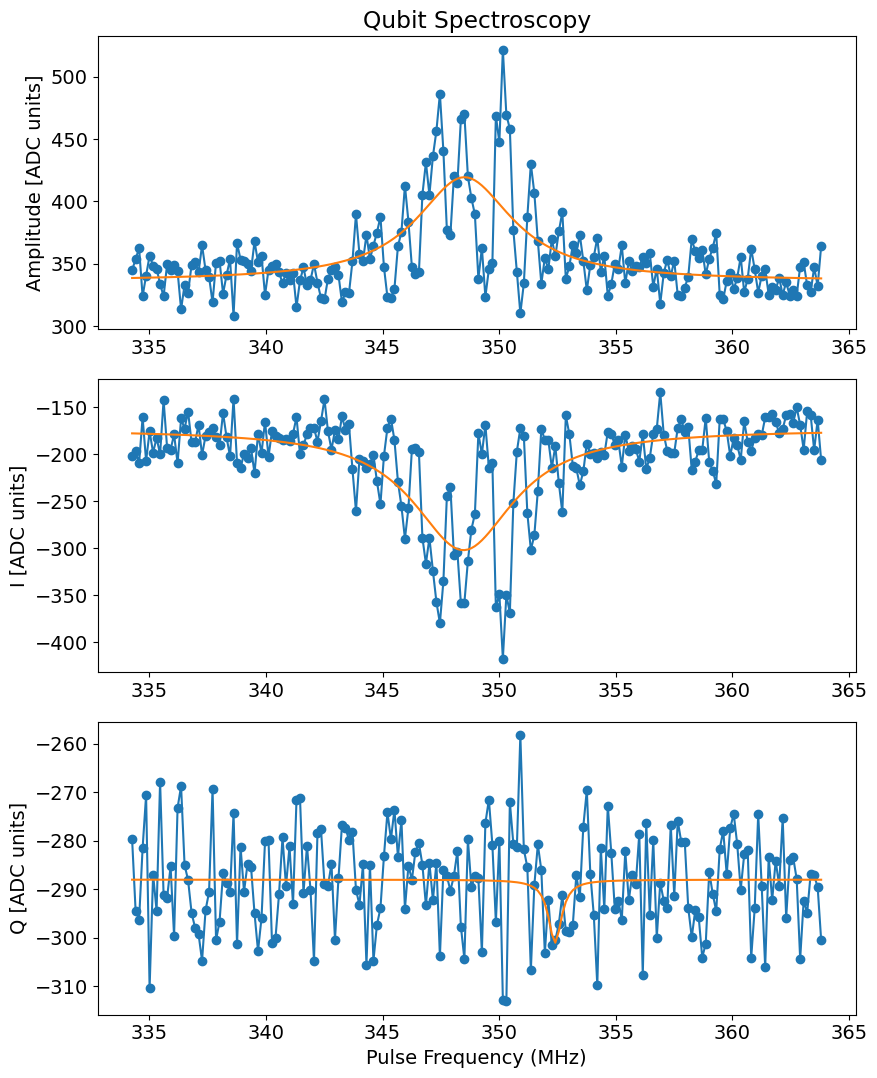

Updated frequency for M1-S1: 348.46781508935277
Running flux spectroscopy f0g1 for mode 2


  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00034_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 517.077759323008, HWHM 37.97685650258205
Found peak in I at [MHz] 520.104253180018, HWHM 3.0421818357277712
Found peak in Q at [MHz] 535.7730706774007, HWHM 6.512570559728336


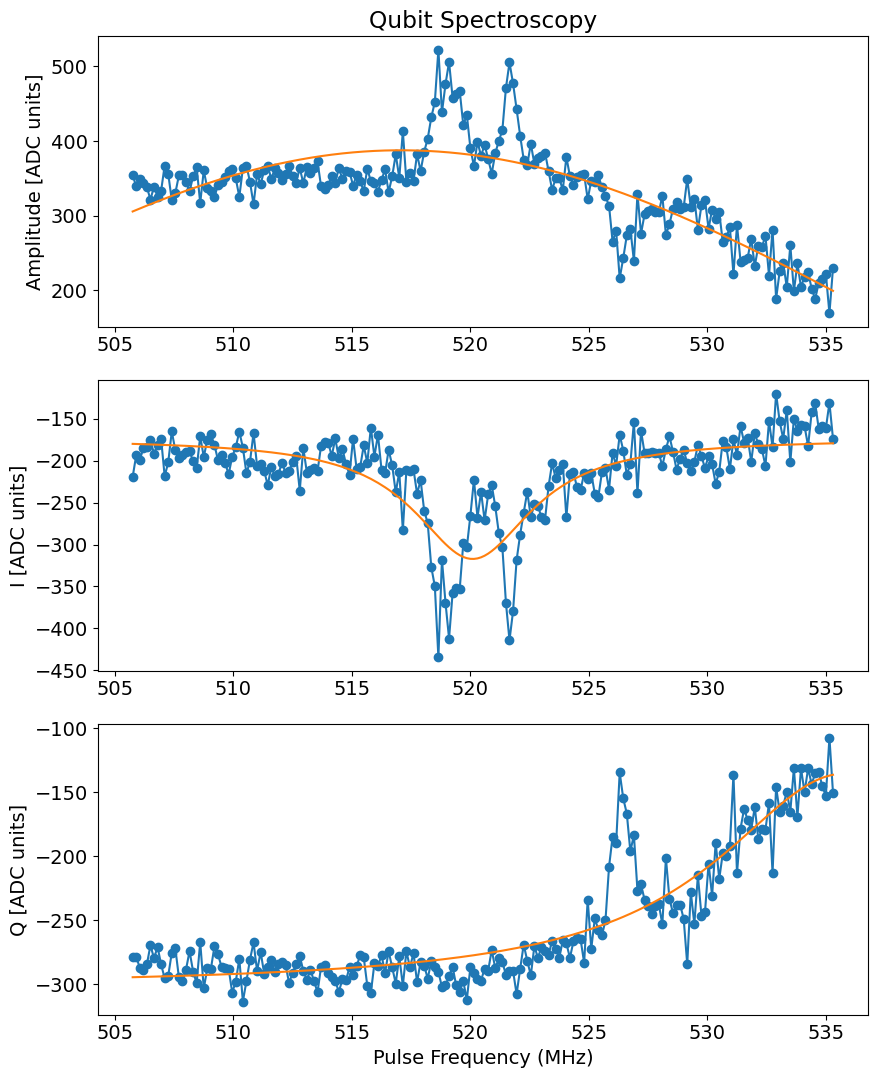

Updated frequency for M1-S2: 520.104253180018
Running flux spectroscopy f0g1 for mode 3


  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00035_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 696.1767434062497, HWHM -0.36273454222970253
Found peak in I at [MHz] 696.1584656844831, HWHM 0.39168261995475867
Found peak in Q at [MHz] 684.806209006168, HWHM -0.9825585869188237


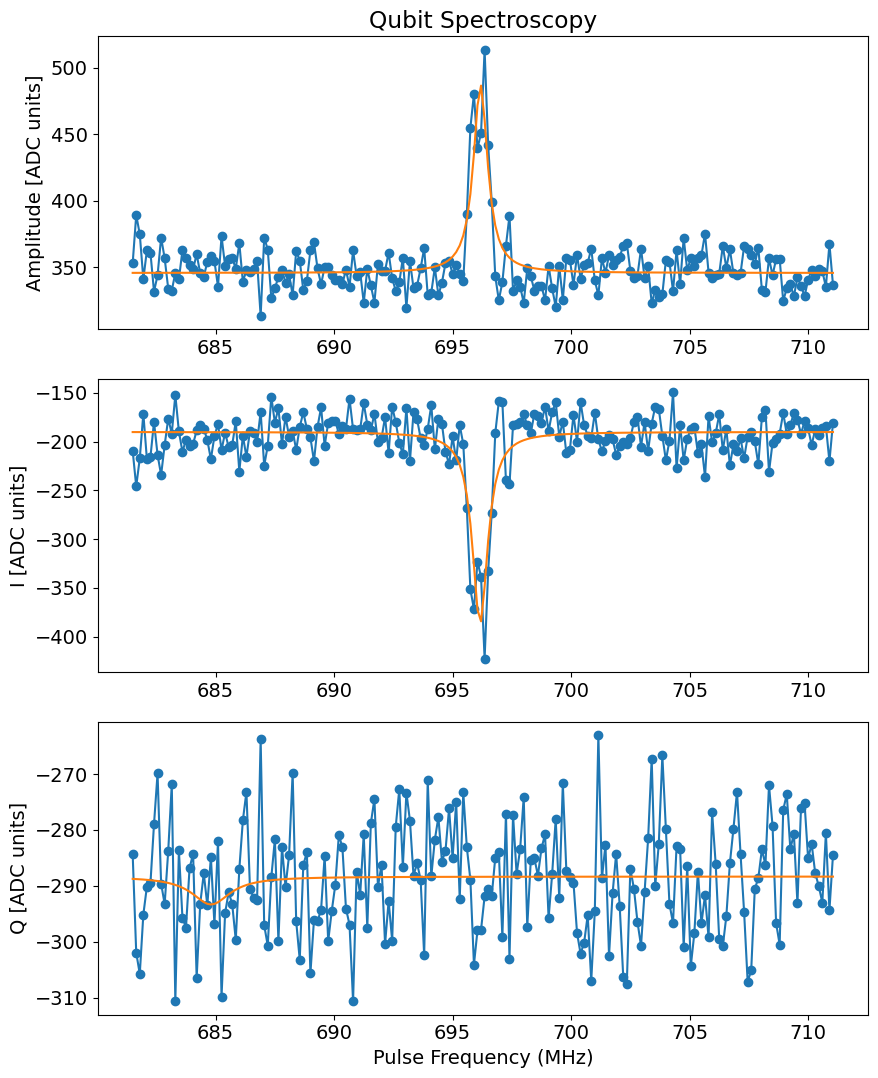

Updated frequency for M1-S3: 696.1584656844831
Running flux spectroscopy f0g1 for mode 4


  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00036_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 874.6469932878612, HWHM -0.5301852136647359
Found peak in I at [MHz] 874.6582240760672, HWHM 0.531464354730047
Found peak in Q at [MHz] 882.2921357890274, HWHM 10.719391386110354


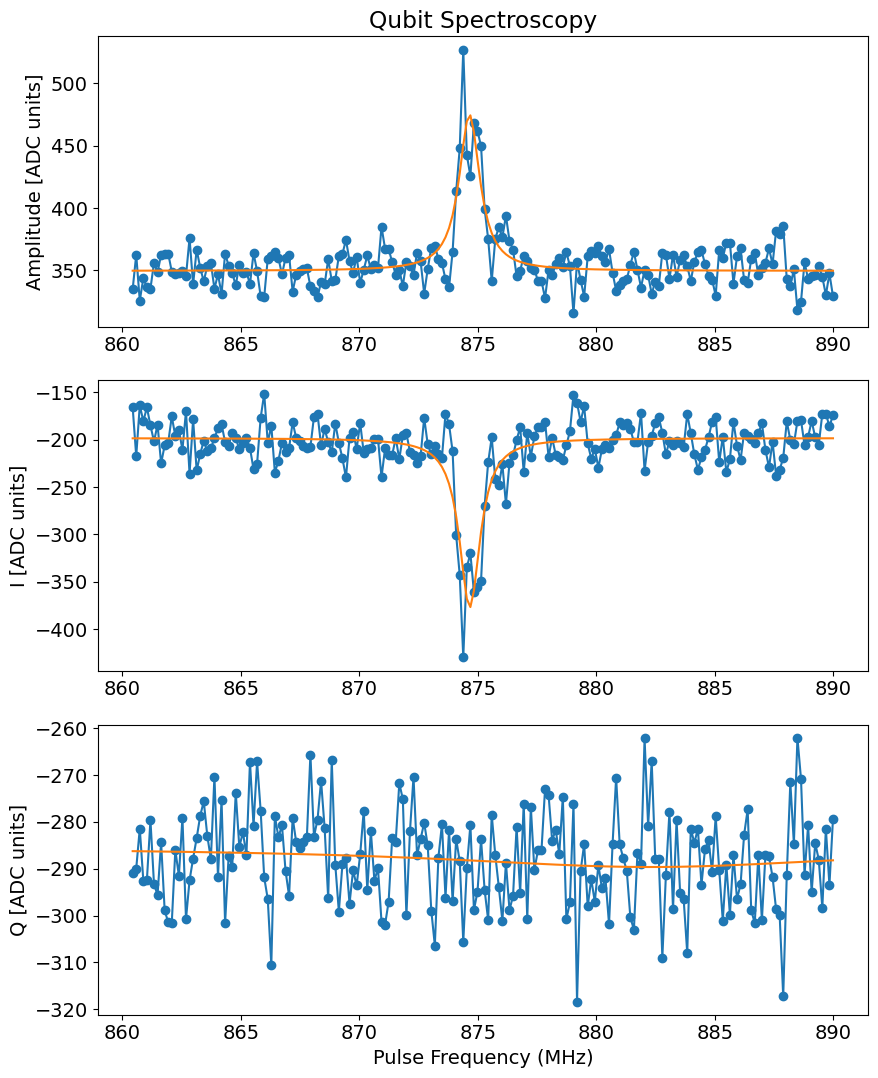

Updated frequency for M1-S4: 874.6582240760672
Running flux spectroscopy f0g1 for mode 5


  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00037_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 1053.2329472903796, HWHM -0.3418373376429251
Found peak in I at [MHz] 1053.2625815708398, HWHM -0.3673284603708073
Found peak in Q at [MHz] 1059.280531437554, HWHM -23.429840351588176


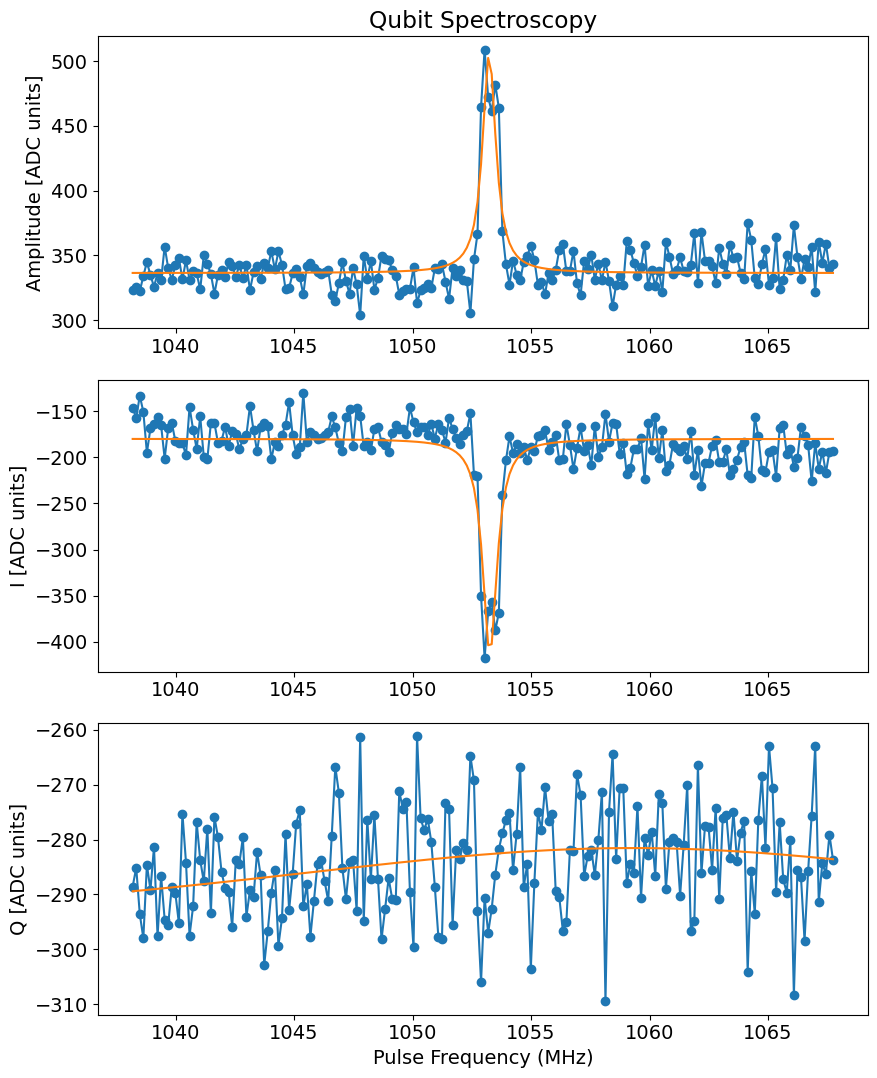

Updated frequency for M1-S5: 1053.2625815708398
Running flux spectroscopy f0g1 for mode 6


  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00038_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 1244.4564907579272, HWHM 0.3166735616317699
Found peak in I at [MHz] 1244.467694541277, HWHM -0.30103192796056255
Found peak in Q at [MHz] 1236.161048642832, HWHM 0.3717751600224861


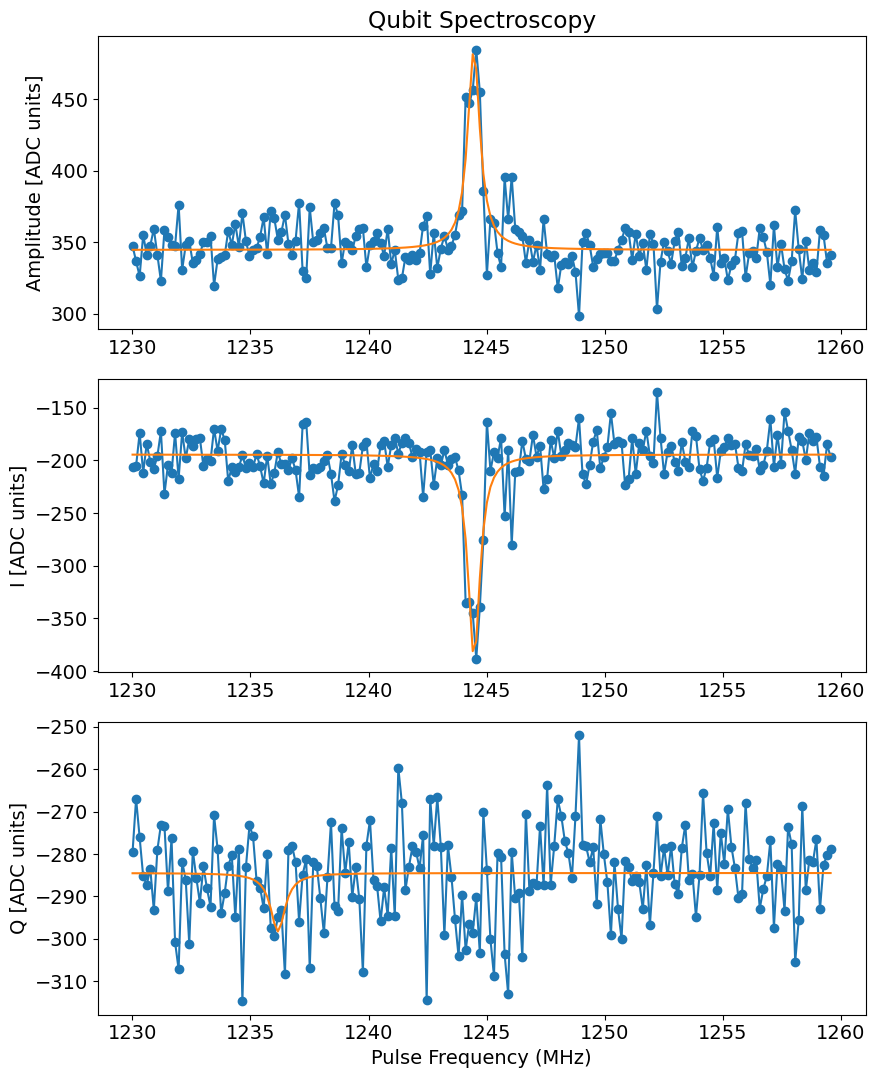

Updated frequency for M1-S6: 1244.467694541277
Running flux spectroscopy f0g1 for mode 7


  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00039_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 1422.4655730451211, HWHM 0.30222901748279096
Found peak in I at [MHz] 1422.44809987312, HWHM -0.29601013236943846
Found peak in Q at [MHz] 1434.7374511309843, HWHM 12.26253318028738


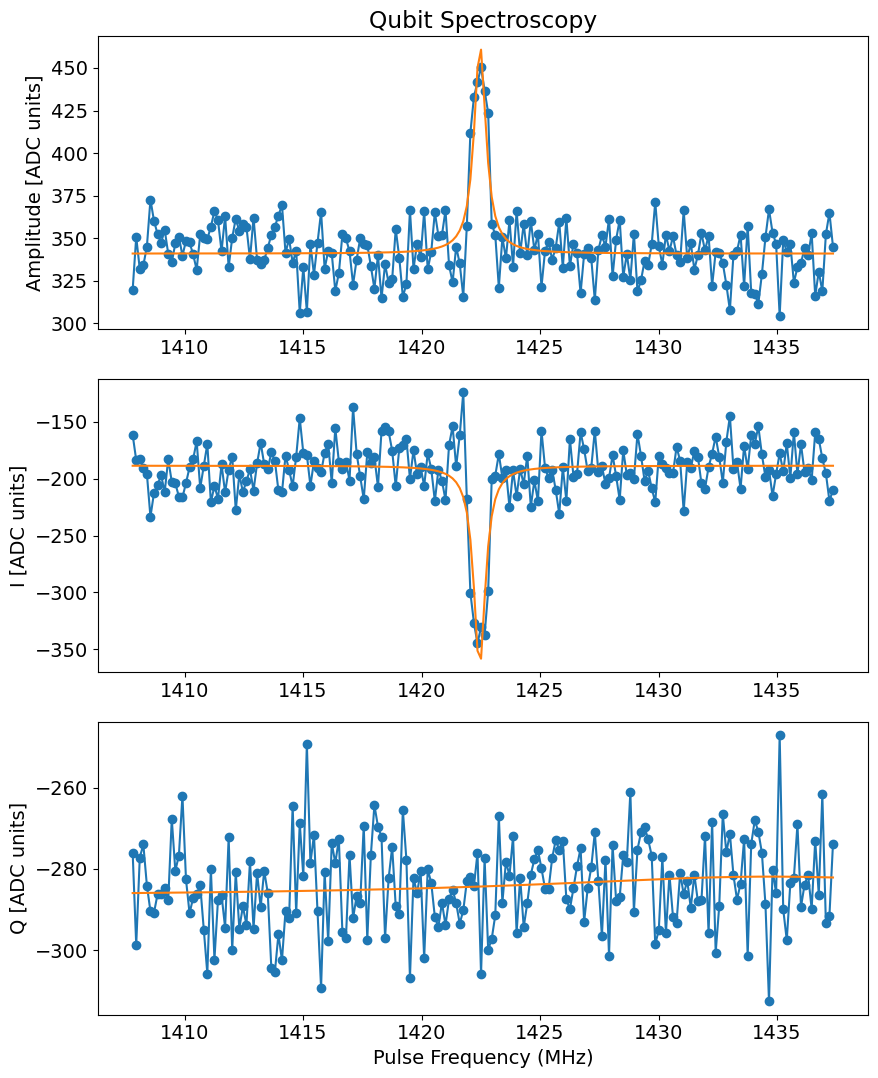

Updated frequency for M1-S7: 1422.44809987312


In [ ]:
stor_specs = [None]* len(expts_to_run['stor_modes'])
for i in range(len(expts_to_run['stor_modes'])):
    if expts_to_run['stor_spectroscopy']:
        print('Running flux spectroscopy f0g1 for mode', i+1)
        flux_spec = do_stor_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1, stor_no=i+1)
        stor_specs[i] = flux_spec
        analyze_and_display_stor_spectroscopy(flux_spec)
        update_stor_spectroscopy(flux_spec, ds_thisrun, man_mode_no=1, stor_no=i+1)

  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00042_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 1422.5220993928833, HWHM -0.20059551619592988
Found peak in I at [MHz] 1414.6273621603884, HWHM -0.36755034240073614
Found peak in Q at [MHz] 1422.9793735460128, HWHM 0.0057578844698915966


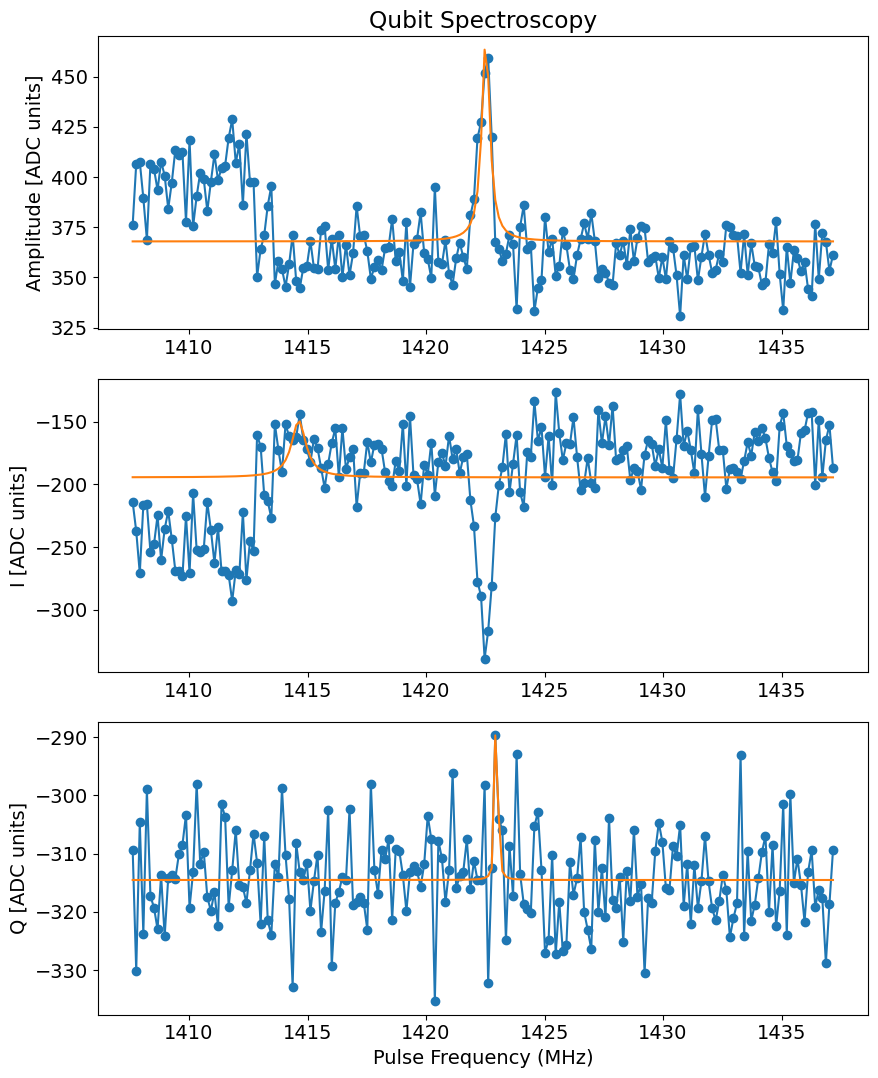

In [ ]:
i = 6
spec = do_stor_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1, stor_no=i+1)
analyze_and_display_stor_spectroscopy(spec)

### Man-dump

In [ ]:
def get_dump_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, dump_mode_no):
    """
    Get pulse parameters for a given storage mode. 
    Also returns prepulse and postpulse (single photon prep and meas for ge meas)

    Args:
        ds_thisrun: Dataset object for managing frequency data.
        config_thisrun: Configuration dictionary for the current run.
        man_mode_no: Manipulation mode number.
        dump_mode_no: Dump mode number.

    Returns:
        A tuple containing freq, gain, ch, prepulse, and postpulse.
    """
    freq = ds_thisrun.get_freq('M' + str(man_mode_no) + '-D' + str(dump_mode_no))
    gain = ds_thisrun.get_gain('M' + str(man_mode_no) + '-D' + str(dump_mode_no))
    ch = 'low' if freq < 1000 else 'high'

    from MM_dual_rail_base import MM_dual_rail_base
    mm_base_dummy = MM_dual_rail_base(config_thisrun)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist() # for ge meas, only do f0g1 and ef pi

    return freq, gain, ch, prepulse, postpulse


def do_dump_spectroscopy(config_thisrun, ds_thisrun,  expt_path, config_path, man_mode_no = 1, dump_no = 1):
    """
    Run the Flux Spectroscopy F0g1 Experiment.

    This function performs a flux spectroscopy experiment to measure the transition frequency
    between the f0 and g1 states of a qubit. It configures the experiment parameters, executes
    the experiment, and saves the results.

    Args:
        config_thisrun (AttrDict): Configuration dictionary for the current run.
        ds_thisrun (dataset.storage_man_swap_dataset): Dataset object for managing frequency data.
        expt_path (str): Path to save the experiment results.
        config_path (str): Path to the configuration file.
        man_mode_no (int, optional): Manipulation mode number (default is 1).
        dump_no (int, optional): Storage mode number (default is 1).

    Returns:
        FluxSpectroscopyF0g1Experiment: The experiment object containing the results.
    """
    flux_spec = meas.single_qubit.rf_flux_spectroscopy_f0g1.FluxSpectroscopyF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='FluxSpectroscopyF0g1Experiment', config_file=config_path
    )

    flux_spec.cfg = AttrDict(deepcopy(config_thisrun))

    freq, gain,ch, prepulse, postpulse = get_dump_mode_parameters(ds_thisrun, config_thisrun,
                                                                      man_mode_no, dump_no)

    flux_spec.cfg.expt = dict(
        start=freq - 5,  # Start RF frequency [MHz]
        step=0.05,  # Step size [MHz]
        expts=200,  # Number of experiments
        reps=200,  # Number of averages per point
        qubit=[0],
        flux_drive=[ch, 1,4000, 1],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        prepulse=True,
        postpulse=True,
        active_reset=False,
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )

    flux_spec.cfg.device.readout.relax_delay = [500]  # Wait time between experiments [us]
    flux_spec.go(analyze=False, display=False, progress=True, save=True)
    return flux_spec


def update_dump_spectroscopy(flux_spec, ds_thisrun, man_mode_no = 1, dump_no = 1):
    """Update the configuration based on Flux Spectroscopy F0g1 experiment results."""
    # Update the dataset with the new frequency
    ds_thisrun.update_freq('M' + str(man_mode_no) + '-D' + str(dump_no), flux_spec.data['fit_avgi'][2])
    print(f"Updated frequency for M{man_mode_no}-D{dump_no}: {flux_spec.data['fit_avgi'][2]}")


  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00040_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 2313.4311001477845, HWHM -0.1773656540852489
Found peak in I at [MHz] 2313.4262056014545, HWHM -0.1870022328508642
Found peak in Q at [MHz] 2313.7382801974336, HWHM 0.30626519916722644


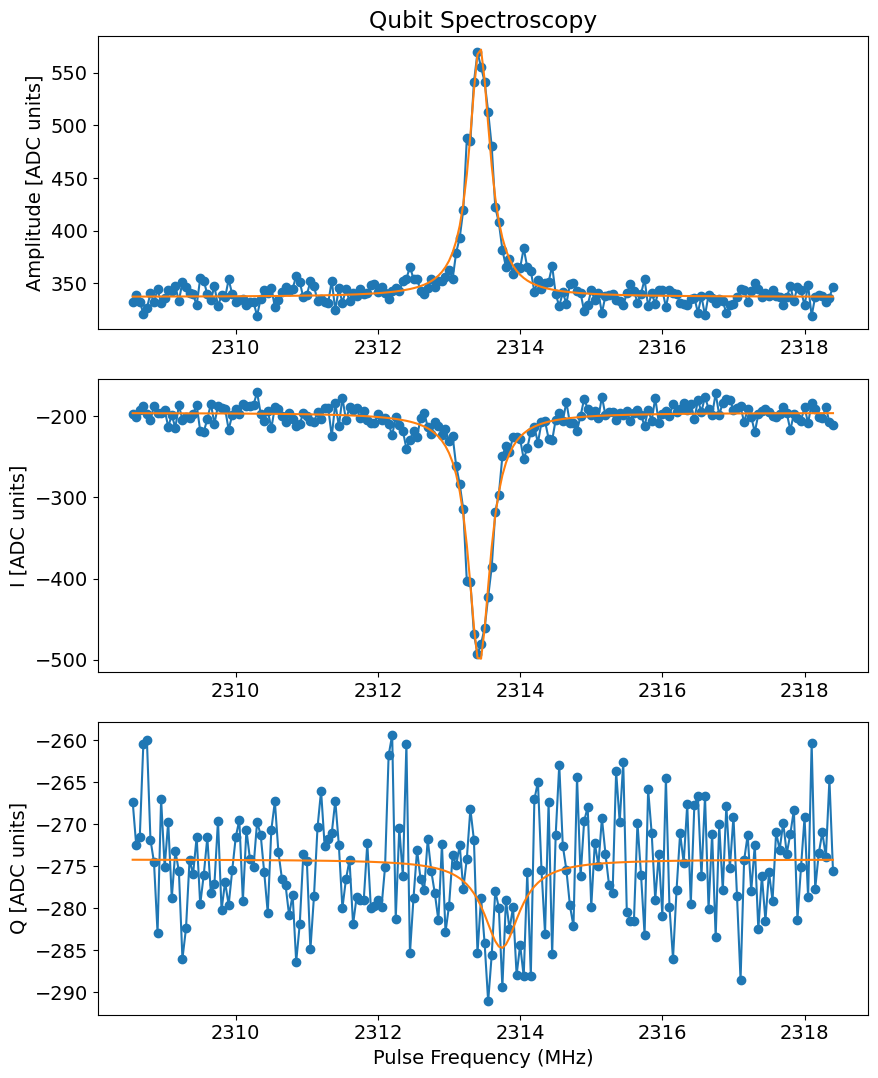

In [ ]:
# spec = do_dump_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1, dump_no=1)
# analyze_and_display_stor_spectroscopy(spec)

In [ ]:
# update_dump_spectroscopy(spec, ds_thisrun, man_mode_no = 1, dump_no = 1)
# ds_thisrun.update_gain('M1-D1', 4000)

Updated frequency for M1-D1: 2313.4262056014545


## Find Frequency (Chevron)

In [ ]:
def do_sideband_general_sweep(config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step,
                              man_mode_no = 1, stor_mode_no = 1, start_time = 0.007):
    """Run the Sideband General Sweep Experiment."""
    from multimode_expts.sequential_experiment_classes import sidebands_class
    experiment_class = sidebands_class
    sweep_experiment_name = 'sideband_general_sweep'
    class_for_exp = experiment_class(soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file,
                                     config_thisrun=config_thisrun)

    # class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    # get pulse parameters for the given storage mode
    freq, gain, ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no)
    
    class_for_exp.loaded[sweep_experiment_name] =  dict(
        start=start_time,  # Pulse start length [us]
        step=0.1,  # Pulse step length [us]
        qubits=[0],
        expts=100,
        reps=100,
        rounds=1,
        freq_start=freq_start,
        freq_stop=freq_stop,
        freq_step=freq_step,
        flux_drive=[ch, freq, gain, 0.05],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        prepulse=True,
        postpulse=True,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        update_post_pulse_phase=[False, 1.07],
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )
    class_for_exp.yaml_cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]

    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)


def update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=1):
    """Update sweep data and analyze results."""
    temp_data, attrs, filename = prev_data(expt_path, prefix='sideband_general_sweep')
    print('File saved at:', filename)

    from multimode_expts.fit_display_classes import ChevronFitting
    from datetime import datetime
    chevron_analysis = ChevronFitting(
        frequencies=temp_data['freq_sweep'],
        time=temp_data['xpts'][0],
        response_matrix=temp_data['avgi']
    )
    chevron_analysis.analyze()
    
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    chevron_analysis.display_results(save_fig=True, directory=autocalib_path, title=f'M{man_mode_no}-S{stor_mode_no}_{current_time}')

    # Update dataset
    ds_thisrun.update_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no),chevron_analysis.results['best_frequency_contrast'])
    print('Updated the frequency to:', chevron_analysis.results['best_frequency_contrast'])
    return chevron_analysis

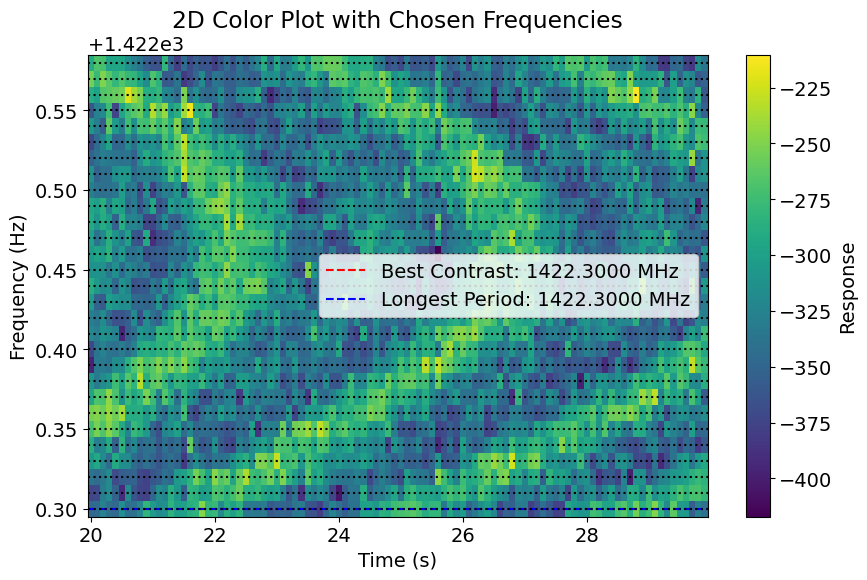

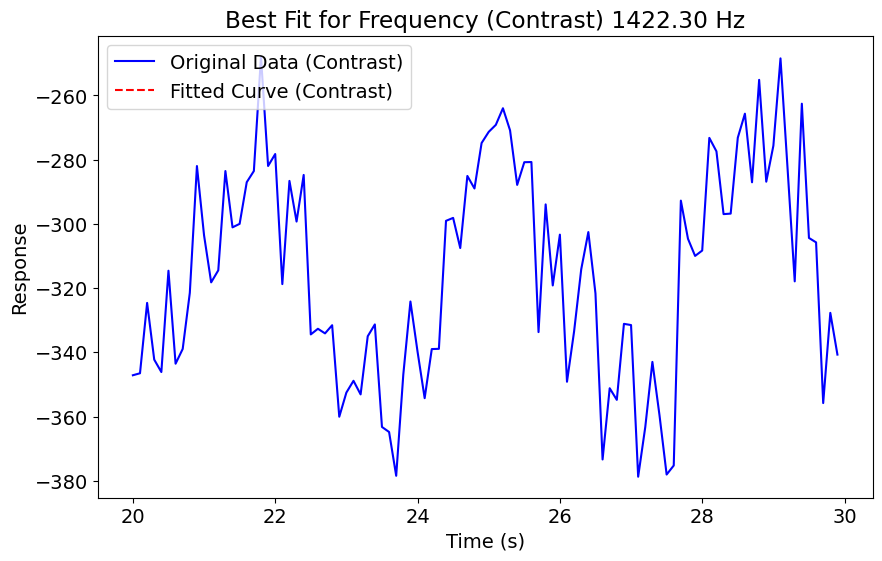

Index: 29 Freq. = 1422.5899999999997 MHz
Running experiment with config: configthisrun
Waiting for [100] us


KeyboardInterrupt: 

In [ ]:
sideband_chevrons_coarse = [None] * len(expts_to_run['stor_modes'])
sideband_chevrons_fine = [None] * len(expts_to_run['stor_modes'])

for i in [6]: #range(len(expts_to_run['stor_modes'])):
    if expts_to_run['sideband_freq_sweep']:
        # print(f'Running coarse sideband sweep for storage mode {i + 1}')
        # freq_start = ds_thisrun.get_freq('M1-S' + str(i + 1)) - 2
        # freq_stop = ds_thisrun.get_freq('M1-S' + str(i + 1)) + 2
        # freq_step = 0.2
        # sideband_chevrons_coarse[i] = do_sideband_general_sweep(config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step, man_mode_no=1, stor_mode_no=i + 1)
        # update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=i + 1)

        print(f'Running fine sideband sweep for storage mode {i + 1}')
        freq_start = ds_thisrun.get_freq('M1-S' + str(i + 1)) - 0.2
        freq_stop = ds_thisrun.get_freq('M1-S' + str(i + 1)) + 0.2
        freq_step = 0.01
        sideband_chevrons_fine[i] = do_sideband_general_sweep(
            config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step, 
            man_mode_no=1, stor_mode_no=i + 1, start_time=20)
        update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=i + 1)

### Manually get the frequencies from the chevrons

In [ ]:
# file_list = [34,36,38,40,42,44,46]
# chevrons_stor_objects = [None]* len(file_list)
# name = '_sideband_general_sweep.h5'
# # name = '_storage_sideband_sweep.h5'
# for idx, file_no in enumerate(file_list):
#     full_name = str(file_no).zfill(5)+name
#     expt_path_mod = r"H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data"
#     temp_data, attrs, filename = prev_data(expt_path_mod, full_name)  # ef

#     from multimode_expts.fit_display_classes import ChevronFitting
#     chevron_analysis = ChevronFitting(
#         frequencies=temp_data['freq_sweep'],
#         time=temp_data['xpts'][0],
#         response_matrix=temp_data['avgi']
#     )
#     chevrons_stor_objects[idx] = chevron_analysis

uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid


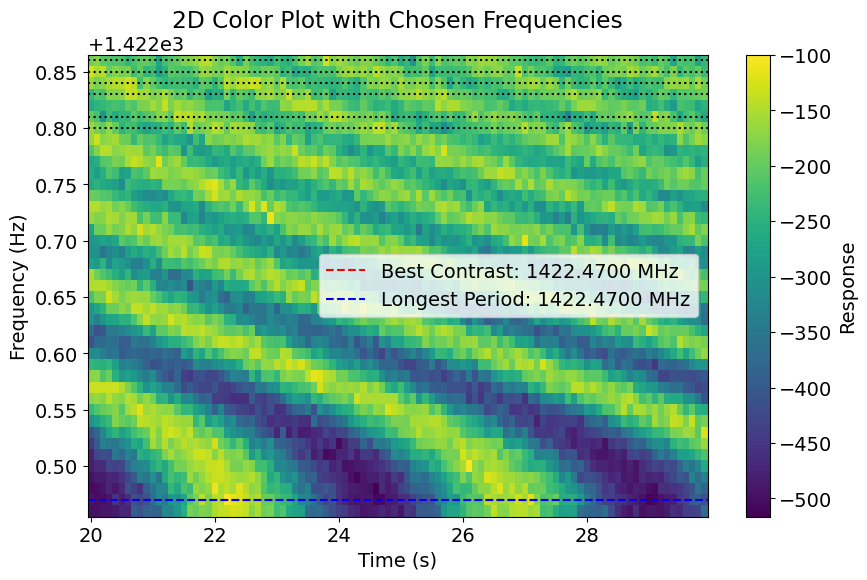

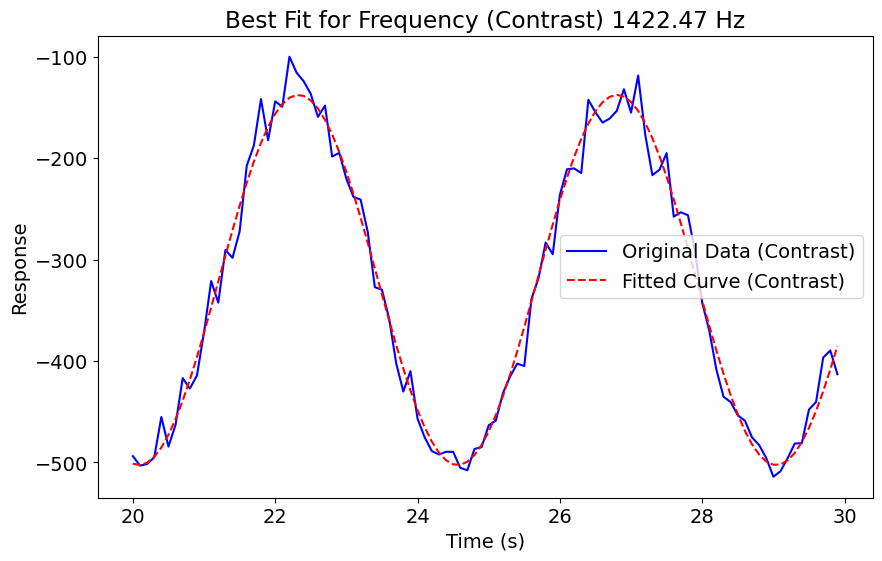

In [ ]:
# i = 6
# # guess_freq = 1422.66
# anls = chevrons_stor_objects[i]
# anls.analyze()
# anls.display_results(save_fig=False, 
#                     directory=autocalib_path, 
#                     title=f'M1-S{i+1}')
#                 #  hlines = [guess_freq])
# ds_thisrun.update_freq('M1-S' + str(i+1), anls.results['best_frequency_period'])
# # or override manually 
# # ds_thisrun.update_freq('M1-S' + str(i+1), 1052.8026)

In [ ]:
ds_thisrun.df

stor_name   freq (MHz)  precision (MHz)   pi (mus)  h_pi (mus)  \
0      M1-S1   348.927815              NaN   0.924910    0.438304   
1      M1-S2   520.414253              NaN   1.117439    0.560127   
2      M1-S3   696.158466              NaN   1.323409    0.657025   
3      M1-S4   874.830000              NaN   1.228396    0.611402   
4      M1-S5  1052.812582              NaN   1.958569    0.980820   
5      M1-S6  1244.637695              NaN   1.581354    0.795417   
6      M1-S7  1422.470000              NaN   2.366920    1.287995   
7      M1-S8    -1.000000            -1.00  -1.000000   -1.000000   
8      M1-S9    -1.000000            -1.00  -1.000000   -1.000000   
9     M1-S10    -1.000000            -1.00  -1.000000   -1.000000   
10    M1-S11    -1.000000            -1.00  -1.000000   -1.000000   
11    M1-S12    -1.000000            -1.00  -1.000000   -1.000000   
12        M1  2005.860000              NaN   1.094629    0.553360   
13        M2  1834.950000             0.01   1.054456    0.520515   
14     M2-S1   175.630000             0.01   2.173484    1.086742   
15     M2-S2   346.840000             0.01   0.908835    0.454417   
16     M2-S3   523.220000             0.01   1.561615    0.780808   
17     M2-S4   702.650000             0.01   1.386764    0.693382   
18     M2-S5   878.780000             0.01   1.303372    0.651686   
19     M2-S6  1070.100000             0.01   2.379622    1.189811   
20     M2-S7  1249.700000             0.01   1.796981    0.898491   
21     M2-M1   173.790000             0.01   0.463481    0.231741   
22     M1-D1  2313.426206             0.01  10.000000    0.000000   
23     M2-D2  2094.050000             0.01  15.000000    0.000000   
24      M1-C   973.230000             0.02   0.251127    0.122354   
25     M1_ce  2008.780000             0.02   0.617915    0.304523   

    gain (DAC units)                 last_update  
0               3000  2025-06-05 14:31:39.051794  
1               5000  2025-06-05 10:55:47.676587  
2               9000  2025-06-05 10:58:35.982971  
3               9000  2025-06-05 11:01:24.217833  
4               7500  2025-06-05 11:04:12.804176  
5              13500  2025-06-05 11:07:01.045244  
6              10000  2025-06-05 11:09:49.471440  
7                 -1                     51:31.3  
8                 -1                     51:31.3  
9                 -1                     51:31.3  
10                -1                     51:31.3  
11                -1                     51:31.3  
12             15000  2025-06-05 00:20:34.740589  
13             15000  2025-04-30 11:22:11.432806  
14              1000                     28:20.8  
15              5000                     33:56.1  
16              5000                     22:30.3  
17              9000                     25:33.1  
18             13500                     00:05.4  
19              9000                     30:59.0  
20             12000                     56:07.5  
21              2000  2024-10-06 01:47:25.946153  
22              4000  2025-06-04 17:23:32.148629  
23              8000  2025-01-23 17:22:53.776061  
24              1000  2025-01-20 09:34:00.029234  
25             15000  2025-01-20 09:52:35.311227

In [ ]:

# ds_thisrun.update_freq('M1-S' + str(i), guess_freq)

In [ ]:
# ds_thisrun.get_freq('M1-S3')

696.35

## Sideband General

In [ ]:
def do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no = 1,stor_mode_no=1):
    """Run the Sideband General Experiment."""
    
    sideband_general = meas.single_qubit.sideband_general.SidebandGeneralExperiment(
        soccfg=soc, path=expt_path, prefix='SidebandGeneralExperiment', config_file=config_path
    )

    sideband_general.cfg = AttrDict(deepcopy(config_thisrun))

    # Sideband general experiment parameters
    freq, gain, ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no)

    sideband_general.cfg.expt = dict(
        start=0.007,  # Pulse start length [us]
        step=0.05,  # Pulse step length [us]
        qubits=[0],
        expts=100,
        reps=200,
        rounds=1,
        flux_drive=[ch, freq, gain],  # RF flux modulation
        prepulse=True,
        postpulse=True,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        update_post_pulse_phase=[False, 1.07],
        pre_sweep_pulse=prepulse,
        post_sweep_pulse=postpulse,
    )

    sideband_general.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
    sideband_general.go(analyze=False, display=False, progress=True, save=True)
    from multimode_expts.fit_display_classes import LengthRabiFitting
    sideband_analysis = LengthRabiFitting(sideband_general.data, config=sideband_general.cfg)
    sideband_analysis.analyze()
    sideband_analysis.display(title_str='Sideband General', save_fig=True)

    return sideband_analysis


def update_sideband_general(sideband_general, config_thisrun, ds, man_mode_no=1, stor_mode_no=1):
    """Update the configuration and dataset based on Sideband General experiment results."""
    # Analyze the data
    

    # Update dataset
    pi_length = sideband_general.results['pi_length']
    pi2_length = sideband_general.results['pi2_length']
    gain = sideband_general.cfg.expt['flux_drive'][2]
    freq = sideband_general.cfg.expt['flux_drive'][1]
    ds.update_all('M' + str(man_mode_no) + '-S' + str(stor_mode_no), freq, np.nan, pi_length, pi2_length, gain)
    print(f'Updated configuration and dataset: pi_length={pi_length}, pi2_length={pi2_length}, gain={gain}')



Running sideband general for manipulation mode 1 and storage mode 1


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00033_SidebandGeneralExperiment.h5
p1: 0.5187179604558663
p2: 92.5362772719069
Pi length: 0.9503329804169292
Pi/2 length: 0.4683755024451006
p1: 0.5189611738193916
p2: -86.80398203122684
Pi length: 0.9463562923107681
Pi/2 length: 0.4646246857628671


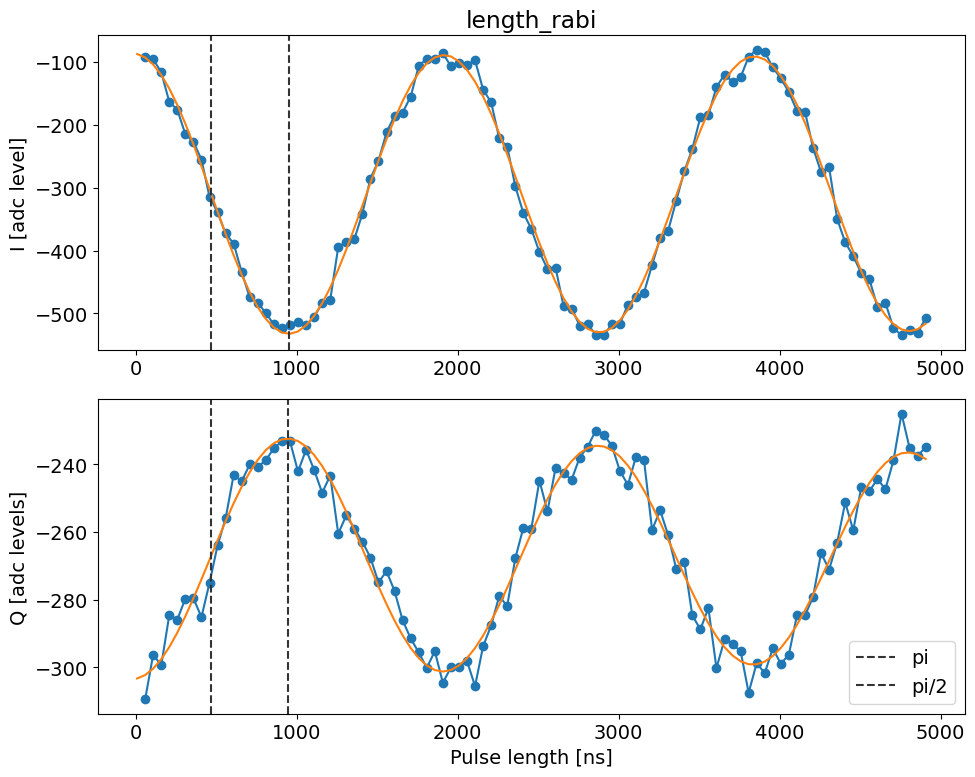

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-05_16-09-26_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-05.md
Updated configuration and dataset: pi_length=0.9503329804169292, pi2_length=0.4683755024451006, gain=3000
Running sideband general for manipulation mode 1 and storage mode 2


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00034_SidebandGeneralExperiment.h5
p1: 0.44637024978919315
p2: 91.15696960992511
Pi length: 1.1129464738355717
Pi/2 length: 0.5528733056124043
p1: 0.4410908700657737
p2: -85.08334328384086
Pi length: 1.1025905391339654
Pi/2 length: 0.5358139020144508


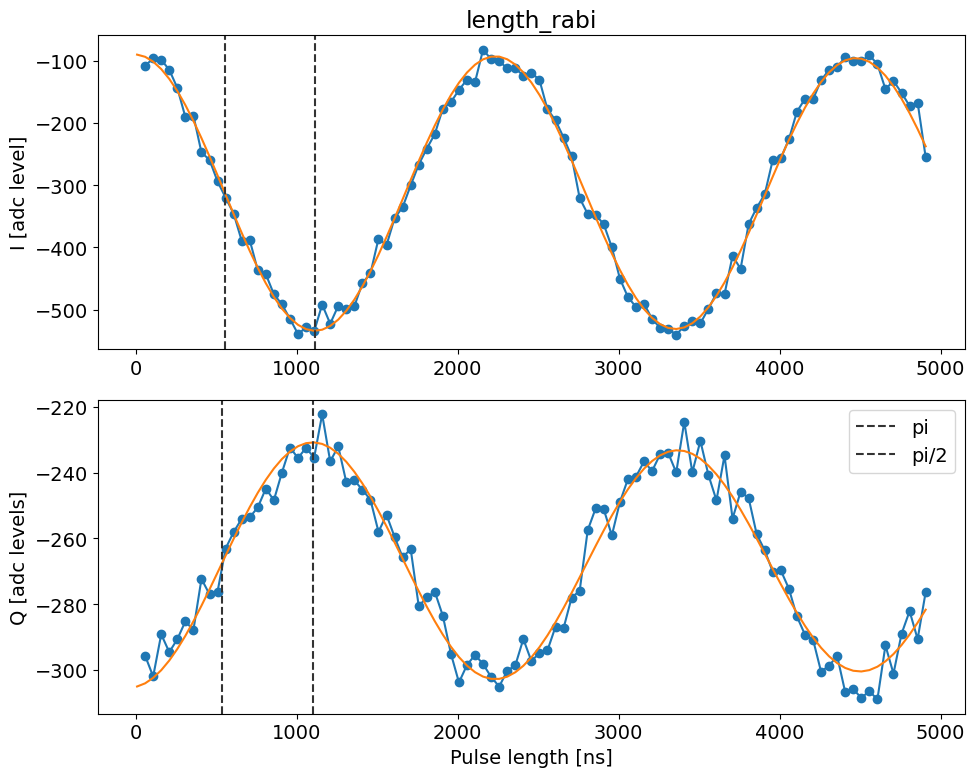

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-05_16-12-14_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-05.md
Updated configuration and dataset: pi_length=1.1129464738355717, pi2_length=0.5528733056124043, gain=5000
Running sideband general for manipulation mode 1 and storage mode 3


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00035_SidebandGeneralExperiment.h5
p1: 0.3749827200823031
p2: 90.4152439998562
Pi length: 1.3303187526490674
Pi/2 length: 0.663621364713088
p1: 0.37812627889706885
p2: -93.18401631981405
Pi length: 1.3456998843388395
Pi/2 length: 0.6845450957078874


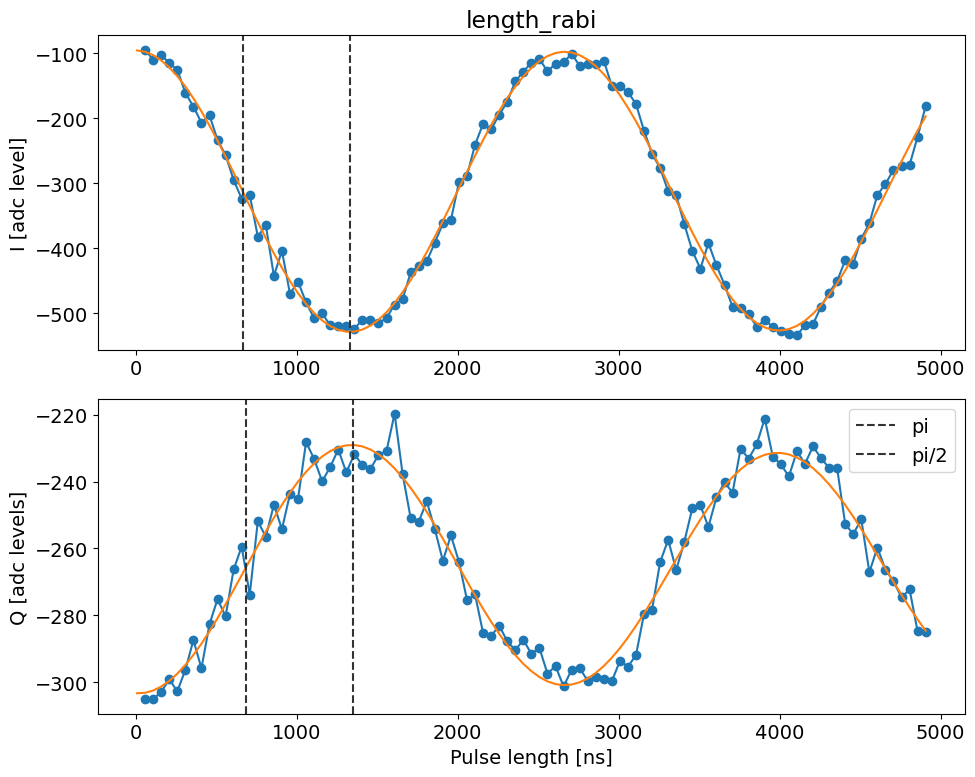

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-05_16-15-03_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-05.md
Updated configuration and dataset: pi_length=1.3303187526490674, pi2_length=0.663621364713088, gain=9000
Running sideband general for manipulation mode 1 and storage mode 4


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00036_SidebandGeneralExperiment.h5
p1: 0.4037530141317429
p2: 91.6015741789458
Pi length: 1.2273621879998284
Pi/2 length: 0.6081717640283406
p1: 2.253235851219014
p2: -160.135957740896
Pi length: 0.3083663454315798
Pi/2 length: 0.19741479996209488


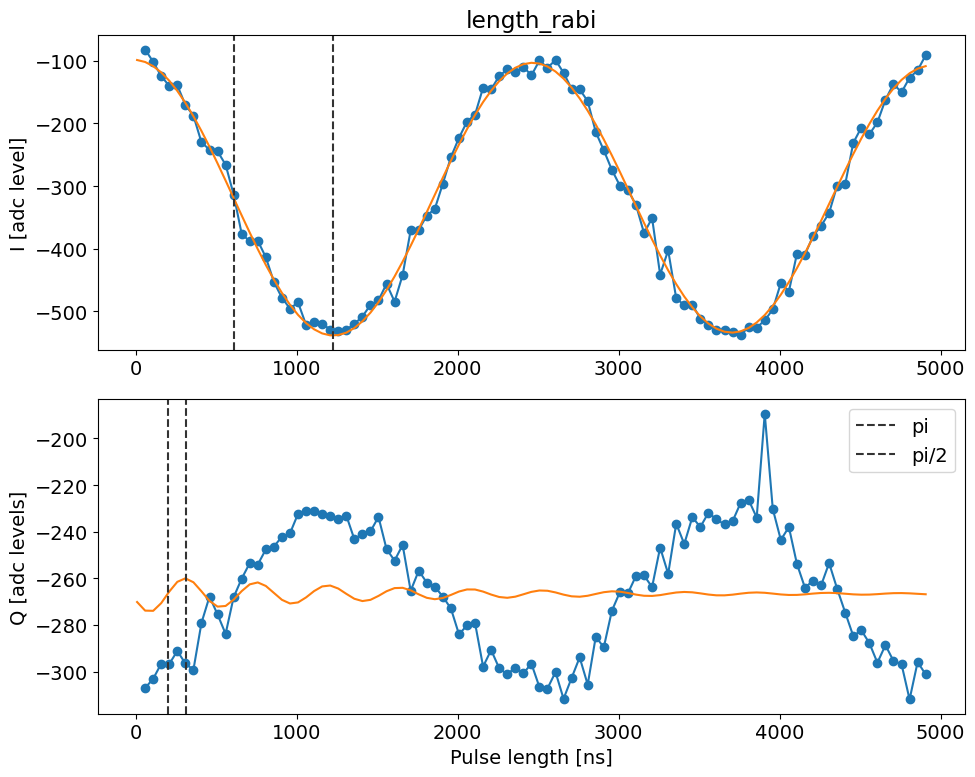

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-05_16-17-51_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-05.md
Updated configuration and dataset: pi_length=1.2273621879998284, pi2_length=0.6081717640283406, gain=9000
Running sideband general for manipulation mode 1 and storage mode 5


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00037_SidebandGeneralExperiment.h5
p1: 0.2529050620466753
p2: 91.10208507737265
Pi length: 1.9649217320574646
Pi/2 length: 0.9764085011366028
p1: 0.25186336753654065
p2: -89.74652855262565
Pi length: 1.9824078329840638
Pi/2 length: 0.9898061599212683


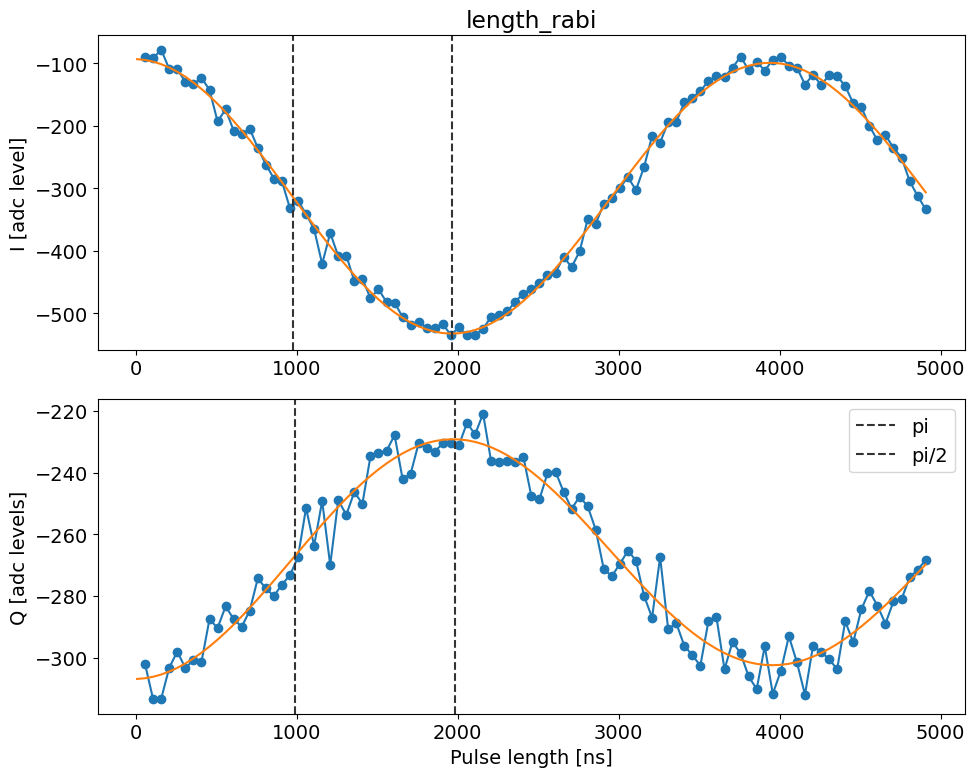

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-05_16-20-39_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-05.md
Updated configuration and dataset: pi_length=1.9649217320574646, pi2_length=0.9764085011366028, gain=7500
Running sideband general for manipulation mode 1 and storage mode 6


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00038_SidebandGeneralExperiment.h5
p1: 0.31796833019764903
p2: 87.71435152055562
Pi length: 1.5924511200196123
Pi/2 length: 0.8062092957328978
p1: 0.3189310606679649
p2: -93.36023408998379
Pi length: 1.597003385360291
Pi/2 length: 0.8131349233911012


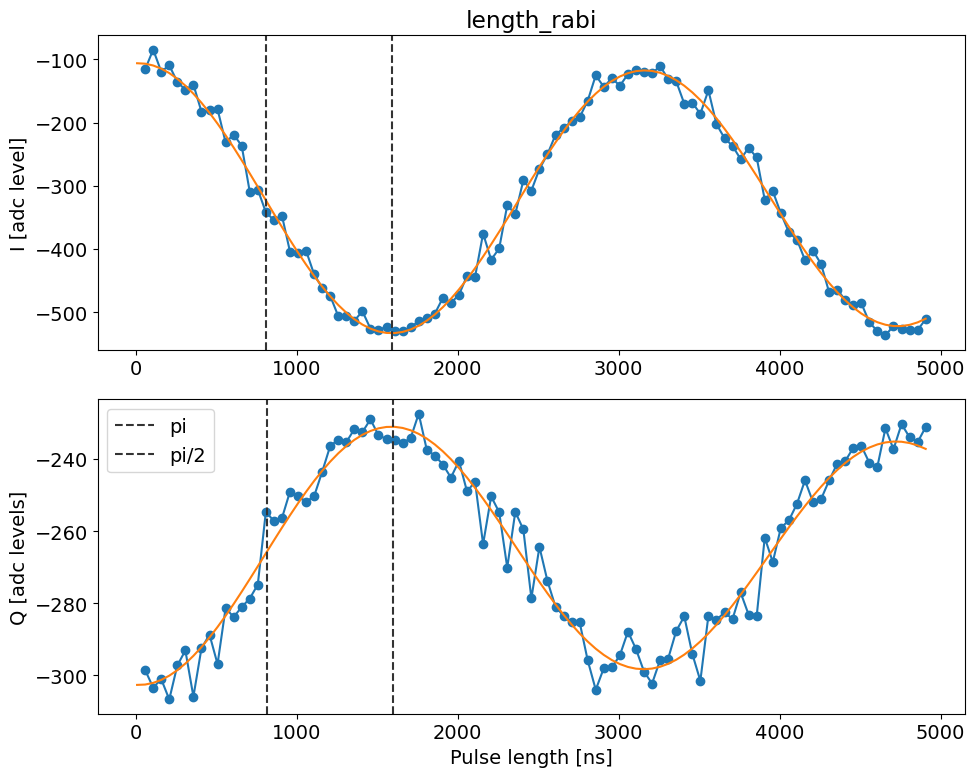

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-05_16-23-27_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-05.md
Updated configuration and dataset: pi_length=1.5924511200196123, pi2_length=0.8062092957328978, gain=13500
Running sideband general for manipulation mode 1 and storage mode 7


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00039_SidebandGeneralExperiment.h5
p1: 0.020408163267063878
p2: 169.85578698885678
Pi length: 13.630740103120477
Pi/2 length: 1.380740104175569
p1: 0.8032011413438466
p2: -168.6786233413811
Pi length: 0.8946099482647869
Pi/2 length: 0.5833554104765043


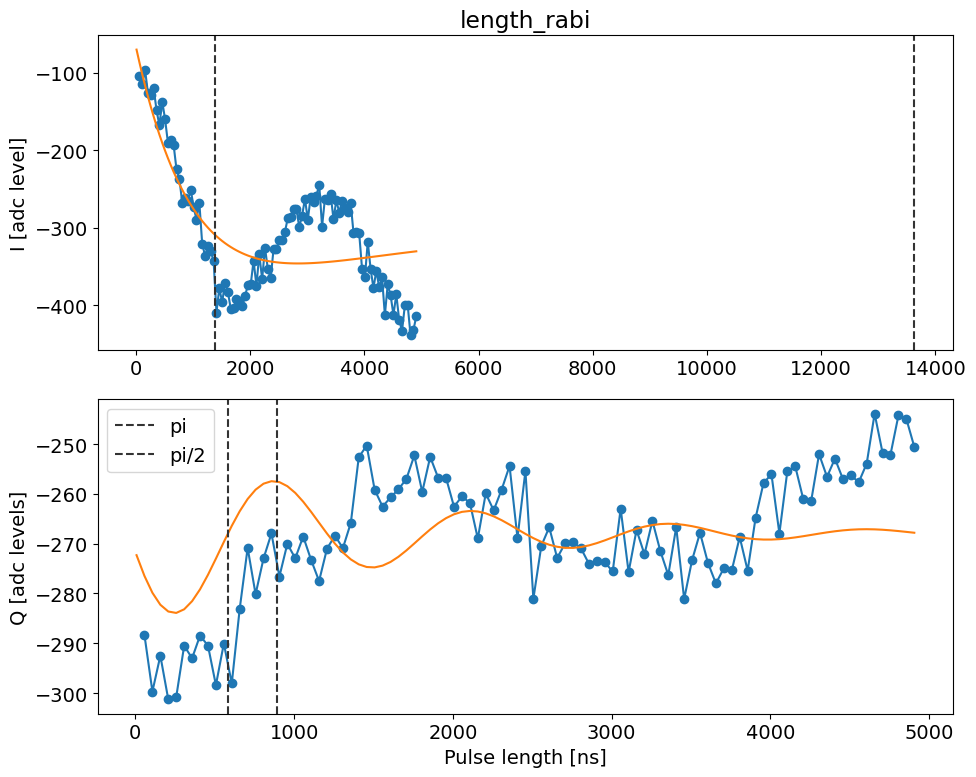

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-05_16-26-16_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-05.md
Updated configuration and dataset: pi_length=13.630740103120477, pi2_length=1.380740104175569, gain=10000


In [ ]:
len_rabi_storages = [None]* len(expts_to_run['stor_modes'])
if expts_to_run['sideband_length_rabi']:
    for man_mode_no in expts_to_run['man_modes']:
        for stor_mode_no in expts_to_run['stor_modes']:
            print(f'Running sideband general for manipulation mode {man_mode_no} and storage mode {stor_mode_no}')
            len_rabi_storages[stor_mode_no-1] = do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no, stor_mode_no)
            update_sideband_general(len_rabi_storages[stor_mode_no-1], config_thisrun, ds_thisrun, man_mode_no, stor_mode_no)


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00004_SidebandGeneralExperiment.h5
Attempted to init fitparam 1 to 7.474747474747475, which is out of bounds 0.02040816326530612 to 3.061224489795918. Instead init to 1.540816326530612
p1: 0.5156139789528535
p2: 89.44622025936214
Pi length: 0.9727010855599528
Pi/2 length: 0.4878422372647258
p1: 1.1928488211637922
p2: -175.8385207680922
Pi length: 0.6190560969381436
Pi/2 length: 0.40947379651210153


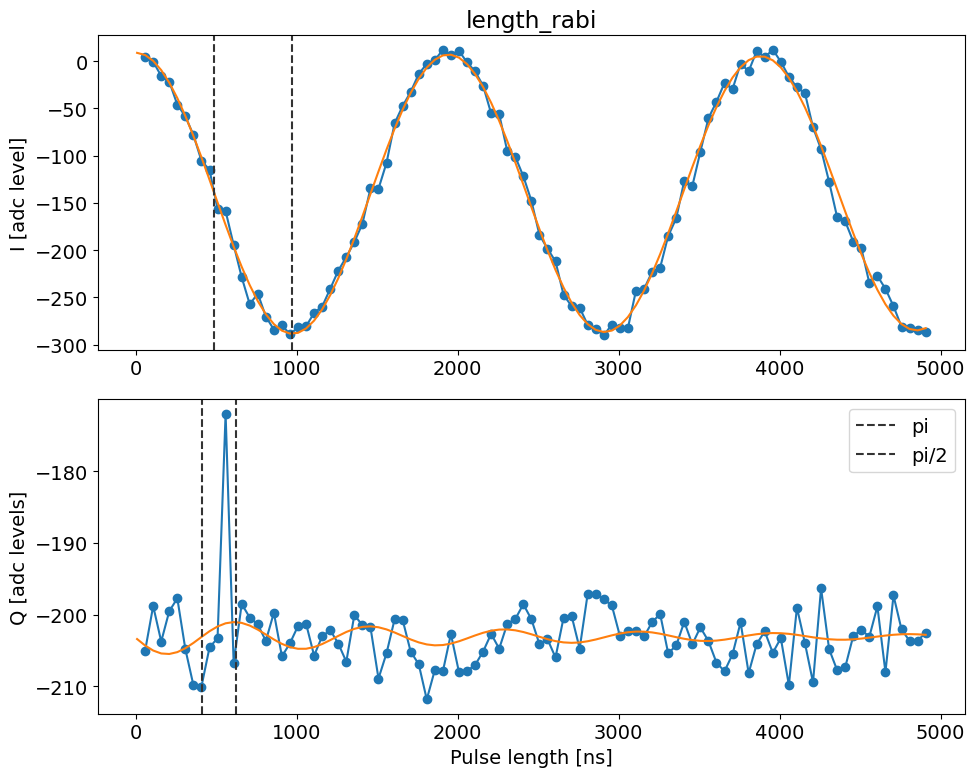

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-23_13-48-55_Sideband_General.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-23.md
Updated configuration and dataset: pi_length=0.9727010855599528, pi2_length=0.4878422372647258, gain=3000


In [ ]:
# stor_mode_no = 1
# man_mode_no = 1
# len_rabi_storage = do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no, stor_mode_no)
# update_sideband_general(len_rabi_storage, config_thisrun, ds_thisrun, man_mode_no, stor_mode_no)

## Randomized Benchmarking

In [ ]:
len([1, 5, 10, 15, 25, 50, 75, 100, 150, 200, 250, 400, 500, 600, 700, 850, 1000, 1250, 1500])

19

In [ ]:
# config_thisrun.device.storage.ramp_sigma
# man_mode_no = 1
# stor_mode_no = 7
# req = ds_thisrun.get_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
# gain = ds_thisrun.get_gain('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
# hpi_length = ds_thisrun.get_h_pi('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
# print("ramp_sigma:", config_thisrun.device.storage.ramp_sigma)
# print("man_mode_no:", man_mode_no)
# print("stor_mode_no:", stor_mode_no)
# print("freq:", req)
# print("gain:", gain)
# print("hpi_length:", hpi_length)

ramp_sigma: 0.005
man_mode_no: 1
stor_mode_no: 7
freq: 1422.66
gain: 10000
hpi_length: 1.1321820731541319


In [ ]:


def do_single_beam_splitter_rb_postselection_sweep_depth(config_thisrun, ds_thisrun, expt_path, config_path, exp_param_file, man_mode_no=1, stor_mode_no=1,
                                                         prev_data=None):
    """
    Run the SingleBeamSplitterRBPostSelection_sweep_depth experiment.
    """
    from multimode_expts.sequential_experiment_classes import MM_DualRailRB
    experiment_class = MM_DualRailRB
    sweep_experiment_name = 'SingleBeamSplitterRBPostSelection_sweep_depth'
    class_for_exp = experiment_class(
        soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file, 
        prev_data=prev_data
    )

    class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    # Customize bs_para for the given manipulation and storage mode using ds_thisrun directly
    freq = ds_thisrun.get_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    gain = ds_thisrun.get_gain('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    hpi_length = ds_thisrun.get_h_pi('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    bs_para = [freq, gain, hpi_length, config_thisrun.device.storage.ramp_sigma]
    print('Beam splitter parameters:', bs_para)
    # Optionally, set up experiment parameters here if needed, e.g.:
    # class_for_exp.loaded[sweep_experiment_name] = dict(...)
    class_for_exp.loaded[sweep_experiment_name] = dict(
        depth_list=[1, 5, 10, 15, 25, 50, 75, 100, 150, 200, 250, 400, 500, 600, 700, 850, 1000, 1250, 1500, 2000],  # RB sequence depth list
        reps_list = [],
        qubits=[0],
        reps=0,  # doesn't matter

        single_shot_bef_expt=False,  # single shot before experiment
        singleshot_reps=2000,        # single shot measurement repetitions
        span=1000,                   # single shot plot span

        active_reset=False,          # for single shot post selection
        man_reset=True,              # for single shot post selection
        storage_reset=True,          # for single shot post selection
        threshold=None,              # for single shot post selection
        readout_per_round=4,         # for single shot post selection

        rb_active_reset=False,
        rb_man_reset=True,
        rb_storage_reset=True,
        rb_reps=1000,
        gates_per_wait=100000,       # ????
        parity_meas=True,            # If parity measurement is used, set to True; if False the reset arguments below should be false as well
        reset_qubit_after_parity=False,  # True # resetting via second parity str 
        reset_qubit_via_active_reset_after_first_meas=False,  # resetting via active reset after first parity str; the other reset should be false

        rounds=1,                    # always set to 1
        variations=10,                # number of different sequences
        rb_depth=10,                 # rb sequence depth
        IRB_gate_no=-1,              # IRB gate number, -1 means not using
        postselection_delay=2.0,     # in us, gap between two readout pulses
        bs_repeat=1,
        sync=False,
        setup=False,

        bs_para=bs_para,  # at 96  # beam splitter parameters [[frequency], [gain], [length (us)], [sigma]]
        prepulse=False,
        postpulse=False,
        f0g1_offset=0,               # offset phase in deg as a result of f0g1 prepulse/postpulse

        pre_sweep_pulse=[[None]],    # Gate based; prep f0g1 is done automatically ; RAM state prep is also automatic 
        ram_prepulse=[False, 6, [1], 1],  # [True/False, number of storage modes to be populated, [idx of modes to be skipped], variations]
        ram_prepulse_strs=None       # see SingleBeamSplitterRBPostSelection_sweep_depth_and_ram
    )
    

    class_for_exp.yaml_cfg.device.readout.relax_delay = [8000]  # Example, adjust as needed

    prefix, dir_path =eval('class_for_exp.run_sweep')(sweep_experiment_name=sweep_experiment_name)
    print('File saved at:', prefix)
    print('Directory path:', dir_path)

    # from multimode_expts.fit_display_classes import MM_DualRailRBFitting
    # rb_analysis = MM_DualRailRBFitting(
    #     filename=None,
    #     file_prefix=prefix,
    #     config=yaml_cfg,
    #     expt_path=expt_path,
    #     title=f'M{man_mode_no}-S{stor_mode_no}',
    #     prev_data=prev_data,
    #     dir_path=dir_path
    # )
    # rb_analysis.show_rb(save_fig=True)
    # return rb_analysis





In [ ]:
storage_rbs = [None] * len(expts_to_run['stor_modes'])
for i in range(len(expts_to_run['stor_modes'])):
    print(f'Running storage RB postselection sweep depth for storage mode {i + 1}')
    storage_rbs[i] = do_single_beam_splitter_rb_postselection_sweep_depth(
        config_thisrun,
        ds_thisrun,
        expt_path,
        config_path,
        exp_param_file=exp_param_file,
        man_mode_no=1,
        stor_mode_no=i + 1
    )

RBAnalysis args:
  filename: None
  file_prefix: SingleBeamSplitterRBPostSelection_sweep_depth
  config: {'device': {'qubit': {'T1': [370.2930190133963], 'f_ge': [3569.4263053206314], 'f_ef': [3426.287416084909], 'ramp_sigma': [0.005], 'ramp_sigma_num': [3.0], 'pulses': {'pi_ge': {'gain': [11165], 'sigma': [0.035], 'length': [0.0], 'type': 'gauss'}, 'hpi_ge': {'gain': [5289], 'length': [0.0], 'sigma': [0.035], 'type': 'gauss'}, 'pi_ef': {'gain': [8590], 'length': [0.0], 'sigma': [0.035], 'type': 'gauss'}, 'hpi_ef': {'gain': [4060], 'sigma': [0.035], 'type': 'gauss'}}, 'T1_ef': [167.5647128005103]}, 'readout': {'trig_offset': 450, 'frequency': [748.8], 'gain': [800], 'phase': [0.8473846167680859], 'threshold': [-148.02027429647023], 'threshold_list': [[-148.02027429647023]], 'man1_drive_list': [0.0], 'man2_drive_list': [0.0], 'readout_length': [1], 'relax_delay': [8000], 'confusion_matrix_with_reset': [0.9964530022802125, 0.0035469977197875036, 0.013768302080657598, 0.9862316979193424],

filenames: ['00000_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00001_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00002_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00003_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00004_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00005_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00006_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00007_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00008_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00009_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00010_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00011_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00012_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00013_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00014_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00015_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00016_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '0

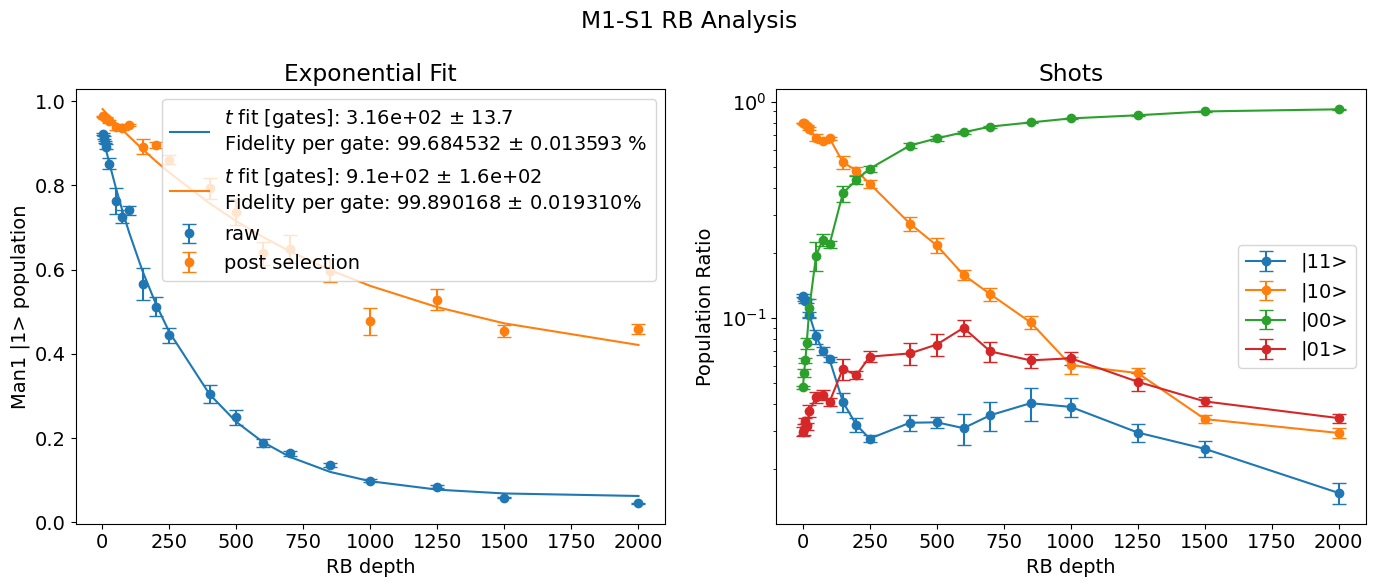

supertitle is  Text(0.5, 0.98, 'M1-S1 RB Analysis')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-26_08-53-52_M1-S1_RB_Analysis.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-26.md
filenames: ['00000_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00001_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00002_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00003_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00004_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00005_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00006_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00007_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00008_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00009_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00010_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00011_SingleBeamSplitterRBPostSelection_sweep_d

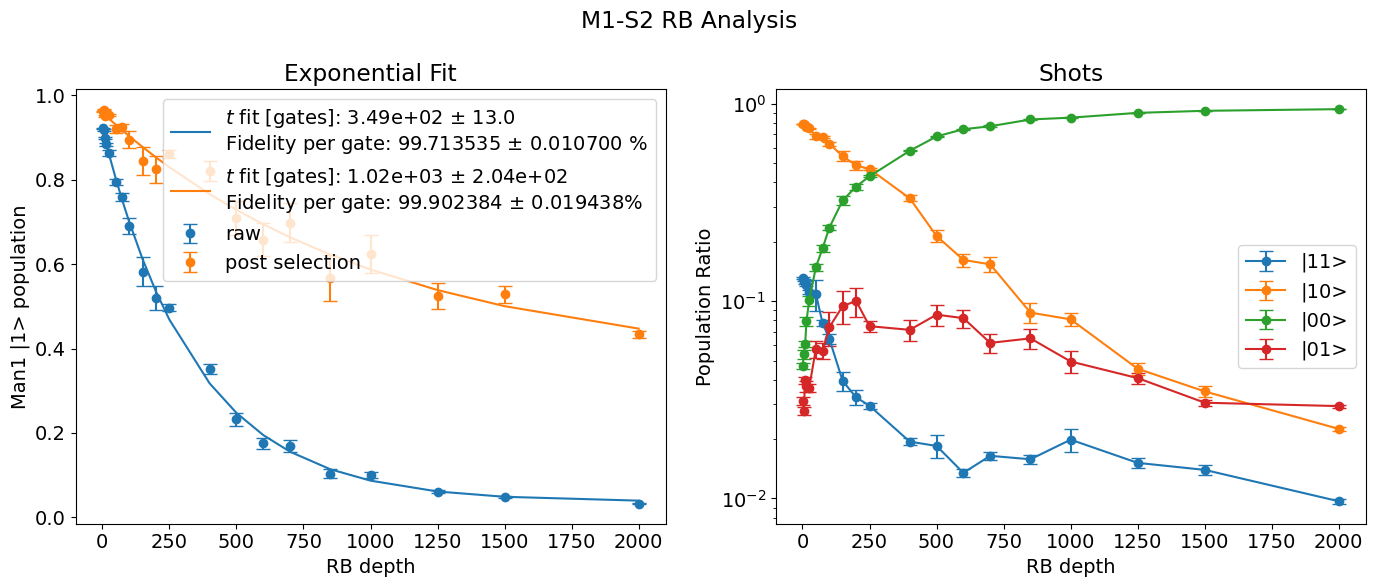

supertitle is  Text(0.5, 0.98, 'M1-S2 RB Analysis')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-26_08-54-05_M1-S2_RB_Analysis.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-26.md
filenames: ['00000_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00001_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00002_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00003_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00004_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00005_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00006_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00007_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00008_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00009_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00010_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00011_SingleBeamSplitterRBPostSelection_sweep_d

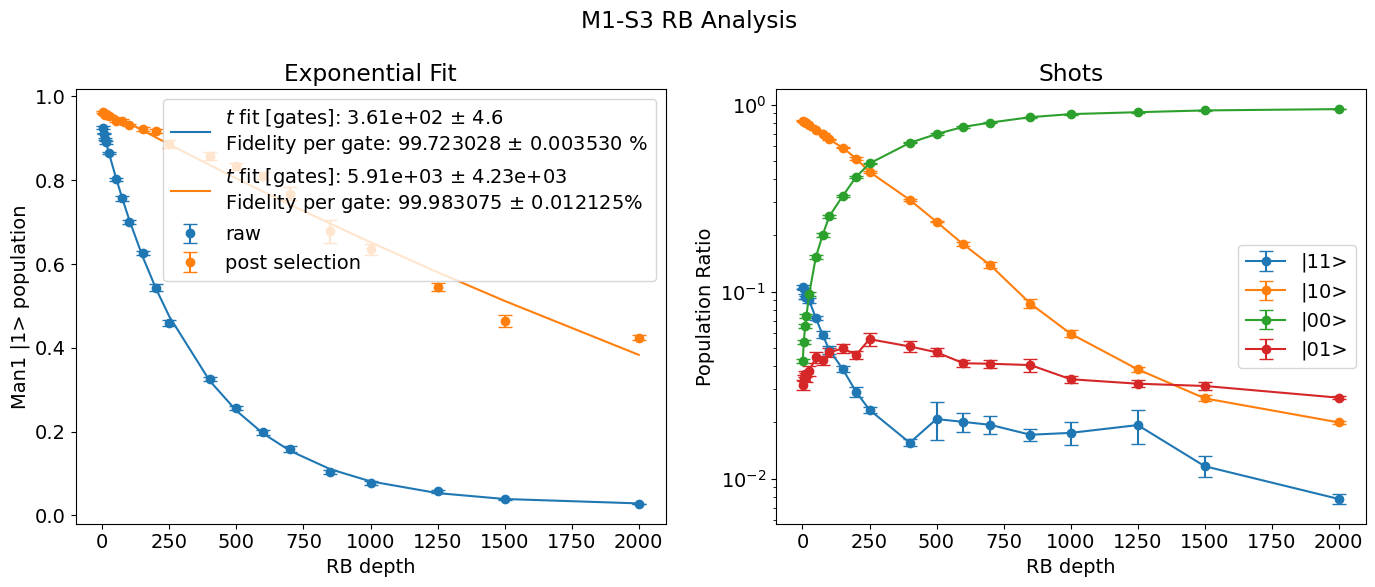

supertitle is  Text(0.5, 0.98, 'M1-S3 RB Analysis')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-26_08-54-18_M1-S3_RB_Analysis.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-26.md
filenames: ['00000_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00001_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00002_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00003_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00004_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00005_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00006_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00007_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00008_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00009_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00010_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00011_SingleBeamSplitterRBPostSelection_sweep_d

C:\_Lib\python\multimode_expts\experiments\fitting.py:55: RuntimeWarning: overflow encountered in exp
  return y0 + yscale*np.exp(-(x-x0)/decay)


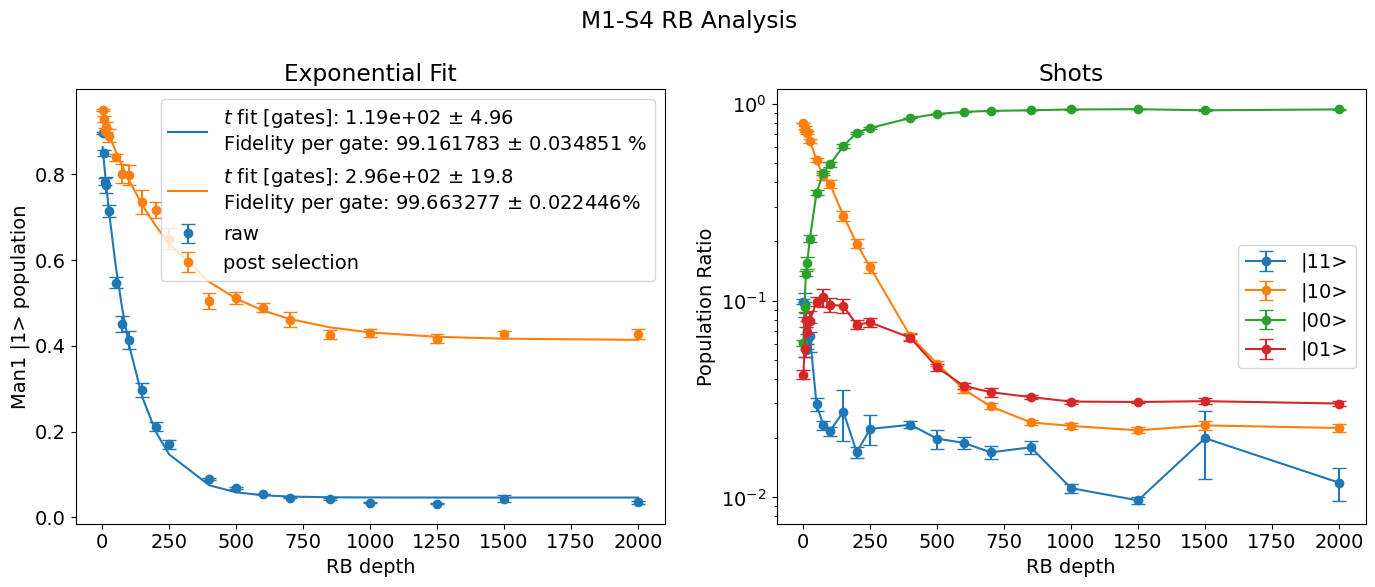

supertitle is  Text(0.5, 0.98, 'M1-S4 RB Analysis')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-26_08-54-33_M1-S4_RB_Analysis.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-26.md
filenames: ['00000_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00001_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00002_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00003_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00004_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00005_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00006_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00007_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00008_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00009_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00010_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00011_SingleBeamSplitterRBPostSelection_sweep_d

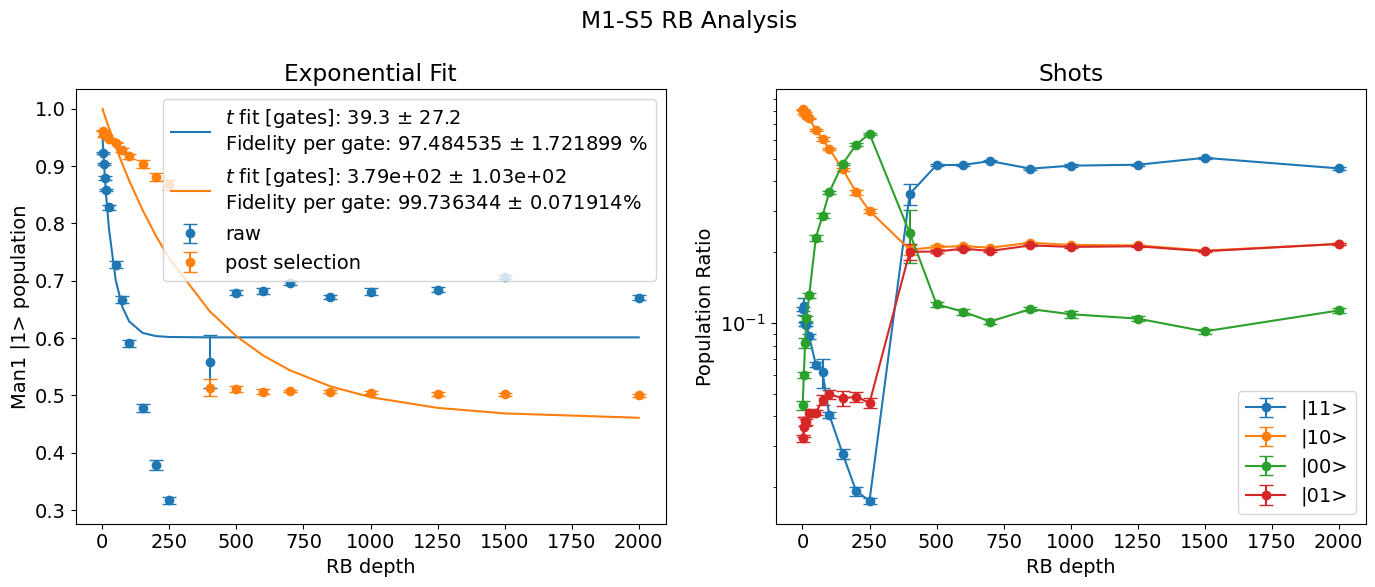

supertitle is  Text(0.5, 0.98, 'M1-S5 RB Analysis')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-26_08-54-46_M1-S5_RB_Analysis.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-26.md
filenames: ['00000_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00001_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00002_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00003_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00004_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00005_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00006_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00007_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00008_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00009_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00010_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00011_SingleBeamSplitterRBPostSelection_sweep_d

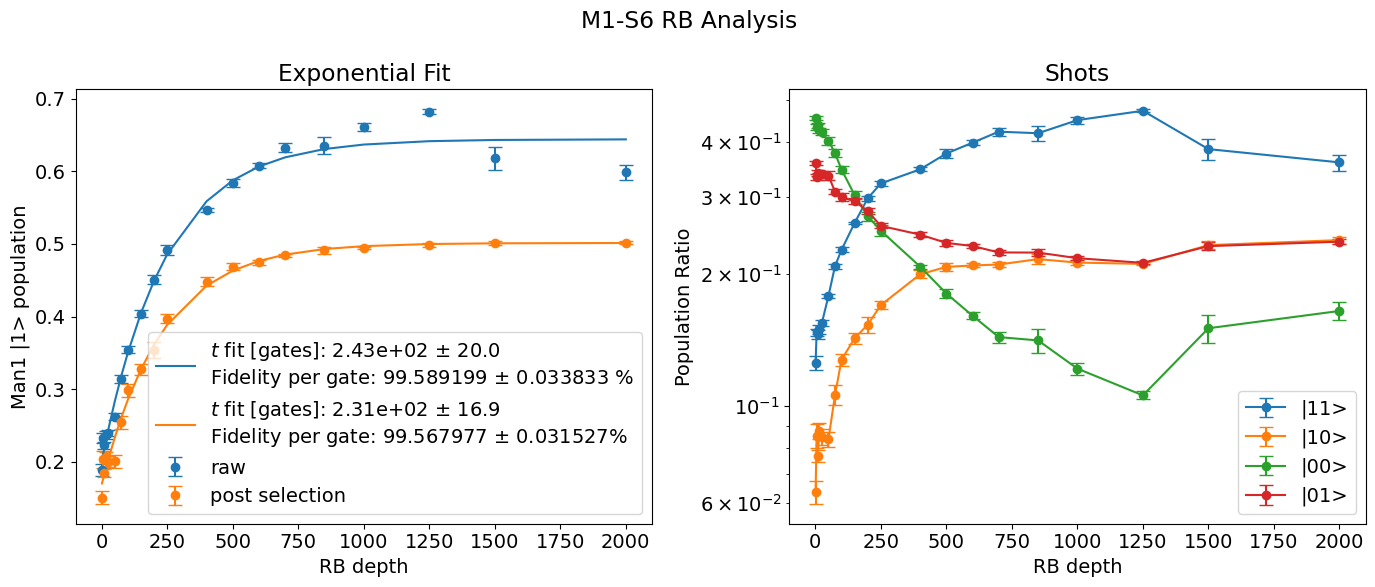

supertitle is  Text(0.5, 0.98, 'M1-S6 RB Analysis')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-26_08-54-58_M1-S6_RB_Analysis.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-26.md
filenames: ['00000_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00001_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00002_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00003_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00004_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00005_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00006_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00007_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00008_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00009_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00010_SingleBeamSplitterRBPostSelection_sweep_depth.h5', '00011_SingleBeamSplitterRBPostSelection_sweep_d

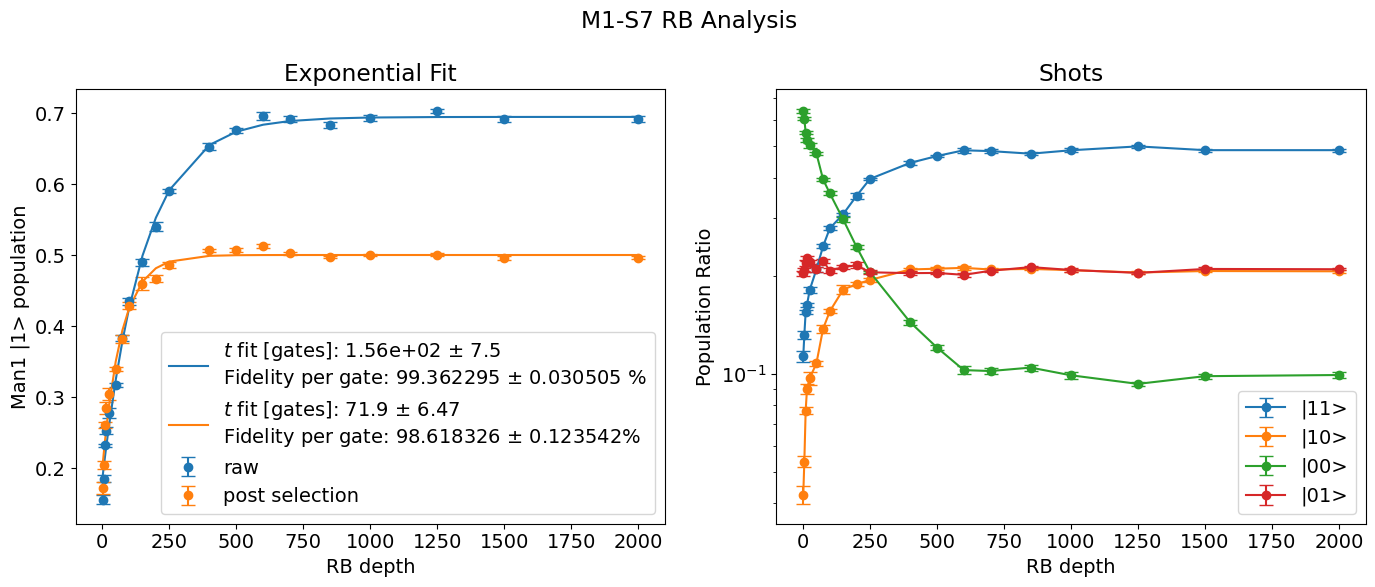

supertitle is  Text(0.5, 0.98, 'M1-S7 RB Analysis')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-26_08-55-10_M1-S7_RB_Analysis.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-26.md
filenames: 0


TypeError: object of type 'int' has no len()

In [ ]:
# from multimode_expts.fit_display_classes import MM_DualRailRBFitting
# dir_no = np.arange(72, 80, 1 )
# for idx, dir_no in enumerate(dir_no):
#     prefix = f"SingleBeamSplitterRBPostSelection_sweep_depth"
#     dir_name = f"{str(dir_no).zfill(5)}_SingleBeamSplitterRBPostSelection_sweep_depth" 
#     dir_path = r"H:\\\\Shared drives\\\\SLab\\\\Multimode\\\\experiment\\\\250505_craqm\\\\data\\\\" + dir_name
#     filepath = dir_path
#     # Initialize RB analysis
#     rb_analysis = MM_DualRailRBFitting(
#         filename=None,
#         file_prefix=prefix,
#         config=yaml_cfg,
#         expt_path=expt_path,
#         title=f"M1-S{idx + 1} RB Analysis",
#         prev_data=prev_data,
#         dir_path=filepath
#     )
#     rb_analysis.show_rb(save_fig=True)



In [ ]:
dir_no = 78
dir_name = f"{str(dir_no).zfill(5)}_SingleBeamSplitterRBPostSelection_sweep_depth" 
dir_path = r"H:\\\\Shared drives\\\\SLab\\\\Multimode\\\\experiment\\\\250505_craqm\\\\data\\\\" + dir_name
temp_data, attrs, filename = prev_data(dir_path, prefix='SingleBeamSplitterRBPostSelection_sweep_depth')

In [ ]:
atrrs = AttrDict(attrs)
attrs['config']['device']['qubit']['f_ge']

[3569.4263053206314]

In [ ]:
storage_rb

In [ ]:
expt_test = Experiment(
            path=expt_path,
            prefix="yoyoyo",
            config_file=config_path,
        )

In [ ]:
expt_test.data = {}
f = expt_test.save_data()

In [ ]:
filename = expt_test.fname
#create a directory with the filename but no .h5 extension
import os
directory = filename
if directory.lower().endswith('.h5'):
    directory = directory[:-3]
if not os.path.exists(directory):
    # Only create the directory if it is not the same as the filename (i.e., filename is not a directory itself)
    # Make sure the directory name does not have a .h5 extension
    os.makedirs(directory)

In [ ]:
directory
filename_only = os.path.basename(expt_test.fname)
filename_only

'00001_yoyoyo.h5'

In [ ]:
from multimode_expts.fit_display_classes import MM_DualRailRBFitting
rb_analysis = MM_DualRailRBFitting(file_prefix = "SingleBeamSplitterRBPostSelection_sweep_depth", 
                                   config=config_thisrun, expt_path=expt_path, title='M1_S1', 
                                   prev_data= prev_data)
rb_analysis.show_rb()

KeyError: 'Idata'

In [ ]:
temp_data, attrs, filename = prev_data(expt_path, '00036_SingleBeamSplitterRBPostSelection_sweep_depth.h5')

In [ ]:
attrs['config'].keys()

dict_keys(['device', 'hw', 'aliases', 'data_management'])

In [ ]:
temp_data.keys()

dict_keys(['Idata', 'Ie', 'Ig', 'Qdata', 'Qe', 'Qg', 'angle', 'confusion_matrix', 'depth_sweep', 'fids', 'sequences', 'thresholds'])

In [ ]:
num_entries = len(temp_data['Idata'])
print(f"Number of entries in 'Idata': {num_entries}")

Number of entries in 'Idata': 3


In [ ]:
temp_data['sequences']

array([[[ 6.,  4., nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [ 5.,  3., nan, nan, nan, nan, nan, nan, nan, nan, nan]],

       [[ 6.,  6.,  5.,  6.,  1.,  3., nan, nan, nan, nan, nan],
        [ 4.,  4.,  3.,  3.,  6.,  4., nan, nan, nan, nan, nan]],

       [[ 4.,  2.,  4.,  5.,  6.,  2.,  3.,  3.,  2.,  2.,  5.],
        [ 5.,  4.,  3.,  4.,  4.,  6.,  6.,  4.,  3.,  1.,  6.]]])

# Shock TLS

In [ ]:
from multimode_expts.experiments.single_qubit.pulse_probe_f0g1_spectroscopy import PulseProbeF0g1SpectroscopyExperiment

def do_pulse_probe_f0g1_spectroscopy(config_thisrun, expt_path, config_path, 
                                     start=2007, step=0.02, expts=300, reps=100,
                                       rounds=1, length=1, gain=5000, pulse_type='gaussian',
                                         qubit_f=True, qubits=[0], prepulse=False, pre_sweep_pulse=None):
    """
    Run the PulseProbeF0g1SpectroscopyExperiment with specified parameters.
    """
    
    expt = PulseProbeF0g1SpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeF0g1SpectroscopyExperiment', config_file=config_path
    )
    expt.cfg = AttrDict(deepcopy(config_thisrun))
    expt.cfg.expt = dict(
        start=start,
        step=step,
        expts=expts,
        reps=reps,
        rounds=rounds,
        length=length,
        gain=gain,
        pulse_type=pulse_type,
        qubit_f=qubit_f,
        qubits=qubits,
        prepulse=prepulse,
        pre_sweep_pulse=pre_sweep_pulse
    )
    expt.cfg.device.readout.relax_delay = [5]  # Wait time between experiments [us]
    expt.go(analyze=True, display=True, progress=True, save=True)
    return expt

fge is  3569.1611355297428
fef is  3426.287416084909


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00214_RamseyExperiment.h5
No echoes in the data
Current pi pulse frequency: 3569.1611355297428
Fit frequency from I [MHz]: 0.18627143359850185 +/- 0.0025402899509618087
Suggested new pi pulse frequency from fit I [MHz]:
 	3569.174864096144
 	3569.5474069633415
T2 Ramsey from fit I [us]: 14.211156885939799
Fit frequency from Q [MHz]: 0.1870672010005787 +/- 0.0026706020798542484
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3569.174068328742
 	3569.5482027307435
T2 Ramsey from fit Q [us]: 14.556560877978708


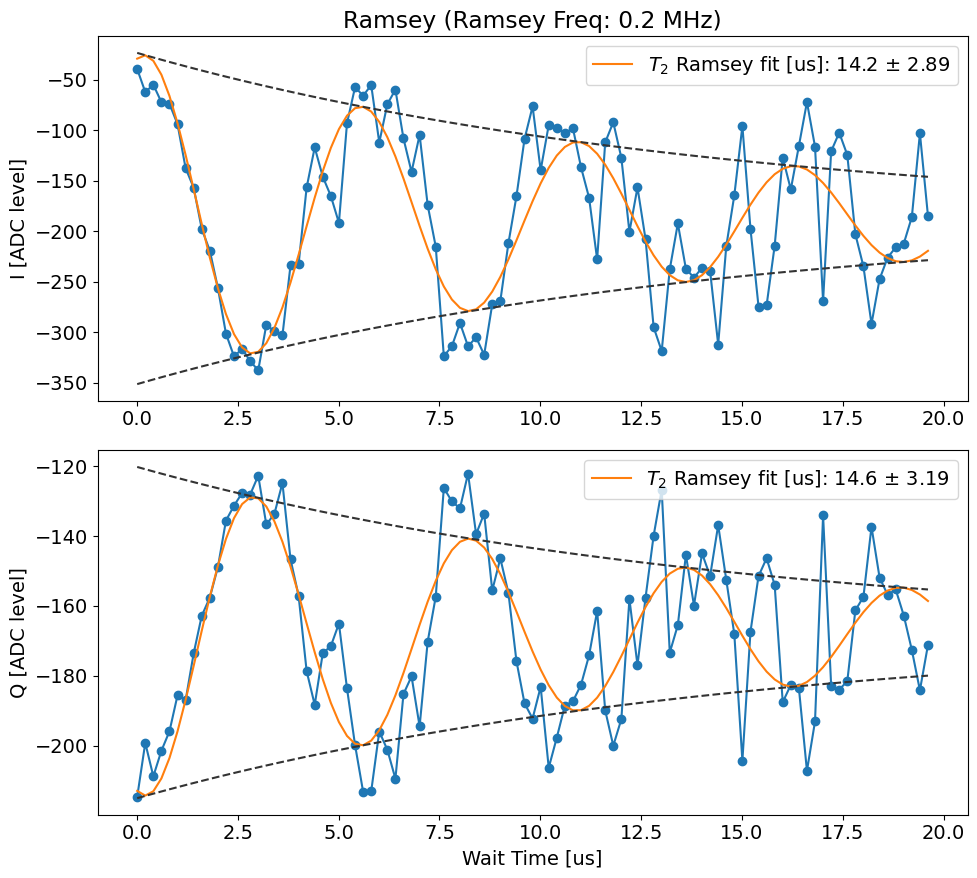

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-29_16-22-31_T2_ge_TLS.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-29.md


  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# t2ramsey_ge_check = None
# while True: 
#     #close previous plots 
#     # import matplotlib.pyplot as plt
#     #each iteration is 5 minutes
#     # do_pulse_probe_f0g1_spectroscopy(
#     #     config_thisrun, expt_path, config_path,
#     #     start=3300, step=0.04, expts=10000, reps=100,
#     #     rounds=5, length=50, gain=30000, pulse_type='gaussian',
#     #     qubit_f=False, qubits=[0], prepulse=False, pre_sweep_pulse=None
#     # )

#     do_pulse_probe_ge(config_thisrun, start = 3300, 
#                       step = 0.04, expts = 10000, reps = 100, rounds = 5,
#                       length = 50, gain = 30000)
#     from IPython.display import clear_output
#     # from multimode_expts.fit_display_classes import SidebandFitting
#     clear_output(wait=True)
#     plt.close('all')  # Close all existing figures
#     t2ramsey_ge_check = do_t2_ramsey_ge(config_thisrun, expt_path, config_path)
#     t2ramsey_ge_check.analyze()
#     t2ramsey_ge_check.display(title_str='T2_ge_TLS')


In [ ]:
from multimode_expts.MM_base import MMAveragerProgram
from multimode_expts.experiments.qsim.utils import ensure_list_in_cfg

class ShockTLSProgram(MMAveragerProgram):
    def initialize(self):
        self.MM_base_initialize()
        
        
    def body(self):
        self.reset_and_sync()

        self.setup_and_pulse(
            ch=0,
            style='const',
            freq=self.freq2reg(1918, gen_ch=0),
            length=50,
            phase=0,
            gain=30000,
        )
    def update(self):
        self.mathi(self.q_rp, self.r_freq2, self.r_freq2, '+', self.f_step) # update frequency list index


class ShockTLSExperiment(Experiment):
    def acquire(self, progress):
        ensure_list_in_cfg(self.cfg)
        
        self.prog = ShockTLSProgram(soccfg=self.soccfg, cfg=self.cfg)
        self.prog.acquire(self.im[self.cfg.aliases.soc],
                         threshold=None,
                         load_pulses=True,
                         progress=progress,
                         debug=False)
    

In [ ]:
scktls = ShockTLSExperiment(soccfg=soc, path=expt_path, prefix='shockTLS',
                           config_file=config_path)
scktls.cfg = AttrDict(deepcopy(config_thisrun))

scktls.cfg.expt = dict(expts=2000, reps=2000, rounds=100000, qubit=[0])

scktls.cfg.device.readout.relax_delay = [50] # Wait time between experiments [us]
for kk in range(50):
    scktls.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Update Config and Dataset

In [ ]:
def convert_attrdict_to_dict(attrdict):
    """
    Recursively converts an AttrDict or a nested dictionary into a standard Python dictionary.
    Converts np.float64 values to standard Python float.

    Args:
        attrdict (AttrDict or dict): The input AttrDict or dictionary to be converted.

    Returns:
        dict: A standard Python dictionary with all nested AttrDicts or dictionaries converted.
    """
    if isinstance(attrdict, AttrDict):
        return {key: convert_attrdict_to_dict(value) for key, value in attrdict.items()}
    elif isinstance(attrdict, dict):
        return {key: convert_attrdict_to_dict(value) for key, value in attrdict.items()}
    elif isinstance(attrdict, np.float64):
        return float(attrdict)
    else:
        return attrdict


def convert_numbers_to_float(data):
    """
    Recursively converts all numbers in a dictionary to float.

    Args:
        data (dict): The input dictionary.

    Returns:
        dict: A dictionary with all numbers converted to float.
    """
    if isinstance(data, dict):
        return {key: convert_numbers_to_float(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [convert_numbers_to_float(item) for item in data]
    elif isinstance(data, float):
        return float(data)
    elif isinstance(data, int):
        return int(data)
    else:
        return data

## Dataset

In [ ]:
#compare the two datsets
differences = ds_thisrun.compare_with(ds)
# Filter out differences related to 'last_update' column
filtered_differences = [diff for diff in differences if diff['column'] != 'last_update']
# Update labels and calculate differences
for diff in filtered_differences:
    diff['label'] = f"New value: {diff['self_value']}, Old value: {diff['other_value']}"
    diff['difference'] = diff['self_value'] - diff['other_value'] if isinstance(diff['self_value'], (int, float)) and isinstance(diff['other_value'], (int, float)) else None

# Group differences by storage name
grouped_differences = {}
for diff in filtered_differences:
    stor_name = diff['stor_name']
    if stor_name not in grouped_differences:
        grouped_differences[stor_name] = []
    grouped_differences[stor_name].append(diff)

# Print grouped differences
for stor_name, diffs in grouped_differences.items():
    print(f"In {stor_name}:")
    for diff in diffs:
        print(f"  Column '{diff['column']}': new_value = {diff['self_value']}, old_value = {diff['other_value']}, difference = {diff['difference']}")
    grouped_differences[stor_name].append(diff)


In M1-S1:
  Column 'precision (MHz)': new_value = nan, old_value = nan, difference = nan
  Column 'pi (mus)': new_value = 0.9561816662492874, old_value = 0.9488168044238208, difference = 0.007364861825466584
  Column 'h_pi (mus)': new_value = 0.4751599680178745, old_value = 0.4684233857548737, difference = 0.006736582263000834
In M1-S2:
  Column 'precision (MHz)': new_value = nan, old_value = nan, difference = nan
  Column 'pi (mus)': new_value = 1.1171741248619853, old_value = 1.1095290915565774, difference = 0.007645033305407889
  Column 'h_pi (mus)': new_value = 0.5572024969735835, old_value = 0.5478660699492137, difference = 0.009336427024369764
In M1-S3:
  Column 'precision (MHz)': new_value = nan, old_value = nan, difference = nan
  Column 'pi (mus)': new_value = 1.3159433455661154, old_value = 1.3188374721953542, difference = -0.0028941266292388246
  Column 'h_pi (mus)': new_value = 0.6467770862087437, old_value = 0.651846717245506, difference = -0.005069631036762279
In M1-S4:
 

In [ ]:
ds_thisrun.df

stor_name   freq (MHz)  precision (MHz)   pi (mus)  h_pi (mus)  \
0      M1-S1   348.917815              NaN   0.956182    0.475160   
1      M1-S2   520.414253              NaN   1.117174    0.557202   
2      M1-S3   696.148466              NaN   1.315943    0.646777   
3      M1-S4   874.820000              NaN   1.235174    0.619427   
4      M1-S5  1052.782582              NaN   1.962559    0.979321   
5      M1-S6  1244.647695              NaN   1.592175    0.803092   
6      M1-S7  1422.460000              NaN   2.211538    1.093041   
7      M1-S8    -1.000000            -1.00  -1.000000   -1.000000   
8      M1-S9    -1.000000            -1.00  -1.000000   -1.000000   
9     M1-S10    -1.000000            -1.00  -1.000000   -1.000000   
10    M1-S11    -1.000000            -1.00  -1.000000   -1.000000   
11    M1-S12    -1.000000            -1.00  -1.000000   -1.000000   
12        M1  2005.900000              NaN   1.082052    0.532975   
13        M2  1834.950000             0.01   1.054456    0.520515   
14     M2-S1   175.630000             0.01   2.173484    1.086742   
15     M2-S2   346.840000             0.01   0.908835    0.454417   
16     M2-S3   523.220000             0.01   1.561615    0.780808   
17     M2-S4   702.650000             0.01   1.386764    0.693382   
18     M2-S5   878.780000             0.01   1.303372    0.651686   
19     M2-S6  1070.100000             0.01   2.379622    1.189811   
20     M2-S7  1249.700000             0.01   1.796981    0.898491   
21     M2-M1   173.790000             0.01   0.463481    0.231741   
22     M1-D1  2313.426206             0.01  10.000000    0.000000   
23     M2-D2  2094.050000             0.01  15.000000    0.000000   
24      M1-C   973.230000             0.02   0.251127    0.122354   
25     M1_ce  2008.780000             0.02   0.617915    0.304523   

    gain (DAC units)                 last_update  
0               3000  2025-06-04 16:28:12.912630  
1               5000  2025-06-04 16:31:01.032528  
2               9000  2025-06-04 16:33:49.039622  
3               9000  2025-06-04 16:36:37.090280  
4               7500  2025-06-04 16:39:25.181021  
5              13500  2025-06-04 16:42:13.388233  
6              10000  2025-06-04 16:45:01.590826  
7                 -1                     51:31.3  
8                 -1                     51:31.3  
9                 -1                     51:31.3  
10                -1                     51:31.3  
11                -1                     51:31.3  
12             15000  2025-06-04 16:24:35.098422  
13             15000  2025-04-30 11:22:11.432806  
14              1000                     28:20.8  
15              5000                     33:56.1  
16              5000                     22:30.3  
17              9000                     25:33.1  
18             13500                     00:05.4  
19              9000                     30:59.0  
20             12000                     56:07.5  
21              2000  2024-10-06 01:47:25.946153  
22              4000  2025-06-04 17:23:32.148629  
23              8000  2025-01-23 17:22:53.776061  
24              1000  2025-01-20 09:34:00.029234  
25             15000  2025-01-20 09:52:35.311227

In [ ]:
# stor new datset at old file path
updateDataset = True
if updateDataset:
    # store old dataset  into autocalib_path with date-time in the name
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    old_dataset_path = os.path.join(autocalib_path, f'old_dataset_{current_time}.h5')
    ds_thisrun.save_to_file(old_dataset_path)
    print('Old dataset saved to:', old_dataset_path)

    #save new dataset to curreent_dataset path
    ds_thisrun.save_to_file(ds.filename)
    # ds = copy(ds_thisrun)
    print('New dataset saved to old file path!')

Old dataset saved to: H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\autocalibration_plots_2025-06-04\old_dataset_2025-06-04_17-25-08.h5
New dataset saved to old file path!


## Config

In [ ]:
from pprint import pprint
print("Comparing configurations:")

def recursive_compare(d1, d2, path=""):
    for key in d1.keys():
        current_path = f"{path}.{key}" if path else key
        if key not in d2:
            print(f"Key '{current_path}' is missing in config2.")
        elif isinstance(d1[key], dict) and isinstance(d2[key], dict):
            recursive_compare(d1[key], d2[key], current_path)
        elif d1[key] != d2[key]:
            print(f"Key '{current_path}' differs:")
            if isinstance(d1[key], list) and len(d1[key]) == 1:
                print(f"  Old value (config1): {d1[key][0]}")
                print(f"  New value (config2): {d2[key][0]}")
            else:
                print(f"  Old value (config1): {d1[key]}")
                print(f"  New value (config2): {d2[key]}")
    for key in d2.keys():
        current_path = f"{path}.{key}" if path else key
        if key not in d1:
            print(f"Key '{current_path}' is missing in config1.")

recursive_compare(yaml_cfg, config_thisrun)

Comparing configurations:
Key 'device.qubit.f_ge' differs:
  Old value (config1): 3567.350428858004
  New value (config2): 3567.3621176882566
Key 'device.qubit.f_ef' differs:
  Old value (config1): 3423.9915809856466
  New value (config2): 3423.998699387194
Key 'device.readout.phase' differs:
  Old value (config1): 28.477545481771585
  New value (config2): 26.883374172655888
Key 'device.readout.threshold' differs:
  Old value (config1): -334.7876841606885
  New value (config2): -305.5327404544614
Key 'device.readout.threshold_list' differs:
  Old value (config1): [-334.7876841606885]
  New value (config2): [-305.5327404544614]
Key 'device.readout.confusion_matrix_without_reset' differs:
  Old value (config1): [0.9969411764705884, 0.0030588235294115584, 0.021825862473597756, 0.9781741375264023]
  New value (config2): [0.9924, 0.007600000000000051, 0.02359999999999999, 0.9764]
Key 'device.readout.Ie' differs:
  Old value (config1): -107.33056110073491
  New value (config2): -42.742959181

In [ ]:
# Copy contents from config_thisrun to yaml_cfg except for the storage_man_file
def update_yaml_config(yaml_cfg, config_thisrun):
    """
    Update the yaml_cfg with values from config_thisrun, excluding the storage_man_file.
    """
    updated_config = deepcopy(config_thisrun)
    updated_config.device.storage.storage_man_file = yaml_cfg.device.storage.storage_man_file
    return updated_config

def save_configurations(yaml_cfg, config_thisrun, autocalib_path, config_path):
    """
    Save the old and updated configurations to their respective files.
    """
    # Save old configuration
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    old_config_path = os.path.join(autocalib_path, f'old_config_{current_time}.yaml')
    old_config = convert_numbers_to_float(convert_attrdict_to_dict(yaml_cfg) )
    with open(old_config_path, 'w') as cfg_file:
        yaml.dump(old_config, cfg_file, default_flow_style=False, indent=4, width=80, canonical=False,
                  explicit_start=True, explicit_end=False, sort_keys=False, line_break=True)

    # Save updated configuration
    updated_config = convert_numbers_to_float(convert_attrdict_to_dict(update_yaml_config(yaml_cfg, config_thisrun)))
    with open(config_path, 'w') as f:
        yaml.dump(updated_config, f, default_flow_style=False, indent=4, width=80, canonical=False,
                  explicit_start=True, explicit_end=False, sort_keys=False, line_break=True)

# Main logic
updateConfig_bool = False# Set to FALSE after this run!!!!!!
updated_config = update_yaml_config(yaml_cfg, config_thisrun)
if updateConfig_bool:
    save_configurations(yaml_cfg, updated_config, autocalib_path, config_path)
    yaml_cfg = updated_config
    updateConfig_bool = False
    print("Configuration updated and saved, excluding storage_man_file. \n!!!!Please set updateConfig to False after this run!!!!!!.")